# Generating Images with Generative Adversarial Networks (GANs)

The purpose of the project is to test the ability of Generative Adversial Networks (GANs) in generating realistic-looking images.

## Dataset

The dataset used will be FashionMNIST. It contains low resolution ($28 \times 28$) grey-scale images representing different kind of clothes. The dataset is available on keras and accessable in $\texttt{tf.keras.datasets.fashion\_mnist}$. Note that the pixel values for the images are initially in the interval $[0, 255]$. It is required to normalize them since all of the algorithm we will use require them to be in that format.

## Metrics

Measuring the quality of newly generated images is a non-trivial task. Indeed, there is no label associated to each image, and thus it is impossible to measure the quality image-by-image. For that reason, common metrics uses statistical consideration on a generated dataset to test how well the network recovered the statistics of the original data. One of the most common is the Fréchet Inception Distance (FID). The idea of FID is that in a realistic-looking dataset of images, the statistics of the activation of the last hidden layer in a well-trained classificator should be similar to that of a dataset containing real images. Specifically, regarding FID, the Inception-v3 network is used as a classificator. A real dataset $\mathbb{D}_r$ and a generated dataset $\mathbb{D}_g$ are processed by the network, and the activation of the last hidden layer has mean and variance $(\mu_r, \Sigma_r)$, $(\mu_g, \Sigma_g)$ respectively. Then, FID is computed as:

$$
    FID(\mathbb{D}_r, \mathbb{D}_g) = || \mu_r - \mu_g ||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \ast \Sigma_g)^{\frac{1}{2}})
$$

A Python implementation of FID can be found in the file $\texttt{fid.py}$ that you find attached on Virtuale. Its usage is very simple, just generate $10k$ fake images with your GAN, and with the command $\texttt{fid.get\_fid(x\_test, x\_gen)}$, where $\texttt{x\_test}$ is the test set, containing $10k$ real images, you get the value for the FID of your network. Remember that, when passed through that function, $\texttt{x\_gen}$ **must** be a dataset of $10k$ images, in the interval $[0, 1]$. The number of $10k$ images is fundamental, since the value of FID strongly depends on the number of input images.

## Limitations

You are required to implement a vanilla Generative Adversarial Network (GAN), not a variant of it (e.g. PixelGAN, CycleGAN, ... are **not** accepted). The maximum number of parameters is *15 million*, and every pre-trained network can be used as an add-on (the number of parameters for pre-trained network does not count). Clearly, only the training set can be used to train the network, no additional images (Data Augmentation is ok).

In [ ]:
#for colab
from google.colab import files
import zipfile


uploaded = files.upload()


zip_filename = next(iter(uploaded))


with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses,optimizers,datasets,utils,metrics,callbacks
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

LOAD_MODEL = False

In [2]:
FASHION_MNIST = datasets.fashion_mnist

(train_data, train_labels), (test_data, test_labels) = FASHION_MNIST.load_data()



print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of test samples: {test_data.shape[0]}")
print(f"Original images dimension: {train_data[0].shape[0]} x {train_data[0].shape[1]}")
print(f"Pixel's values range: [{train_data.min()}, {train_data.max()}]")


4422102/4422102 [==============================] - 1s 0us/step
Number of training samples: 60000
Number of test samples: 10000
Original images dimension: 28 x 28
Pixel's values range: [0, 255]


In [3]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    """
    Compute the activation for the model Inception v3 for a given input 'inps'.

    Note: inps is assumed to be normalized in [0, 1].
    """
    n_batches = inps.shape[0] // batch_size

    act = np.zeros([inps.shape[0], 2048], dtype=np.float32)
    for i in range(n_batches):
        # Load a batch of data
        inp = inps[i * batch_size:(i + 1) * batch_size]

        # Resize each image to match the input shape of Inception v3
        inpr = tf.image.resize(inp, (299, 299))

        # Resize images in the interval [-1, 1], given that inpr is in [0, 1].
        inpr = inpr * 2 - 1

        # Predict the activation
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr, steps=1)

        print(f"Processed {str((i + 1) * batch_size)} images.")
    return act


def get_fid(images1, images2):
    """
    Compute the FID between two sets of images.

    Note: it can take several minutes.
    """
    from scipy.linalg import sqrtm

    shape = np.shape(images1)[1]
    print("Computing FID for {} dimensional images".format(images1.shape))

    # Inception v3 requires the input to have 3 channel. If this is not the
    # case, just copy the same channel three times.
    if images1.shape[-1] == 1:
        images1 = np.concatenate([images1, images1, images1], axis=-1)
        images2 = np.concatenate([images2, images2, images2], axis=-1)

    # activation for true images is always the same: we just compute it once
    if os.path.exists("act_mu.npy"):
        mu1 = np.load("act_mu.npy")
        sigma1 = np.load("act_sigma.npy")
    else:
        act1 = get_inception_activations(images1)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        np.save("act_mu.npy", mu1)
        np.save("act_sigma.npy", sigma1)
    print('Done stage 1 of 2')

    act2 = get_inception_activations(images2)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    print('Done stage 2 of 2')

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87910968/87910968 [==============================] - 3s 0us/step


In [40]:
def plot_images(data,n=10, size=(20,20),cmap='gray_r',as_type="float",title:str=None,save_to=None):
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(data[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

def sample_batch(dataset, sample:int=1):
    max_sample_idx = len(dataset)/BATCH_SIZE
    if sample >= 1 or sample < max_sample_idx :
      batch = dataset.take(sample).get_single_element()
      if isinstance(batch, tuple):
          batch = batch[0]
      return batch.numpy()
    else:
      raise ValueError(f"Input a valide sample index: [1,{max_sample_idx}] ")

def plot_history(history,model_name):

    if model_name == "dcgan":
      discriminator_loss = history.history['d_loss']
      discriminator_accuracy = history.history['d_acc']
      generator_accuracy = history.history['g_acc']
    else:
      discriminator_loss = history.history['c_loss']

    generator_loss = history.history['g_loss']

    epochs = range(1,len(generator_loss)+1)
    plt.plot(epochs,discriminator_loss,"b-", label="Discrimator loss")
    plt.plot(epochs,generator_loss,"r--",label="Generator loss")
    plt.title("Discriminator and Generator Loss")
    plt.legend()
    plt.figure()
    plt.show()

    if model_name == "dcgan":
      plt.plot(epochs,discriminator_accuracy,"b-", label="Discrimator accuracy")
      plt.plot(epochs,generator_accuracy,"r--",label="Generator accuracy")
      plt.title("Discriminator and Generator Accuracy")
      plt.legend()
      plt.figure()
      plt.show()

In [45]:
def train(model,model_name,epochs,d_optimizer, g_optimizer,save_models=True,plot_history_flag=True,load_model=LOAD_MODEL):

      print(f"Compiling the {model_name.upper()} model...")

      ckpt_dir = os.path.join("./checkpoint", f"checkpoint_{model_name}.ckpt")
      if load_model and os.path.exists(ckpt_dir):
          print("Loading model weights...")
          model.load_weights(ckpt_dir)
          print("Model weights loaded.")
      else:
          print("No model weights found or loading disabled.")
      model.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer)
      print("Compilation done.")
      print("\n")


      print("Callbacks instantiation...")
      output_dir= os.path.join("./output", f"output_{model_name}")
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      else:
        print("checkpoint path already exists")



      model_checkpoint_callback = callbacks.ModelCheckpoint(
          filepath=os.path.join("./checkpoint", model_name, f"checkpoint_{model_name}.ckpt"),
          save_weights_only=True,
          save_freq="epoch",
          verbose=0,
      )

      log_dir = os.path.join("./logs", f"logs_{model_name}")
      tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)


      class ImageGenerator(callbacks.Callback):
          def __init__(self, num_img, latent_dim):
              self.num_img = num_img
              self.latent_dim = latent_dim

          def on_epoch_end(self, epoch, logs=None):
              random_latent_vectors = tf.random.normal(
                  shape=(self.num_img, self.latent_dim)
              )
              generated_images = self.model.generator(random_latent_vectors)
              #generated_images = generated_images * 127.5 + 127.5
              generated_images = generated_images.numpy()
              plot_images(
                  generated_images,
                  save_to= os.path.join(output_dir,f"generated_img_{epoch:03d}.png"),
                  cmap=None,
              )

      print("Done")
      print("\n")

      # Start training the model.
      print("################################################## START TRAINING ##################################################")
      print("\n")
      history = model.fit(train_dataset,
                          batch_size=BATCH_SIZE,
                          epochs=epochs,
                          callbacks=[model_checkpoint_callback,tensorboard_callback,ImageGenerator(num_img=10,latent_dim=Z_DIM)])

      print("\n")
      print("################################################## END TRAINING ##################################################")
      print("\n")

      if save_models:
        print("Saving Models...")
        generator.save(os.path.join("./models", model_name, "generator"))
        if model_name == "dcgan":
          discriminator.save(os.path.join("./models", model_name, "discriminator"))
        else:
          critic.save(os.path.join("./models", model_name, "critic"))
        print("Saving Done")
        print("\n")

      if plot_history_flag:
        plot_history(history,model_name)

      return history, model


## DCGAN

In [6]:
#hyperparameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = 100
EPOCHS = 100
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1


In [7]:
def make_dataset(data,shuffle=True,batch_size=BATCH_SIZE,seed=None)->tf.data.Dataset:

    data = data.astype(np.float32) / 255.0
    data = np.pad(data, ((0, 0), (2, 2), (2, 2)),constant_values=0.)
    data = np.expand_dims(data, axis=-1)
    #data = data - 127.5 / 127.5

    if shuffle:
        dataset = tf.data.Dataset.from_tensor_slices((data)).shuffle(1000)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
    return dataset

train_dataset = make_dataset(train_data,batch_size=BATCH_SIZE)
#test_dataset = make_dataset(test_data,shuffle=False,batch_size=BATCH_SIZE)

Shape of image batch: (512, 32, 32, 1)
Pixel's values range: [0.0, 1.0]


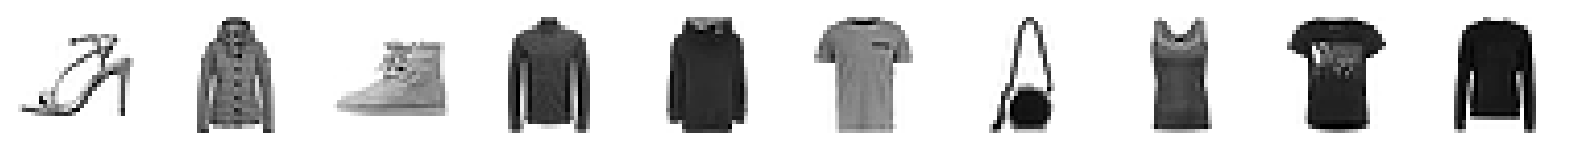

In [8]:
sample = sample_batch(train_dataset)
print("Shape of image batch:", sample.shape)
print(f"Pixel's values range: [{sample.min()}, {sample.max()}]")
plot_images(sample)

In [9]:
class ConvBlockLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2, momentum=0.9,padding='same', use_bias=False, activation='relu',name:str=None):
        super(ConvBlockLayer, self).__init__(name=name)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)
        self.batchnorm = tf.keras.layers.BatchNormalization(momentum=momentum) if momentum is not None else None
        self.activation = tf.keras.layers.LeakyReLU(alpha=alpha) if activation == 'leakyrelu' else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batchnorm(x)
        x = self.activation(x)
        return x

class Upsampling(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2, momentum=0.9, padding='same',activation=None, batchnorm=True, leakyrelu=True, use_bias=False, name:str=None):
        super(Upsampling, self).__init__(name=name)
        self.batchnorm_flag=batchnorm
        self.leakyrelu_flag=leakyrelu
        self.conv_transpose = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding,use_bias=use_bias,activation=activation)
        self.batchnorm = layers.BatchNormalization(momentum=momentum) if momentum is not None else None
        self.leakyrelu = layers.LeakyReLU(alpha=alpha) if self.leakyrelu_flag else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        if self.batchnorm_flag:
          x = self.batchnorm(x)
        if self.leakyrelu_flag:
          x = self.leakyrelu(x)
        return x

### Discriminator

In [10]:
class Discriminator(tf.keras.Model):
    def __init__(self, discriminator_input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name="Discriminator"):
        super(Discriminator, self).__init__(name=name)
        self.discriminator_input_shape = discriminator_input_shape
        self.model_layers= [
            layers.InputLayer(input_shape=self.discriminator_input_shape,name="InputLayer"),
            ConvBlockLayer(64, kernel_size=4, strides=2,alpha=0.2,momentum=0.9, padding='same', use_bias=False, activation='leakyrelu',name="ConvBlock_1"),
            layers.Dropout(0.7,name="Dropout_1"),
            ConvBlockLayer(128,kernel_size=4, strides=2,alpha=0.2,momentum=0.9, padding='same',use_bias=False, activation='leakyrelu',name="ConvBlock_2" ),
            layers.Dropout(0.7,name="Dropout_2"),
            ConvBlockLayer(256,kernel_size=4, strides=2,alpha=0.2,momentum=0.9, padding='same',use_bias=False, activation='leakyrelu',name="ConvBlock_3" ),
            layers.Dropout(0.7,name="Dropout_3"),
            layers.Flatten(name="Flatten"),
            layers.Dropout(0.7,name="Dropout_4"),
            layers.Dense(1,activation="sigmoid",name="Dense")
        ]


    def call(self,x):
      for layer in self.model_layers:
        x = layer(x)
      return x


In [11]:
discriminator = Discriminator()
discriminator.build((None,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32, 32, 1)]       0         
                                                                 
 ConvBlock_1 (ConvBlockLaye  multiple                  1344      
 r)                                                              
                                                                 
 Dropout_1 (Dropout)         multiple                  0         
                                                                 
 ConvBlock_2 (ConvBlockLaye  multiple                  131712    
 r)                                                              
                                                                 
 Dropout_2 (Dropout)         multiple                  0         
                                                                 
 ConvBlock_3 (ConvBlockLaye  multiple                

### Generator

In [12]:
class Generator(tf.keras.Model):
    def __init__(self,generator_input_shape=(Z_DIM,), name="Generator"):
        super(Generator, self).__init__(name=name)
        self.generator_input_shape = generator_input_shape
        self.model_layers = [
            layers.InputLayer(input_shape=self.generator_input_shape,name="InputLayer"),
            layers.Dense((4 * 4 * 512),name="Dense"),
            layers.BatchNormalization(name="BatchNorm_1"),
            layers.LeakyReLU(0.2,name="LeakyReLU_1"),
            layers.Reshape((4,4,512),name="Reshape"),
            Upsampling(256, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_1"),
            Upsampling(128, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_2"),
            Upsampling(64, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_3"),
            Upsampling(CHANNELS,kernel_size=4, padding="same",activation="tanh",batchnorm=False,leakyrelu=False,use_bias=False,name="Gen_Output")
        ]



    def call(self,x):
        for layer in self.model_layers:
          x = layer(x)
        return x


In [13]:
generator = Generator()
generator.build((None,100))
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 100)]             0         
                                                                 
 Dense (Dense)               multiple                  827392    
                                                                 
 BatchNorm_1 (BatchNormaliz  multiple                  32768     
 ation)                                                          
                                                                 
 LeakyReLU_1 (LeakyReLU)     multiple                  0         
                                                                 
 Reshape (Reshape)           multiple                  0         
                                                                 
 Upsampling_1 (Upsampling)   multiple                  2098176   
                                                         

In [14]:
class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )


        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}


In [15]:
#model instantiation
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

Compiling the DCGAN model...
No model weights found or loading disabled.
Compilation done.


Callbacks instantiation...
Done


################################################## START TRAINING ##################################################
Epoch 1/100
  6/117 [>.............................] - ETA: 8s - d_loss: 1.4658 - d_real_acc: 0.5335 - d_fake_acc: 0.4658 - d_acc: 0.4997 - g_loss: 1.3546 - g_acc: 0.5342

117/117 [==============================] - ETA: 0s - d_loss: 1.1812 - d_real_acc: 0.5736 - d_fake_acc: 0.5526 - d_acc: 0.5631 - g_loss: 1.6622 - g_acc: 0.4474
Saved to ./output/output_dcgan/generated_img_000.png


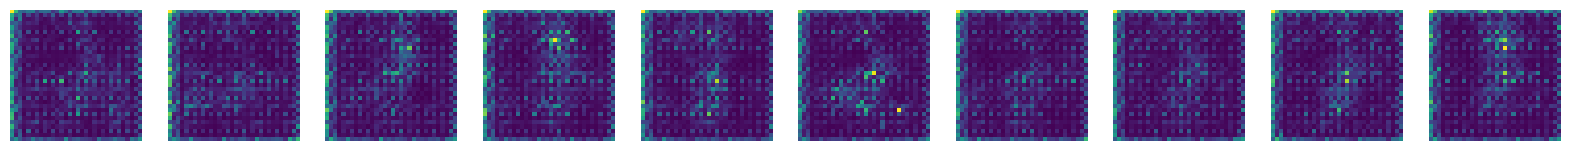

117/117 [==============================] - 35s 95ms/step - d_loss: 1.1812 - d_real_acc: 0.5736 - d_fake_acc: 0.5526 - d_acc: 0.5631 - g_loss: 1.6622 - g_acc: 0.4474
Epoch 2/100
117/117 [==============================] - ETA: 0s - d_loss: 0.8698 - d_real_acc: 0.6406 - d_fake_acc: 0.6249 - d_acc: 0.6328 - g_loss: 1.8715 - g_acc: 0.3751
Saved to ./output/output_dcgan/generated_img_001.png


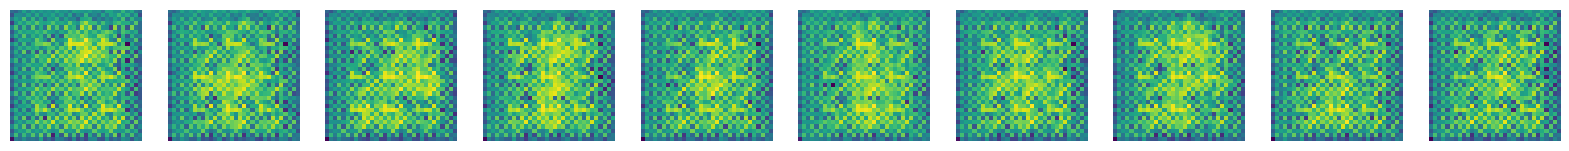

117/117 [==============================] - 9s 80ms/step - d_loss: 0.8698 - d_real_acc: 0.6406 - d_fake_acc: 0.6249 - d_acc: 0.6328 - g_loss: 1.8715 - g_acc: 0.3751
Epoch 3/100
117/117 [==============================] - ETA: 0s - d_loss: 1.1857 - d_real_acc: 0.4890 - d_fake_acc: 0.5349 - d_acc: 0.5119 - g_loss: 1.3458 - g_acc: 0.4651
Saved to ./output/output_dcgan/generated_img_002.png


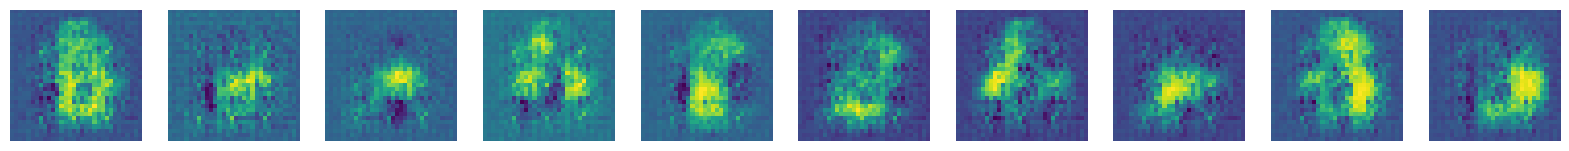

117/117 [==============================] - 9s 79ms/step - d_loss: 1.1857 - d_real_acc: 0.4890 - d_fake_acc: 0.5349 - d_acc: 0.5119 - g_loss: 1.3458 - g_acc: 0.4651
Epoch 4/100
117/117 [==============================] - ETA: 0s - d_loss: 1.0103 - d_real_acc: 0.5153 - d_fake_acc: 0.5373 - d_acc: 0.5263 - g_loss: 1.1738 - g_acc: 0.4627
Saved to ./output/output_dcgan/generated_img_003.png


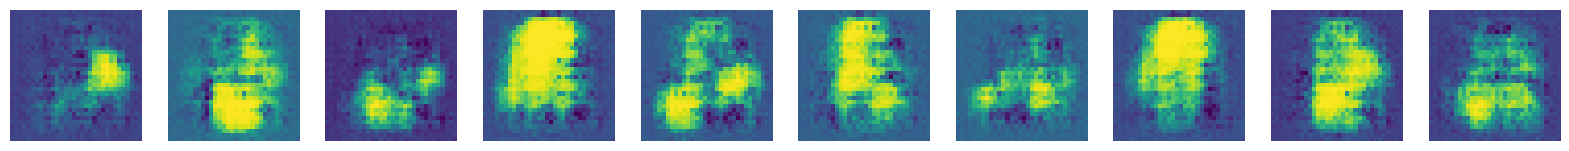

117/117 [==============================] - 9s 79ms/step - d_loss: 1.0103 - d_real_acc: 0.5153 - d_fake_acc: 0.5373 - d_acc: 0.5263 - g_loss: 1.1738 - g_acc: 0.4627
Epoch 5/100
117/117 [==============================] - ETA: 0s - d_loss: 0.8859 - d_real_acc: 0.5319 - d_fake_acc: 0.5523 - d_acc: 0.5421 - g_loss: 1.0929 - g_acc: 0.4477
Saved to ./output/output_dcgan/generated_img_004.png


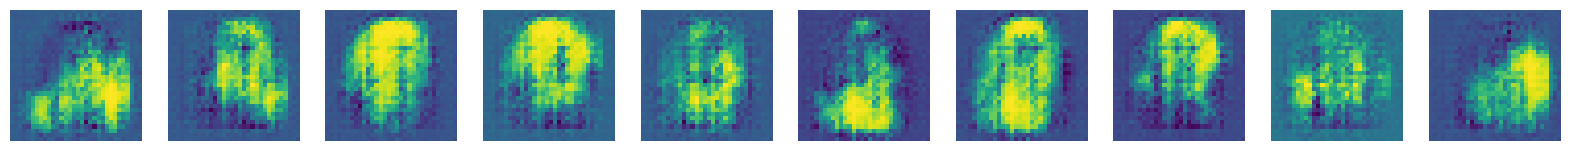

117/117 [==============================] - 10s 81ms/step - d_loss: 0.8859 - d_real_acc: 0.5319 - d_fake_acc: 0.5523 - d_acc: 0.5421 - g_loss: 1.0929 - g_acc: 0.4477
Epoch 6/100
117/117 [==============================] - ETA: 0s - d_loss: 0.8198 - d_real_acc: 0.5317 - d_fake_acc: 0.5564 - d_acc: 0.5440 - g_loss: 1.0110 - g_acc: 0.4436
Saved to ./output/output_dcgan/generated_img_005.png


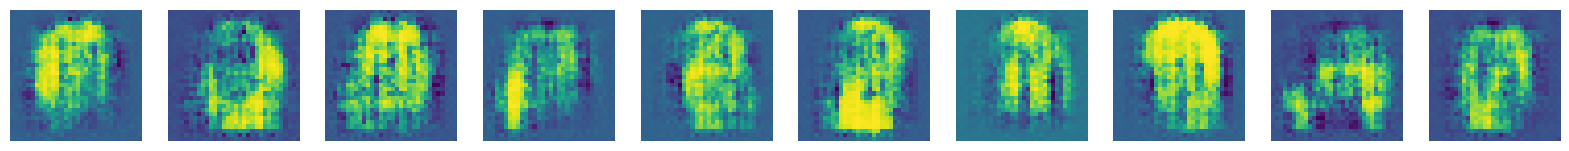

117/117 [==============================] - 9s 80ms/step - d_loss: 0.8198 - d_real_acc: 0.5317 - d_fake_acc: 0.5564 - d_acc: 0.5440 - g_loss: 1.0110 - g_acc: 0.4436
Epoch 7/100
117/117 [==============================] - ETA: 0s - d_loss: 0.7701 - d_real_acc: 0.5478 - d_fake_acc: 0.5532 - d_acc: 0.5505 - g_loss: 0.9337 - g_acc: 0.4468
Saved to ./output/output_dcgan/generated_img_006.png


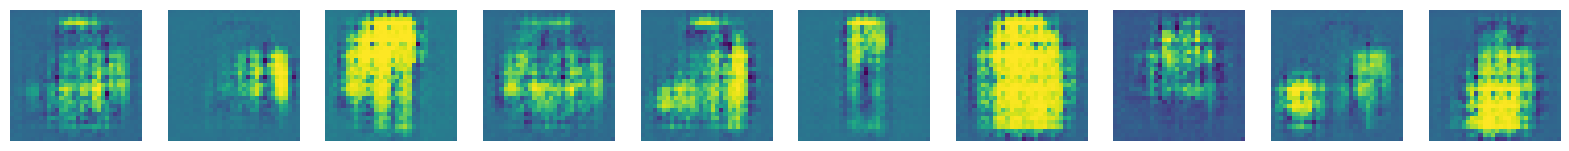

117/117 [==============================] - 9s 79ms/step - d_loss: 0.7701 - d_real_acc: 0.5478 - d_fake_acc: 0.5532 - d_acc: 0.5505 - g_loss: 0.9337 - g_acc: 0.4468
Epoch 8/100
117/117 [==============================] - ETA: 0s - d_loss: 0.7397 - d_real_acc: 0.5524 - d_fake_acc: 0.5506 - d_acc: 0.5515 - g_loss: 0.8731 - g_acc: 0.4494
Saved to ./output/output_dcgan/generated_img_007.png


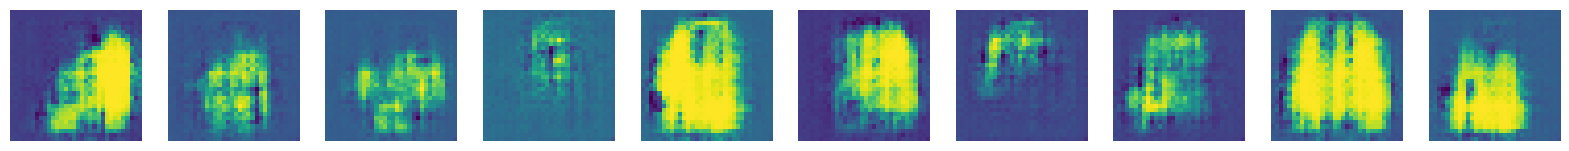

117/117 [==============================] - 10s 82ms/step - d_loss: 0.7397 - d_real_acc: 0.5524 - d_fake_acc: 0.5506 - d_acc: 0.5515 - g_loss: 0.8731 - g_acc: 0.4494
Epoch 9/100
117/117 [==============================] - ETA: 0s - d_loss: 0.7129 - d_real_acc: 0.5622 - d_fake_acc: 0.5565 - d_acc: 0.5593 - g_loss: 0.8403 - g_acc: 0.4435
Saved to ./output/output_dcgan/generated_img_008.png


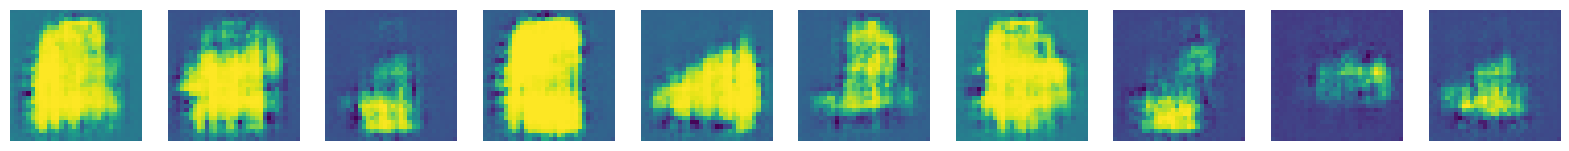

117/117 [==============================] - 9s 80ms/step - d_loss: 0.7129 - d_real_acc: 0.5622 - d_fake_acc: 0.5565 - d_acc: 0.5593 - g_loss: 0.8403 - g_acc: 0.4435
Epoch 10/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6967 - d_real_acc: 0.5718 - d_fake_acc: 0.5627 - d_acc: 0.5672 - g_loss: 0.8202 - g_acc: 0.4373
Saved to ./output/output_dcgan/generated_img_009.png


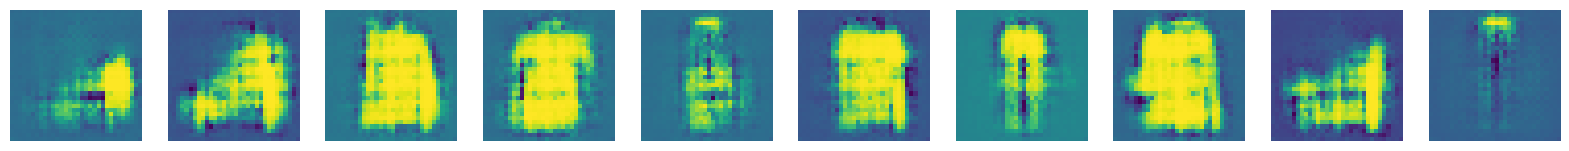

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6967 - d_real_acc: 0.5718 - d_fake_acc: 0.5627 - d_acc: 0.5672 - g_loss: 0.8202 - g_acc: 0.4373
Epoch 11/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6819 - d_real_acc: 0.5806 - d_fake_acc: 0.5726 - d_acc: 0.5766 - g_loss: 0.8112 - g_acc: 0.4274
Saved to ./output/output_dcgan/generated_img_010.png


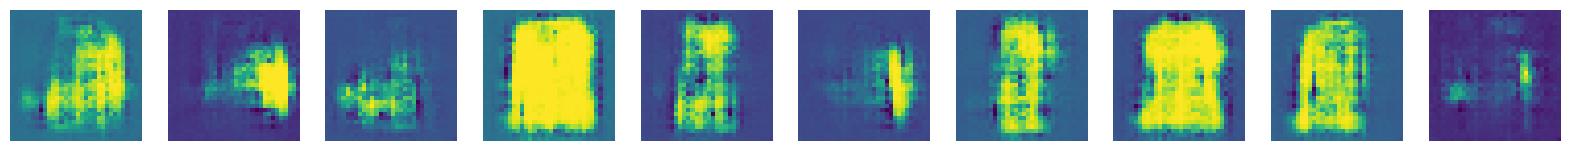

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6819 - d_real_acc: 0.5806 - d_fake_acc: 0.5726 - d_acc: 0.5766 - g_loss: 0.8112 - g_acc: 0.4274
Epoch 12/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6764 - d_real_acc: 0.5799 - d_fake_acc: 0.5817 - d_acc: 0.5808 - g_loss: 0.8089 - g_acc: 0.4183
Saved to ./output/output_dcgan/generated_img_011.png


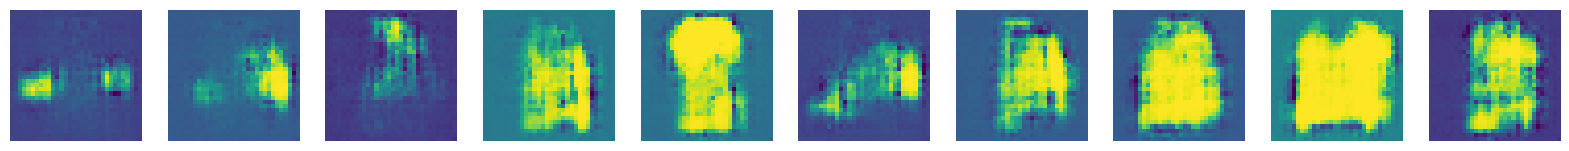

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6764 - d_real_acc: 0.5799 - d_fake_acc: 0.5817 - d_acc: 0.5808 - g_loss: 0.8089 - g_acc: 0.4183
Epoch 13/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6714 - d_real_acc: 0.5794 - d_fake_acc: 0.5891 - d_acc: 0.5842 - g_loss: 0.8067 - g_acc: 0.4109
Saved to ./output/output_dcgan/generated_img_012.png


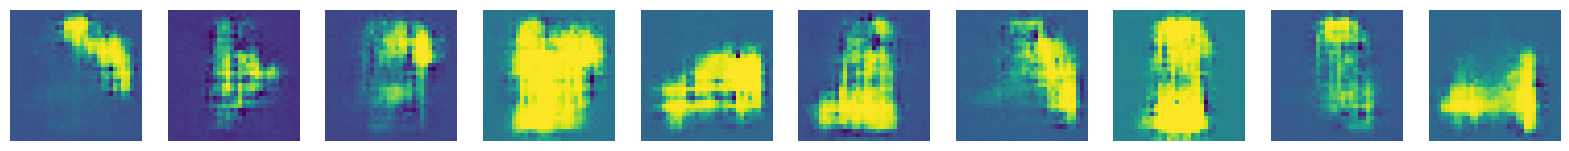

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6714 - d_real_acc: 0.5794 - d_fake_acc: 0.5891 - d_acc: 0.5842 - g_loss: 0.8067 - g_acc: 0.4109
Epoch 14/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6656 - d_real_acc: 0.5832 - d_fake_acc: 0.5954 - d_acc: 0.5893 - g_loss: 0.8112 - g_acc: 0.4046
Saved to ./output/output_dcgan/generated_img_013.png


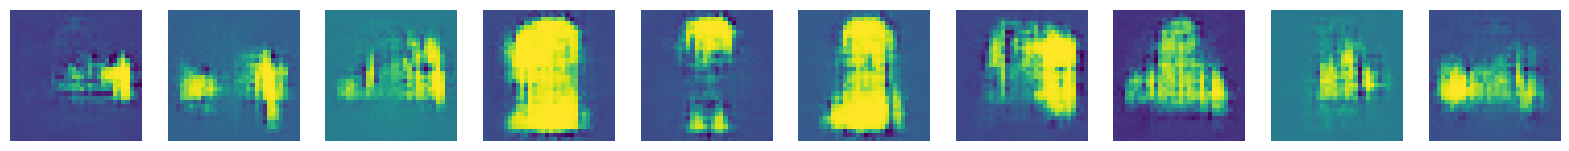

117/117 [==============================] - 10s 81ms/step - d_loss: 0.6656 - d_real_acc: 0.5832 - d_fake_acc: 0.5954 - d_acc: 0.5893 - g_loss: 0.8112 - g_acc: 0.4046
Epoch 15/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6603 - d_real_acc: 0.5905 - d_fake_acc: 0.6018 - d_acc: 0.5962 - g_loss: 0.8143 - g_acc: 0.3982
Saved to ./output/output_dcgan/generated_img_014.png


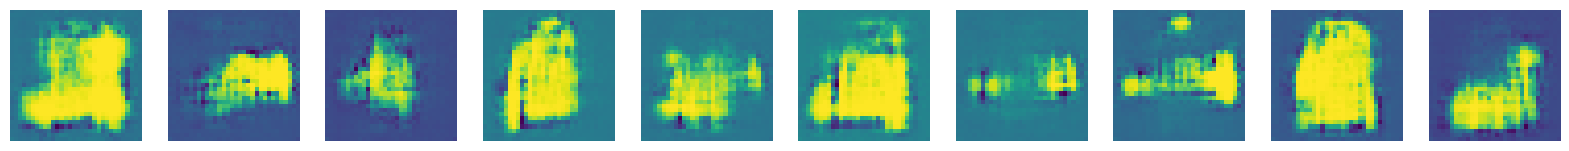

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6603 - d_real_acc: 0.5905 - d_fake_acc: 0.6018 - d_acc: 0.5962 - g_loss: 0.8143 - g_acc: 0.3982
Epoch 16/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6578 - d_real_acc: 0.5908 - d_fake_acc: 0.6060 - d_acc: 0.5984 - g_loss: 0.8191 - g_acc: 0.3940
Saved to ./output/output_dcgan/generated_img_015.png


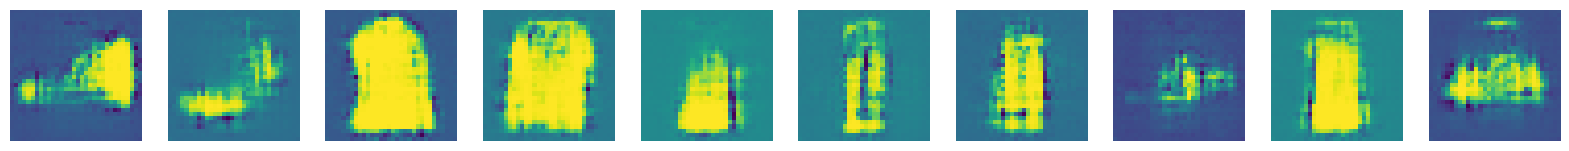

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6578 - d_real_acc: 0.5908 - d_fake_acc: 0.6060 - d_acc: 0.5984 - g_loss: 0.8191 - g_acc: 0.3940
Epoch 17/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6529 - d_real_acc: 0.5965 - d_fake_acc: 0.6117 - d_acc: 0.6041 - g_loss: 0.8252 - g_acc: 0.3883
Saved to ./output/output_dcgan/generated_img_016.png


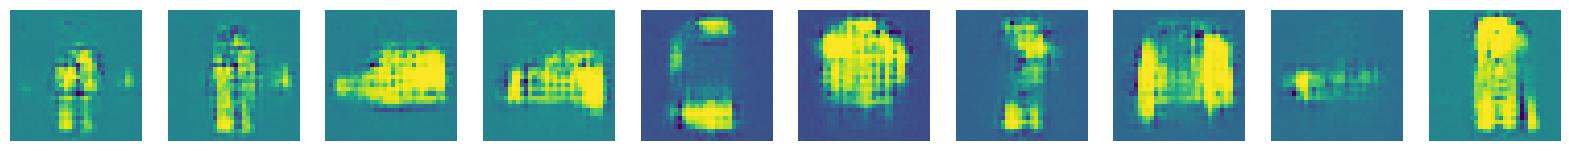

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6529 - d_real_acc: 0.5965 - d_fake_acc: 0.6117 - d_acc: 0.6041 - g_loss: 0.8252 - g_acc: 0.3883
Epoch 18/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6470 - d_real_acc: 0.6052 - d_fake_acc: 0.6176 - d_acc: 0.6114 - g_loss: 0.8328 - g_acc: 0.3824
Saved to ./output/output_dcgan/generated_img_017.png


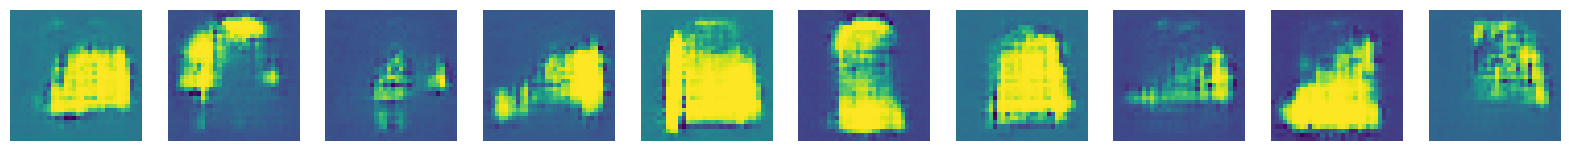

117/117 [==============================] - 10s 81ms/step - d_loss: 0.6470 - d_real_acc: 0.6052 - d_fake_acc: 0.6176 - d_acc: 0.6114 - g_loss: 0.8328 - g_acc: 0.3824
Epoch 19/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6419 - d_real_acc: 0.6149 - d_fake_acc: 0.6214 - d_acc: 0.6182 - g_loss: 0.8429 - g_acc: 0.3786
Saved to ./output/output_dcgan/generated_img_018.png


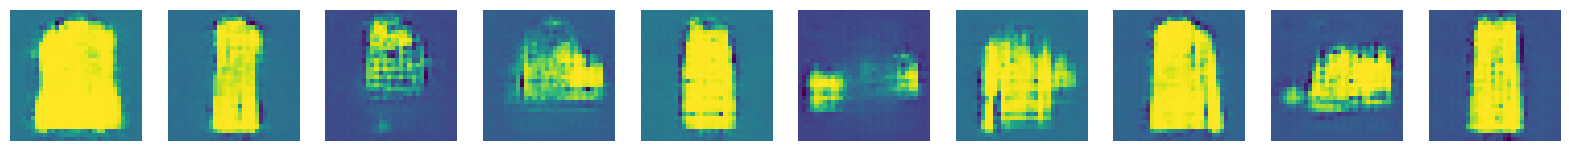

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6419 - d_real_acc: 0.6149 - d_fake_acc: 0.6214 - d_acc: 0.6182 - g_loss: 0.8429 - g_acc: 0.3786
Epoch 20/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6414 - d_real_acc: 0.6205 - d_fake_acc: 0.6197 - d_acc: 0.6201 - g_loss: 0.8465 - g_acc: 0.3803
Saved to ./output/output_dcgan/generated_img_019.png


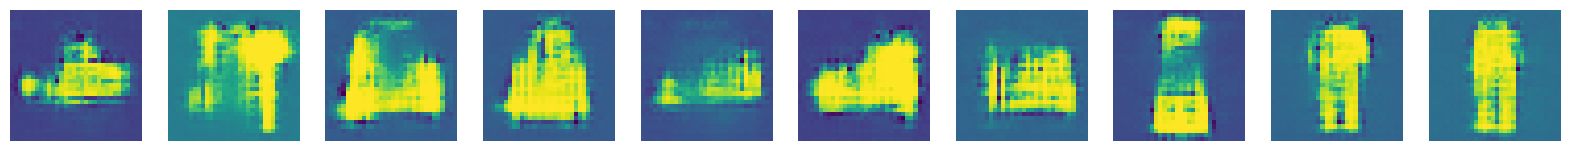

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6414 - d_real_acc: 0.6205 - d_fake_acc: 0.6197 - d_acc: 0.6201 - g_loss: 0.8465 - g_acc: 0.3803
Epoch 21/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6400 - d_real_acc: 0.6262 - d_fake_acc: 0.6156 - d_acc: 0.6209 - g_loss: 0.8473 - g_acc: 0.3844
Saved to ./output/output_dcgan/generated_img_020.png


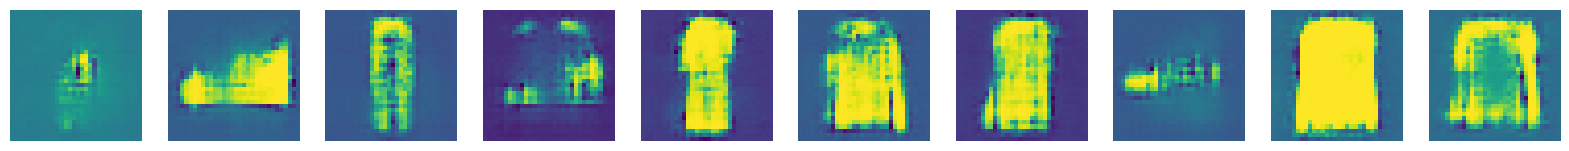

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6400 - d_real_acc: 0.6262 - d_fake_acc: 0.6156 - d_acc: 0.6209 - g_loss: 0.8473 - g_acc: 0.3844
Epoch 22/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6402 - d_real_acc: 0.6227 - d_fake_acc: 0.6176 - d_acc: 0.6202 - g_loss: 0.8502 - g_acc: 0.3824
Saved to ./output/output_dcgan/generated_img_021.png


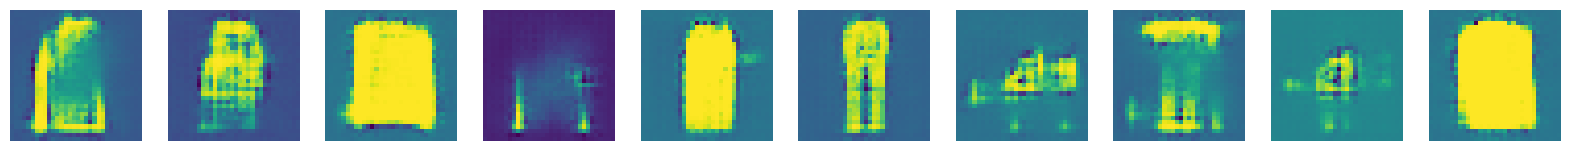

117/117 [==============================] - 10s 81ms/step - d_loss: 0.6402 - d_real_acc: 0.6227 - d_fake_acc: 0.6176 - d_acc: 0.6202 - g_loss: 0.8502 - g_acc: 0.3824
Epoch 23/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6390 - d_real_acc: 0.6246 - d_fake_acc: 0.6183 - d_acc: 0.6215 - g_loss: 0.8529 - g_acc: 0.3817
Saved to ./output/output_dcgan/generated_img_022.png


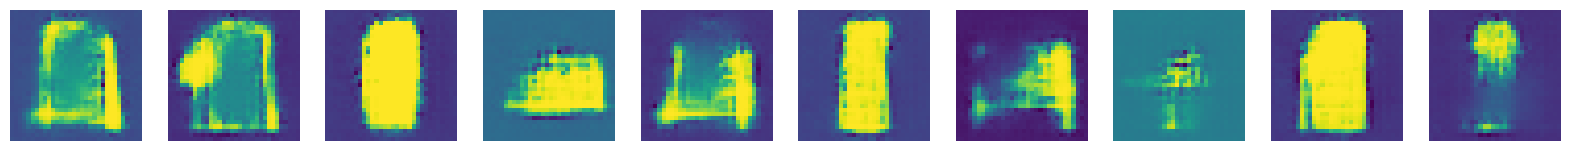

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6390 - d_real_acc: 0.6246 - d_fake_acc: 0.6183 - d_acc: 0.6215 - g_loss: 0.8529 - g_acc: 0.3817
Epoch 24/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6369 - d_real_acc: 0.6235 - d_fake_acc: 0.6222 - d_acc: 0.6229 - g_loss: 0.8612 - g_acc: 0.3778
Saved to ./output/output_dcgan/generated_img_023.png


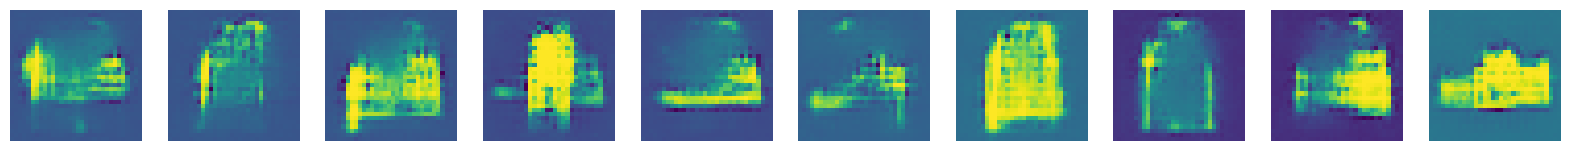

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6369 - d_real_acc: 0.6235 - d_fake_acc: 0.6222 - d_acc: 0.6229 - g_loss: 0.8612 - g_acc: 0.3778
Epoch 25/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6401 - d_real_acc: 0.6190 - d_fake_acc: 0.6199 - d_acc: 0.6195 - g_loss: 0.8602 - g_acc: 0.3801
Saved to ./output/output_dcgan/generated_img_024.png


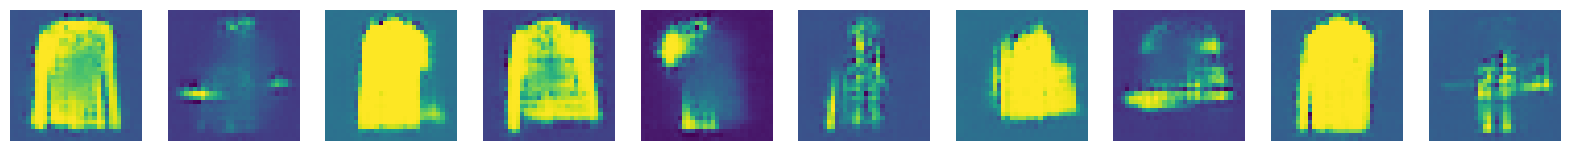

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6401 - d_real_acc: 0.6190 - d_fake_acc: 0.6199 - d_acc: 0.6195 - g_loss: 0.8602 - g_acc: 0.3801
Epoch 26/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6385 - d_real_acc: 0.6231 - d_fake_acc: 0.6202 - d_acc: 0.6217 - g_loss: 0.8591 - g_acc: 0.3798
Saved to ./output/output_dcgan/generated_img_025.png


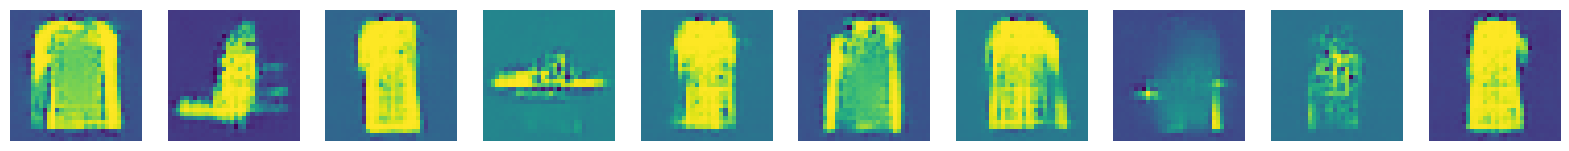

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6385 - d_real_acc: 0.6231 - d_fake_acc: 0.6202 - d_acc: 0.6217 - g_loss: 0.8591 - g_acc: 0.3798
Epoch 27/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6389 - d_real_acc: 0.6207 - d_fake_acc: 0.6216 - d_acc: 0.6212 - g_loss: 0.8625 - g_acc: 0.3784
Saved to ./output/output_dcgan/generated_img_026.png


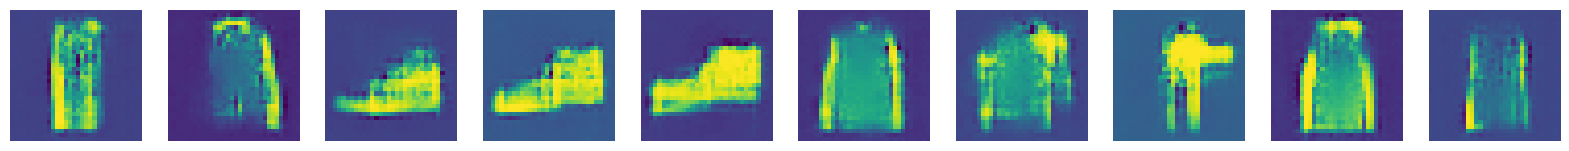

117/117 [==============================] - 10s 85ms/step - d_loss: 0.6389 - d_real_acc: 0.6207 - d_fake_acc: 0.6216 - d_acc: 0.6212 - g_loss: 0.8625 - g_acc: 0.3784
Epoch 28/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6349 - d_real_acc: 0.6265 - d_fake_acc: 0.6252 - d_acc: 0.6258 - g_loss: 0.8641 - g_acc: 0.3748
Saved to ./output/output_dcgan/generated_img_027.png


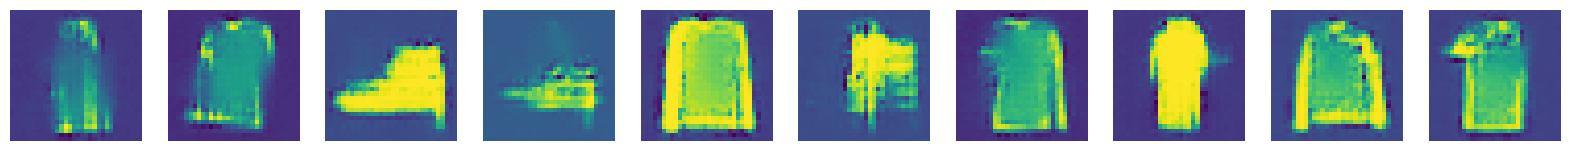

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6349 - d_real_acc: 0.6265 - d_fake_acc: 0.6252 - d_acc: 0.6258 - g_loss: 0.8641 - g_acc: 0.3748
Epoch 29/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6328 - d_real_acc: 0.6261 - d_fake_acc: 0.6265 - d_acc: 0.6263 - g_loss: 0.8720 - g_acc: 0.3735
Saved to ./output/output_dcgan/generated_img_028.png


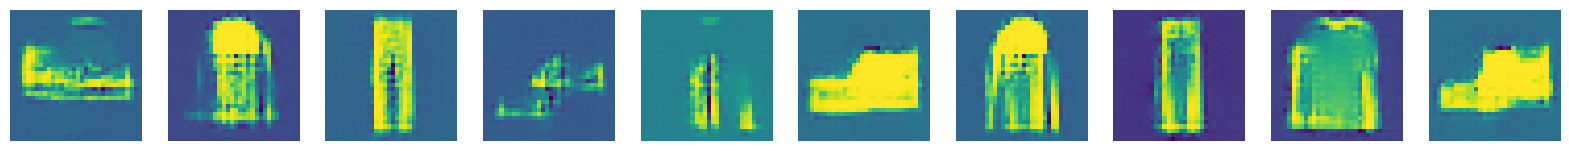

117/117 [==============================] - 10s 85ms/step - d_loss: 0.6328 - d_real_acc: 0.6261 - d_fake_acc: 0.6265 - d_acc: 0.6263 - g_loss: 0.8720 - g_acc: 0.3735
Epoch 30/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6336 - d_real_acc: 0.6265 - d_fake_acc: 0.6247 - d_acc: 0.6256 - g_loss: 0.8726 - g_acc: 0.3753
Saved to ./output/output_dcgan/generated_img_029.png


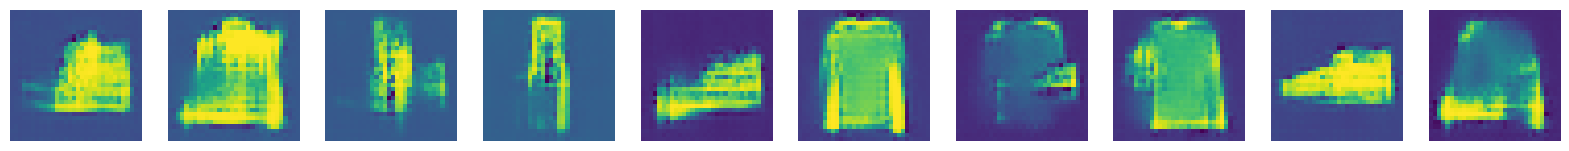

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6336 - d_real_acc: 0.6265 - d_fake_acc: 0.6247 - d_acc: 0.6256 - g_loss: 0.8726 - g_acc: 0.3753
Epoch 31/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6323 - d_real_acc: 0.6284 - d_fake_acc: 0.6247 - d_acc: 0.6266 - g_loss: 0.8742 - g_acc: 0.3753
Saved to ./output/output_dcgan/generated_img_030.png


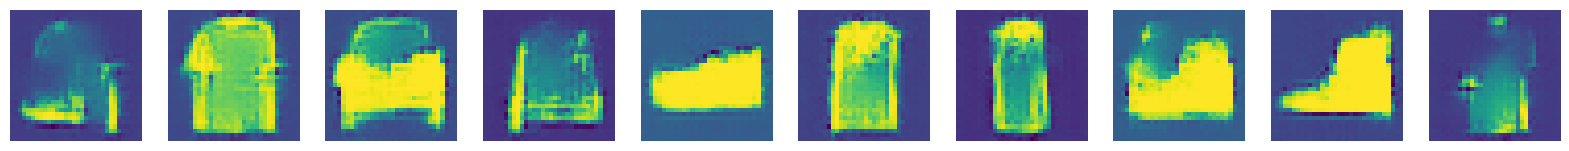

117/117 [==============================] - 10s 81ms/step - d_loss: 0.6323 - d_real_acc: 0.6284 - d_fake_acc: 0.6247 - d_acc: 0.6266 - g_loss: 0.8742 - g_acc: 0.3753
Epoch 32/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6286 - d_real_acc: 0.6344 - d_fake_acc: 0.6289 - d_acc: 0.6317 - g_loss: 0.8819 - g_acc: 0.3711
Saved to ./output/output_dcgan/generated_img_031.png


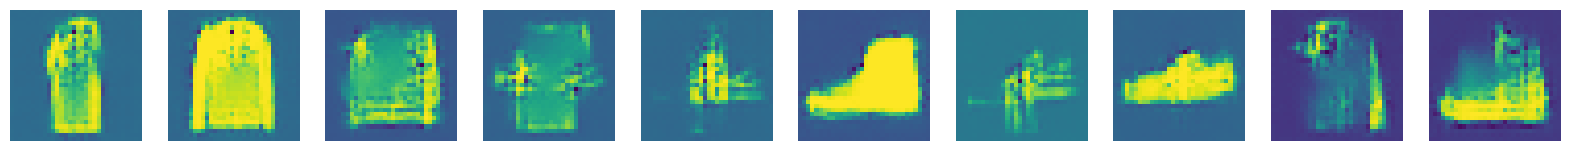

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6286 - d_real_acc: 0.6344 - d_fake_acc: 0.6289 - d_acc: 0.6317 - g_loss: 0.8819 - g_acc: 0.3711
Epoch 33/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6326 - d_real_acc: 0.6290 - d_fake_acc: 0.6261 - d_acc: 0.6275 - g_loss: 0.8798 - g_acc: 0.3739
Saved to ./output/output_dcgan/generated_img_032.png


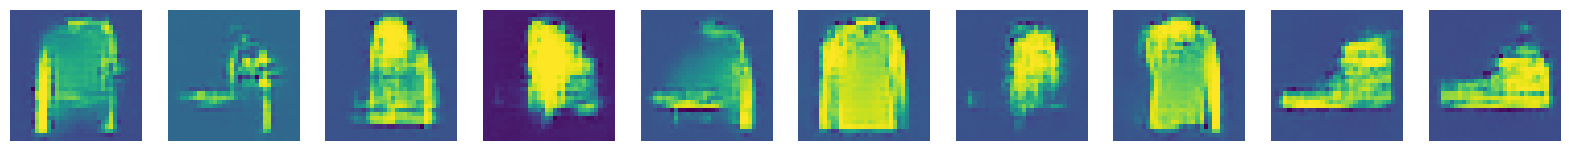

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6326 - d_real_acc: 0.6290 - d_fake_acc: 0.6261 - d_acc: 0.6275 - g_loss: 0.8798 - g_acc: 0.3739
Epoch 34/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6330 - d_real_acc: 0.6290 - d_fake_acc: 0.6273 - d_acc: 0.6281 - g_loss: 0.8785 - g_acc: 0.3727
Saved to ./output/output_dcgan/generated_img_033.png


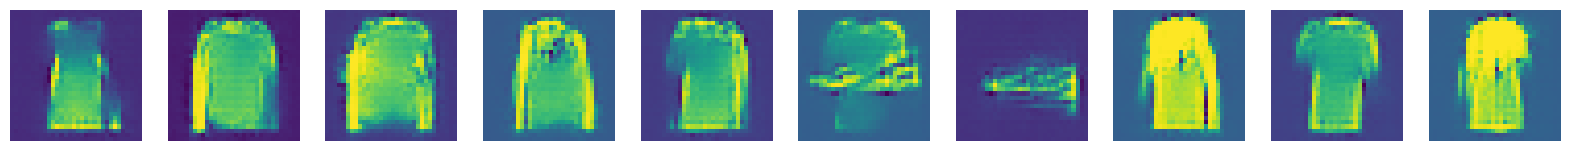

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6330 - d_real_acc: 0.6290 - d_fake_acc: 0.6273 - d_acc: 0.6281 - g_loss: 0.8785 - g_acc: 0.3727
Epoch 35/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6337 - d_real_acc: 0.6291 - d_fake_acc: 0.6239 - d_acc: 0.6265 - g_loss: 0.8751 - g_acc: 0.3761
Saved to ./output/output_dcgan/generated_img_034.png


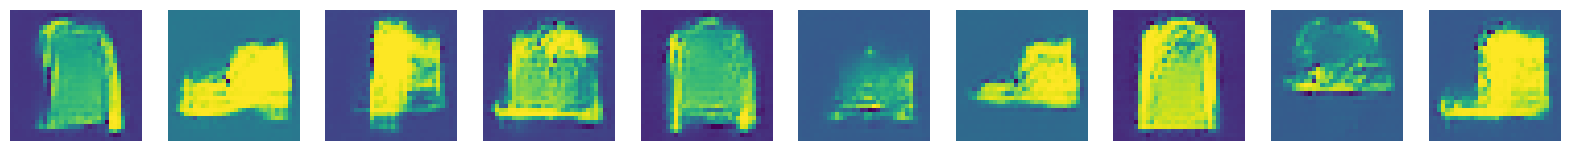

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6337 - d_real_acc: 0.6291 - d_fake_acc: 0.6239 - d_acc: 0.6265 - g_loss: 0.8751 - g_acc: 0.3761
Epoch 36/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6340 - d_real_acc: 0.6257 - d_fake_acc: 0.6276 - d_acc: 0.6266 - g_loss: 0.8777 - g_acc: 0.3724
Saved to ./output/output_dcgan/generated_img_035.png


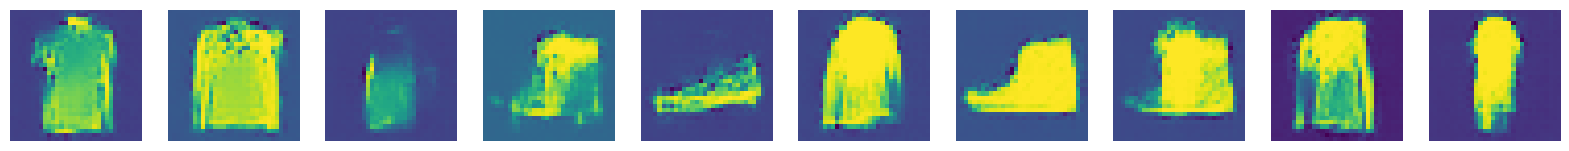

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6340 - d_real_acc: 0.6257 - d_fake_acc: 0.6276 - d_acc: 0.6266 - g_loss: 0.8777 - g_acc: 0.3724
Epoch 37/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6374 - d_real_acc: 0.6237 - d_fake_acc: 0.6215 - d_acc: 0.6226 - g_loss: 0.8701 - g_acc: 0.3785
Saved to ./output/output_dcgan/generated_img_036.png


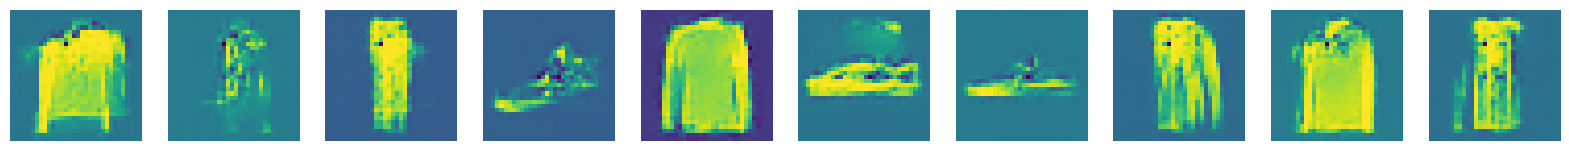

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6374 - d_real_acc: 0.6237 - d_fake_acc: 0.6215 - d_acc: 0.6226 - g_loss: 0.8701 - g_acc: 0.3785
Epoch 38/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6402 - d_real_acc: 0.6214 - d_fake_acc: 0.6191 - d_acc: 0.6202 - g_loss: 0.8638 - g_acc: 0.3809
Saved to ./output/output_dcgan/generated_img_037.png


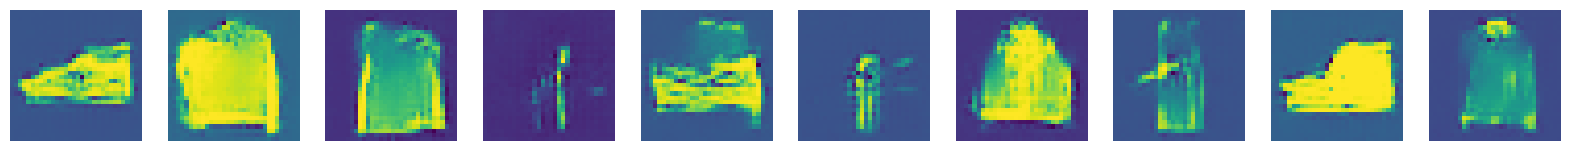

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6402 - d_real_acc: 0.6214 - d_fake_acc: 0.6191 - d_acc: 0.6202 - g_loss: 0.8638 - g_acc: 0.3809
Epoch 39/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6433 - d_real_acc: 0.6168 - d_fake_acc: 0.6152 - d_acc: 0.6160 - g_loss: 0.8591 - g_acc: 0.3848
Saved to ./output/output_dcgan/generated_img_038.png


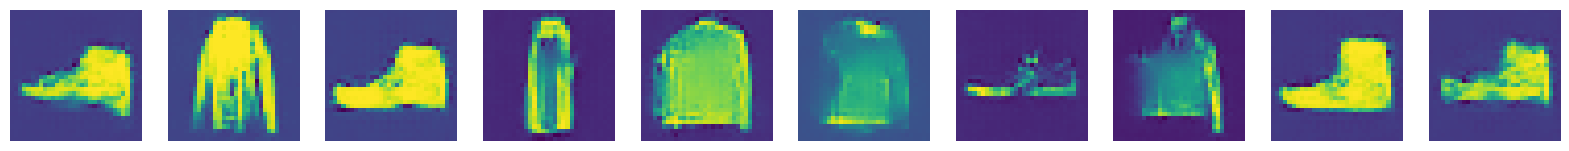

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6433 - d_real_acc: 0.6168 - d_fake_acc: 0.6152 - d_acc: 0.6160 - g_loss: 0.8591 - g_acc: 0.3848
Epoch 40/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6441 - d_real_acc: 0.6157 - d_fake_acc: 0.6150 - d_acc: 0.6154 - g_loss: 0.8535 - g_acc: 0.3850
Saved to ./output/output_dcgan/generated_img_039.png


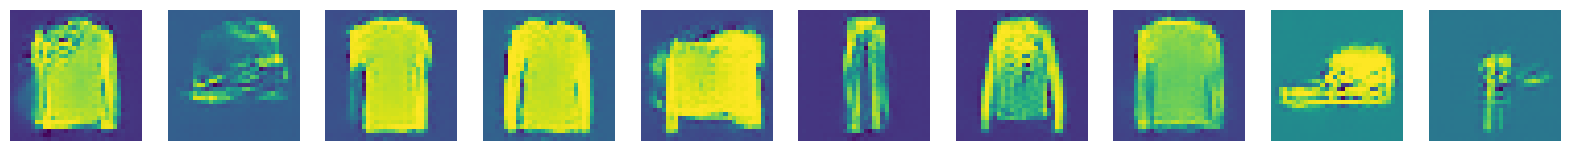

117/117 [==============================] - 9s 78ms/step - d_loss: 0.6441 - d_real_acc: 0.6157 - d_fake_acc: 0.6150 - d_acc: 0.6154 - g_loss: 0.8535 - g_acc: 0.3850
Epoch 41/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6462 - d_real_acc: 0.6141 - d_fake_acc: 0.6121 - d_acc: 0.6131 - g_loss: 0.8495 - g_acc: 0.3879
Saved to ./output/output_dcgan/generated_img_040.png


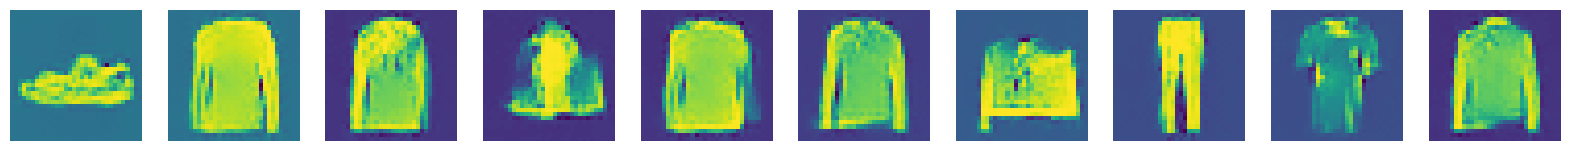

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6462 - d_real_acc: 0.6141 - d_fake_acc: 0.6121 - d_acc: 0.6131 - g_loss: 0.8495 - g_acc: 0.3879
Epoch 42/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6466 - d_real_acc: 0.6145 - d_fake_acc: 0.6114 - d_acc: 0.6129 - g_loss: 0.8443 - g_acc: 0.3886
Saved to ./output/output_dcgan/generated_img_041.png


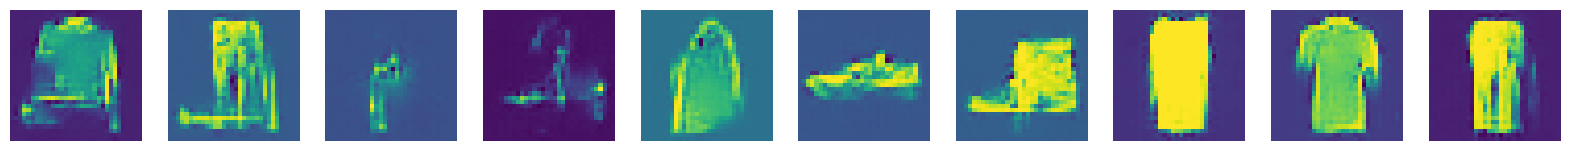

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6466 - d_real_acc: 0.6145 - d_fake_acc: 0.6114 - d_acc: 0.6129 - g_loss: 0.8443 - g_acc: 0.3886
Epoch 43/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6480 - d_real_acc: 0.6112 - d_fake_acc: 0.6107 - d_acc: 0.6110 - g_loss: 0.8411 - g_acc: 0.3893
Saved to ./output/output_dcgan/generated_img_042.png


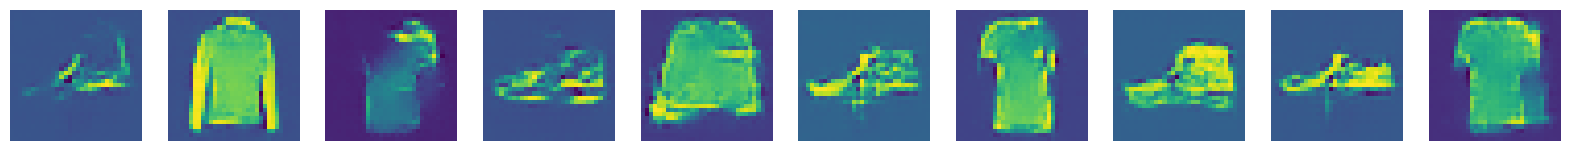

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6480 - d_real_acc: 0.6112 - d_fake_acc: 0.6107 - d_acc: 0.6110 - g_loss: 0.8411 - g_acc: 0.3893
Epoch 44/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6453 - d_real_acc: 0.6148 - d_fake_acc: 0.6103 - d_acc: 0.6126 - g_loss: 0.8421 - g_acc: 0.3897
Saved to ./output/output_dcgan/generated_img_043.png


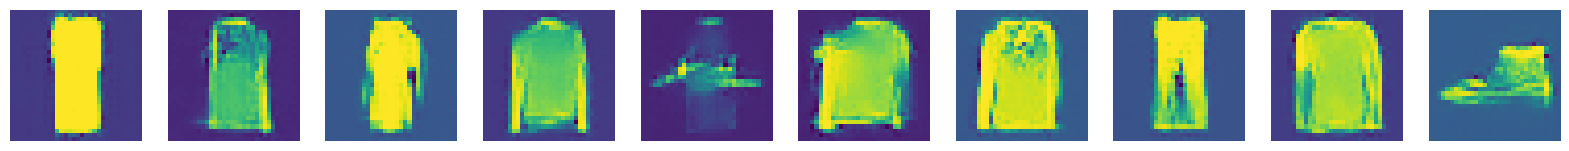

117/117 [==============================] - 9s 78ms/step - d_loss: 0.6453 - d_real_acc: 0.6148 - d_fake_acc: 0.6103 - d_acc: 0.6126 - g_loss: 0.8421 - g_acc: 0.3897
Epoch 45/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6453 - d_real_acc: 0.6153 - d_fake_acc: 0.6124 - d_acc: 0.6138 - g_loss: 0.8441 - g_acc: 0.3876
Saved to ./output/output_dcgan/generated_img_044.png


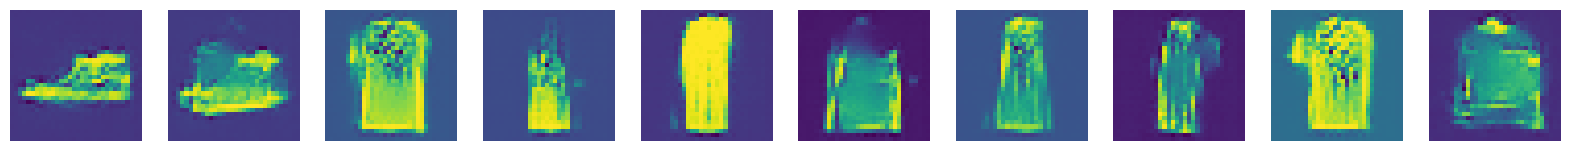

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6453 - d_real_acc: 0.6153 - d_fake_acc: 0.6124 - d_acc: 0.6138 - g_loss: 0.8441 - g_acc: 0.3876
Epoch 46/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6467 - d_real_acc: 0.6133 - d_fake_acc: 0.6104 - d_acc: 0.6119 - g_loss: 0.8446 - g_acc: 0.3896
Saved to ./output/output_dcgan/generated_img_045.png


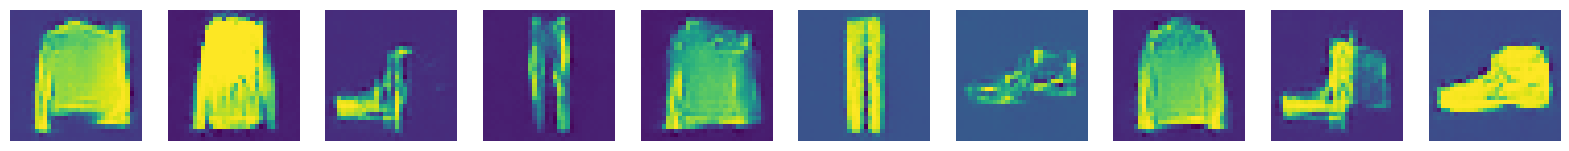

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6467 - d_real_acc: 0.6133 - d_fake_acc: 0.6104 - d_acc: 0.6119 - g_loss: 0.8446 - g_acc: 0.3896
Epoch 47/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6475 - d_real_acc: 0.6115 - d_fake_acc: 0.6083 - d_acc: 0.6099 - g_loss: 0.8400 - g_acc: 0.3917
Saved to ./output/output_dcgan/generated_img_046.png


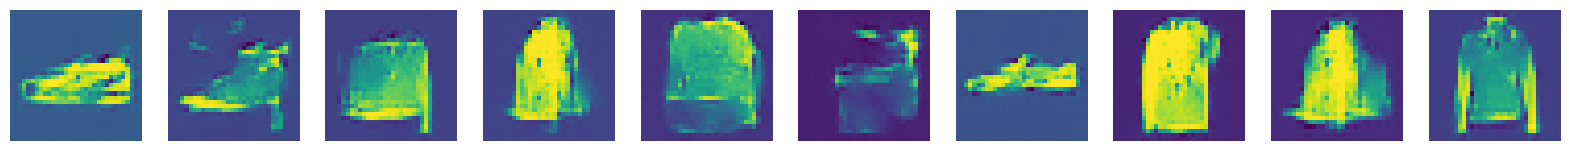

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6475 - d_real_acc: 0.6115 - d_fake_acc: 0.6083 - d_acc: 0.6099 - g_loss: 0.8400 - g_acc: 0.3917
Epoch 48/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6471 - d_real_acc: 0.6113 - d_fake_acc: 0.6123 - d_acc: 0.6118 - g_loss: 0.8424 - g_acc: 0.3877
Saved to ./output/output_dcgan/generated_img_047.png


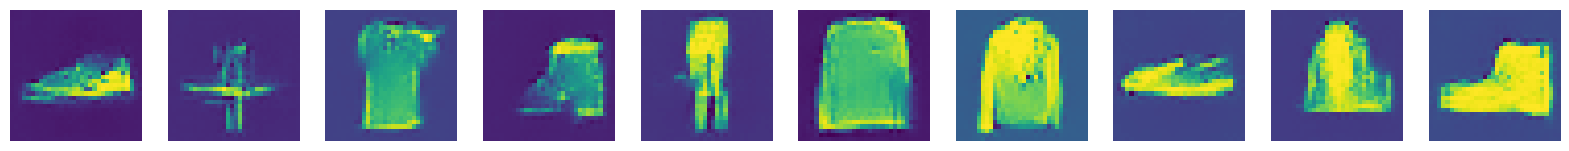

117/117 [==============================] - 9s 81ms/step - d_loss: 0.6471 - d_real_acc: 0.6113 - d_fake_acc: 0.6123 - d_acc: 0.6118 - g_loss: 0.8424 - g_acc: 0.3877
Epoch 49/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6486 - d_real_acc: 0.6111 - d_fake_acc: 0.6087 - d_acc: 0.6099 - g_loss: 0.8377 - g_acc: 0.3913
Saved to ./output/output_dcgan/generated_img_048.png


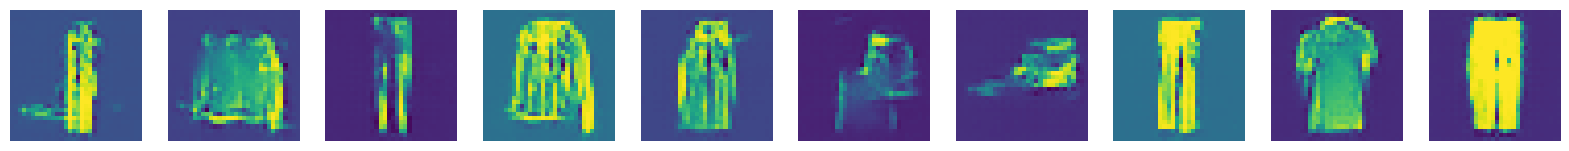

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6486 - d_real_acc: 0.6111 - d_fake_acc: 0.6087 - d_acc: 0.6099 - g_loss: 0.8377 - g_acc: 0.3913
Epoch 50/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6463 - d_real_acc: 0.6114 - d_fake_acc: 0.6157 - d_acc: 0.6135 - g_loss: 0.8409 - g_acc: 0.3843
Saved to ./output/output_dcgan/generated_img_049.png


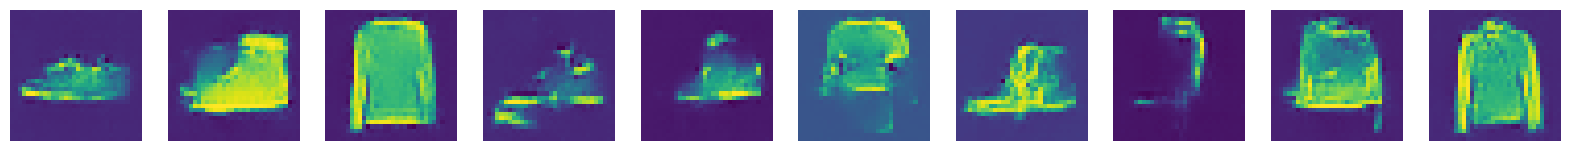

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6463 - d_real_acc: 0.6114 - d_fake_acc: 0.6157 - d_acc: 0.6135 - g_loss: 0.8409 - g_acc: 0.3843
Epoch 51/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6522 - d_real_acc: 0.6057 - d_fake_acc: 0.6031 - d_acc: 0.6044 - g_loss: 0.8293 - g_acc: 0.3969
Saved to ./output/output_dcgan/generated_img_050.png


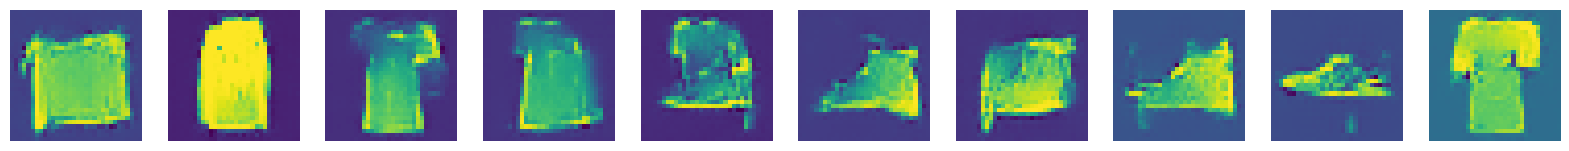

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6522 - d_real_acc: 0.6057 - d_fake_acc: 0.6031 - d_acc: 0.6044 - g_loss: 0.8293 - g_acc: 0.3969
Epoch 52/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6484 - d_real_acc: 0.6119 - d_fake_acc: 0.6099 - d_acc: 0.6109 - g_loss: 0.8339 - g_acc: 0.3901
Saved to ./output/output_dcgan/generated_img_051.png


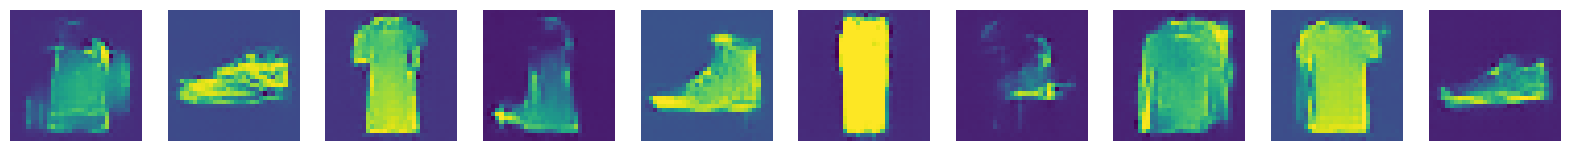

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6484 - d_real_acc: 0.6119 - d_fake_acc: 0.6099 - d_acc: 0.6109 - g_loss: 0.8339 - g_acc: 0.3901
Epoch 53/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6492 - d_real_acc: 0.6085 - d_fake_acc: 0.6095 - d_acc: 0.6090 - g_loss: 0.8342 - g_acc: 0.3905
Saved to ./output/output_dcgan/generated_img_052.png


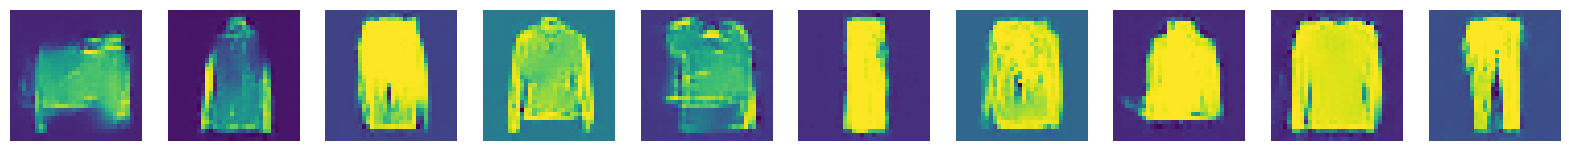

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6492 - d_real_acc: 0.6085 - d_fake_acc: 0.6095 - d_acc: 0.6090 - g_loss: 0.8342 - g_acc: 0.3905
Epoch 54/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6518 - d_real_acc: 0.6070 - d_fake_acc: 0.6052 - d_acc: 0.6061 - g_loss: 0.8289 - g_acc: 0.3948
Saved to ./output/output_dcgan/generated_img_053.png


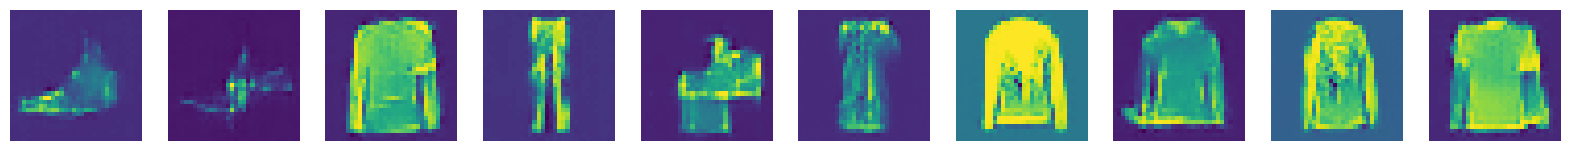

117/117 [==============================] - 9s 81ms/step - d_loss: 0.6518 - d_real_acc: 0.6070 - d_fake_acc: 0.6052 - d_acc: 0.6061 - g_loss: 0.8289 - g_acc: 0.3948
Epoch 55/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6522 - d_real_acc: 0.6064 - d_fake_acc: 0.6049 - d_acc: 0.6057 - g_loss: 0.8284 - g_acc: 0.3951
Saved to ./output/output_dcgan/generated_img_054.png


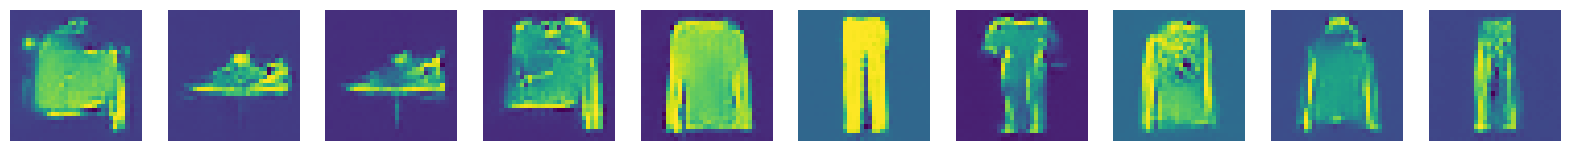

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6522 - d_real_acc: 0.6064 - d_fake_acc: 0.6049 - d_acc: 0.6057 - g_loss: 0.8284 - g_acc: 0.3951
Epoch 56/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6515 - d_real_acc: 0.6034 - d_fake_acc: 0.6067 - d_acc: 0.6051 - g_loss: 0.8264 - g_acc: 0.3933
Saved to ./output/output_dcgan/generated_img_055.png


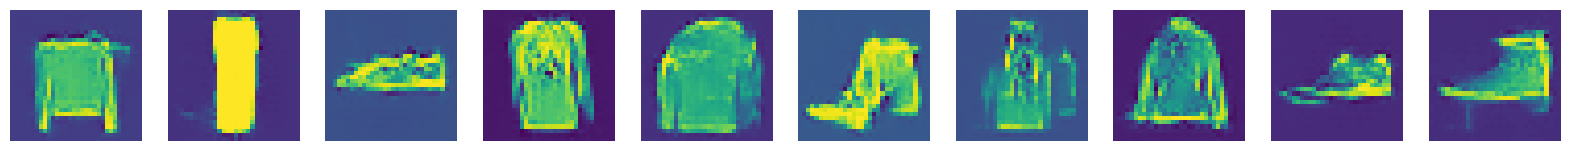

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6515 - d_real_acc: 0.6034 - d_fake_acc: 0.6067 - d_acc: 0.6051 - g_loss: 0.8264 - g_acc: 0.3933
Epoch 57/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6533 - d_real_acc: 0.6005 - d_fake_acc: 0.6030 - d_acc: 0.6018 - g_loss: 0.8270 - g_acc: 0.3970
Saved to ./output/output_dcgan/generated_img_056.png


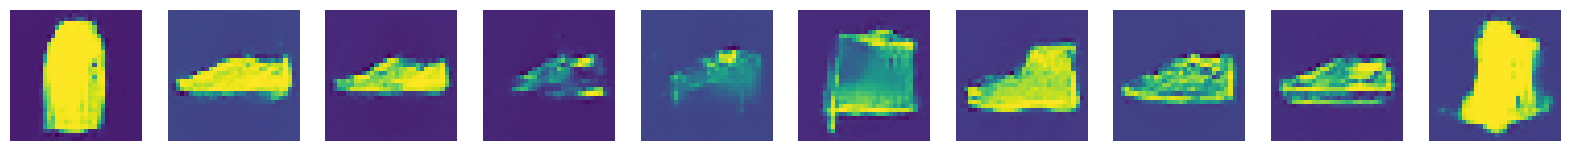

117/117 [==============================] - 9s 81ms/step - d_loss: 0.6533 - d_real_acc: 0.6005 - d_fake_acc: 0.6030 - d_acc: 0.6018 - g_loss: 0.8270 - g_acc: 0.3970
Epoch 58/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6571 - d_real_acc: 0.6014 - d_fake_acc: 0.5988 - d_acc: 0.6001 - g_loss: 0.8182 - g_acc: 0.4012
Saved to ./output/output_dcgan/generated_img_057.png


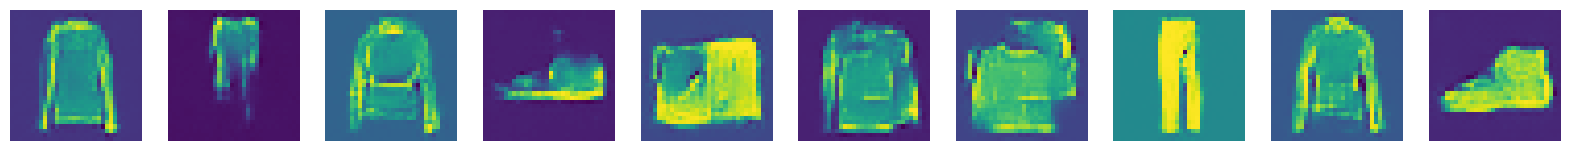

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6571 - d_real_acc: 0.6014 - d_fake_acc: 0.5988 - d_acc: 0.6001 - g_loss: 0.8182 - g_acc: 0.4012
Epoch 59/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6544 - d_real_acc: 0.6023 - d_fake_acc: 0.6013 - d_acc: 0.6018 - g_loss: 0.8199 - g_acc: 0.3987
Saved to ./output/output_dcgan/generated_img_058.png


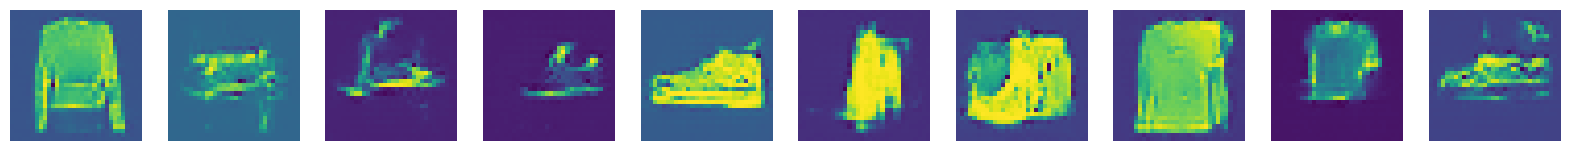

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6544 - d_real_acc: 0.6023 - d_fake_acc: 0.6013 - d_acc: 0.6018 - g_loss: 0.8199 - g_acc: 0.3987
Epoch 60/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6550 - d_real_acc: 0.6017 - d_fake_acc: 0.6033 - d_acc: 0.6025 - g_loss: 0.8185 - g_acc: 0.3967
Saved to ./output/output_dcgan/generated_img_059.png


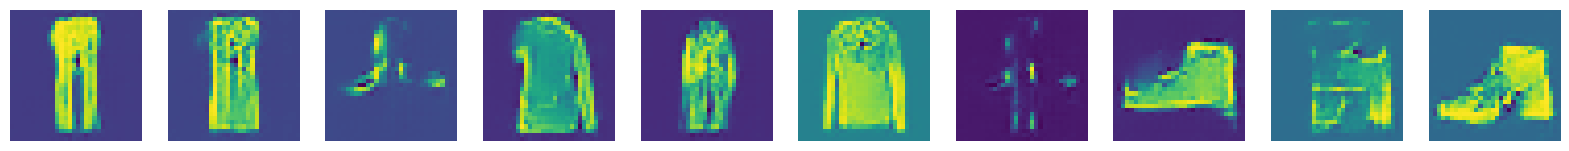

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6550 - d_real_acc: 0.6017 - d_fake_acc: 0.6033 - d_acc: 0.6025 - g_loss: 0.8185 - g_acc: 0.3967
Epoch 61/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6535 - d_real_acc: 0.6060 - d_fake_acc: 0.6011 - d_acc: 0.6036 - g_loss: 0.8199 - g_acc: 0.3989
Saved to ./output/output_dcgan/generated_img_060.png


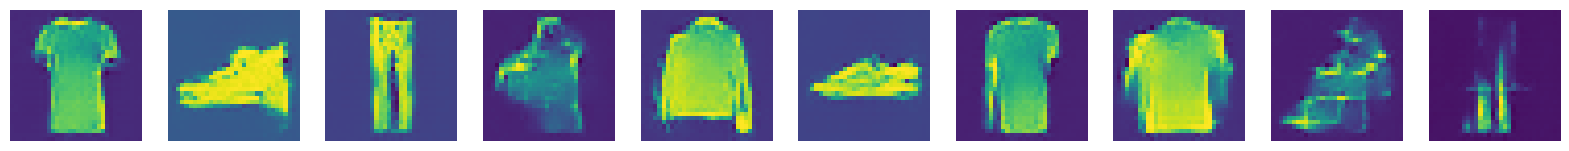

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6535 - d_real_acc: 0.6060 - d_fake_acc: 0.6011 - d_acc: 0.6036 - g_loss: 0.8199 - g_acc: 0.3989
Epoch 62/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6560 - d_real_acc: 0.5988 - d_fake_acc: 0.5999 - d_acc: 0.5994 - g_loss: 0.8151 - g_acc: 0.4001
Saved to ./output/output_dcgan/generated_img_061.png


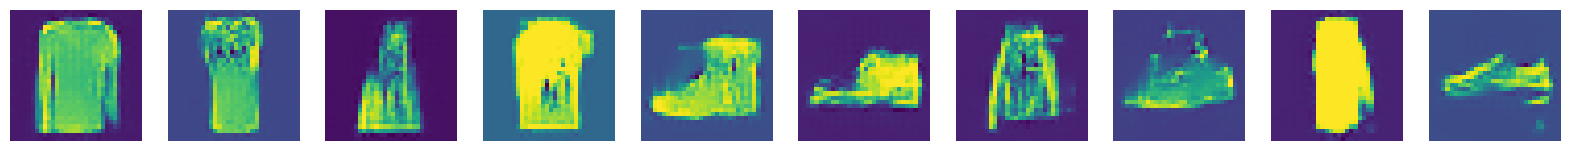

117/117 [==============================] - 10s 84ms/step - d_loss: 0.6560 - d_real_acc: 0.5988 - d_fake_acc: 0.5999 - d_acc: 0.5994 - g_loss: 0.8151 - g_acc: 0.4001
Epoch 63/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6576 - d_real_acc: 0.6010 - d_fake_acc: 0.5976 - d_acc: 0.5993 - g_loss: 0.8121 - g_acc: 0.4024
Saved to ./output/output_dcgan/generated_img_062.png


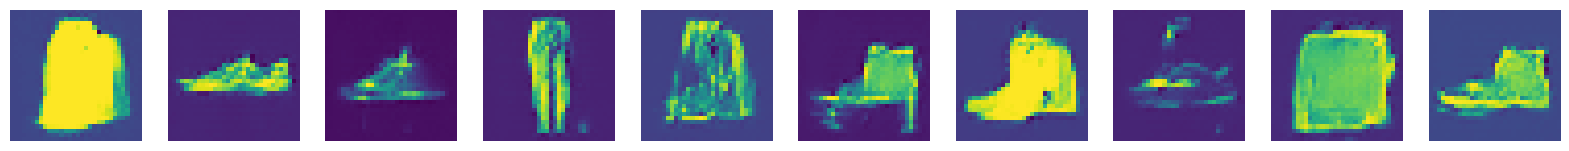

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6576 - d_real_acc: 0.6010 - d_fake_acc: 0.5976 - d_acc: 0.5993 - g_loss: 0.8121 - g_acc: 0.4024
Epoch 64/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6578 - d_real_acc: 0.5975 - d_fake_acc: 0.5991 - d_acc: 0.5983 - g_loss: 0.8114 - g_acc: 0.4009
Saved to ./output/output_dcgan/generated_img_063.png


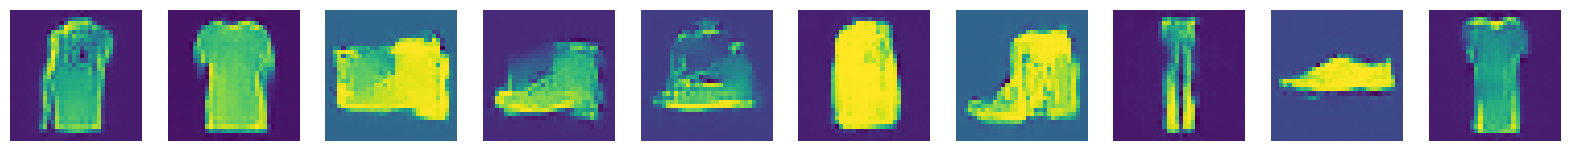

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6578 - d_real_acc: 0.5975 - d_fake_acc: 0.5991 - d_acc: 0.5983 - g_loss: 0.8114 - g_acc: 0.4009
Epoch 65/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6582 - d_real_acc: 0.5987 - d_fake_acc: 0.5955 - d_acc: 0.5971 - g_loss: 0.8092 - g_acc: 0.4045
Saved to ./output/output_dcgan/generated_img_064.png


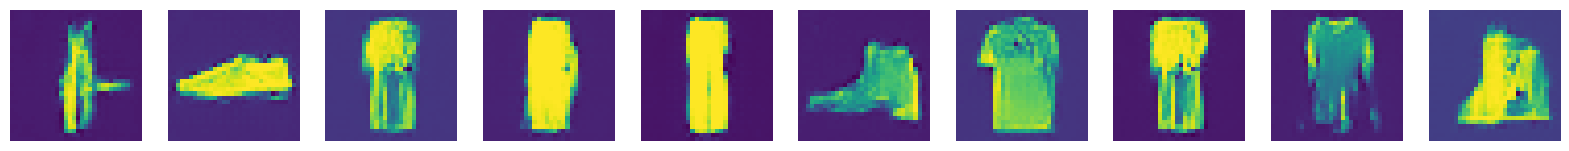

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6582 - d_real_acc: 0.5987 - d_fake_acc: 0.5955 - d_acc: 0.5971 - g_loss: 0.8092 - g_acc: 0.4045
Epoch 66/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6569 - d_real_acc: 0.5980 - d_fake_acc: 0.5983 - d_acc: 0.5981 - g_loss: 0.8097 - g_acc: 0.4017
Saved to ./output/output_dcgan/generated_img_065.png


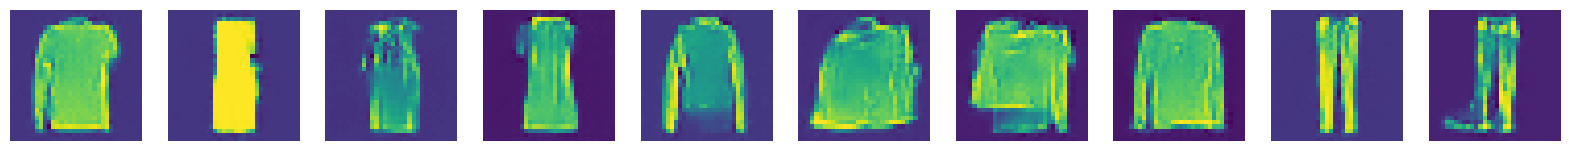

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6569 - d_real_acc: 0.5980 - d_fake_acc: 0.5983 - d_acc: 0.5981 - g_loss: 0.8097 - g_acc: 0.4017
Epoch 67/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6589 - d_real_acc: 0.5951 - d_fake_acc: 0.5955 - d_acc: 0.5953 - g_loss: 0.8071 - g_acc: 0.4045
Saved to ./output/output_dcgan/generated_img_066.png


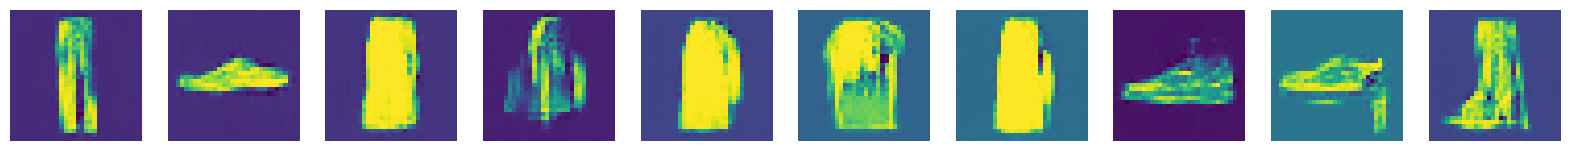

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6589 - d_real_acc: 0.5951 - d_fake_acc: 0.5955 - d_acc: 0.5953 - g_loss: 0.8071 - g_acc: 0.4045
Epoch 68/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6621 - d_real_acc: 0.5914 - d_fake_acc: 0.5921 - d_acc: 0.5918 - g_loss: 0.8027 - g_acc: 0.4079
Saved to ./output/output_dcgan/generated_img_067.png


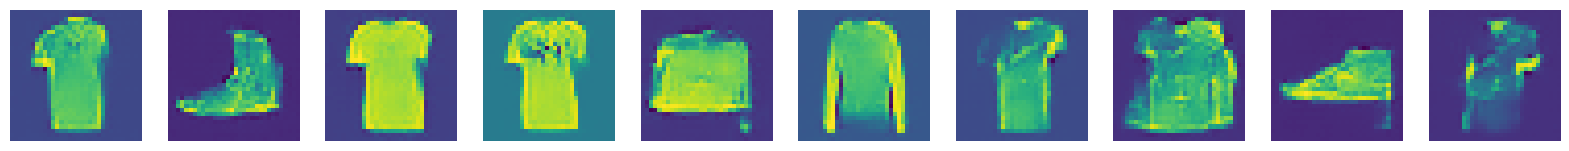

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6621 - d_real_acc: 0.5914 - d_fake_acc: 0.5921 - d_acc: 0.5918 - g_loss: 0.8027 - g_acc: 0.4079
Epoch 69/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6622 - d_real_acc: 0.5895 - d_fake_acc: 0.5931 - d_acc: 0.5913 - g_loss: 0.7995 - g_acc: 0.4069
Saved to ./output/output_dcgan/generated_img_068.png


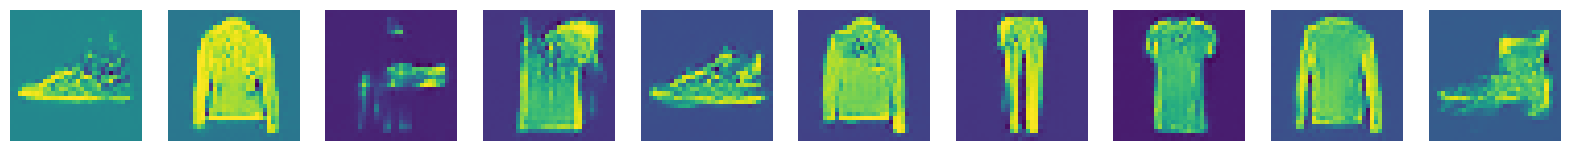

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6622 - d_real_acc: 0.5895 - d_fake_acc: 0.5931 - d_acc: 0.5913 - g_loss: 0.7995 - g_acc: 0.4069
Epoch 70/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6583 - d_real_acc: 0.6012 - d_fake_acc: 0.5914 - d_acc: 0.5963 - g_loss: 0.8014 - g_acc: 0.4086
Saved to ./output/output_dcgan/generated_img_069.png


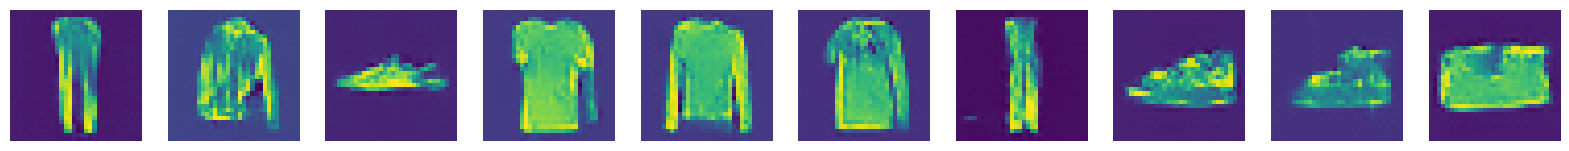

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6583 - d_real_acc: 0.6012 - d_fake_acc: 0.5914 - d_acc: 0.5963 - g_loss: 0.8014 - g_acc: 0.4086
Epoch 71/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6601 - d_real_acc: 0.5931 - d_fake_acc: 0.5961 - d_acc: 0.5946 - g_loss: 0.8018 - g_acc: 0.4039
Saved to ./output/output_dcgan/generated_img_070.png


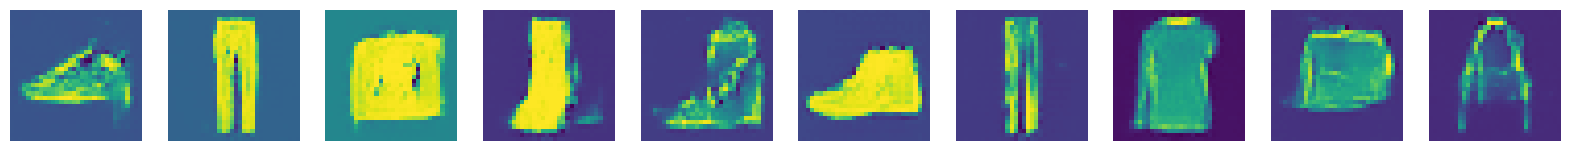

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6601 - d_real_acc: 0.5931 - d_fake_acc: 0.5961 - d_acc: 0.5946 - g_loss: 0.8018 - g_acc: 0.4039
Epoch 72/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6621 - d_real_acc: 0.5939 - d_fake_acc: 0.5907 - d_acc: 0.5923 - g_loss: 0.7981 - g_acc: 0.4093
Saved to ./output/output_dcgan/generated_img_071.png


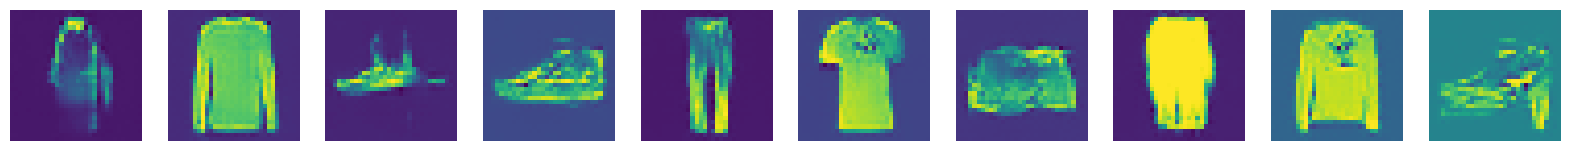

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6621 - d_real_acc: 0.5939 - d_fake_acc: 0.5907 - d_acc: 0.5923 - g_loss: 0.7981 - g_acc: 0.4093
Epoch 73/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6618 - d_real_acc: 0.5929 - d_fake_acc: 0.5923 - d_acc: 0.5926 - g_loss: 0.8002 - g_acc: 0.4077
Saved to ./output/output_dcgan/generated_img_072.png


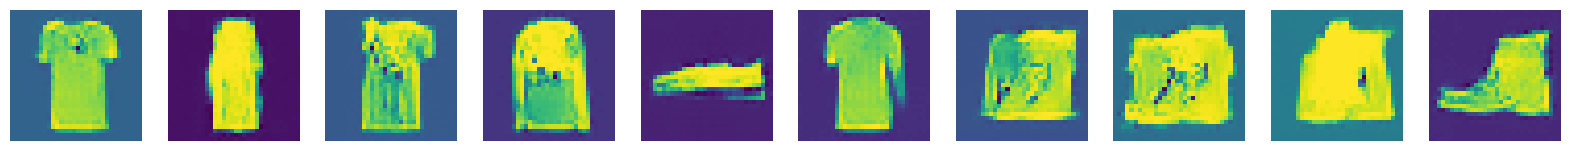

117/117 [==============================] - 9s 78ms/step - d_loss: 0.6618 - d_real_acc: 0.5929 - d_fake_acc: 0.5923 - d_acc: 0.5926 - g_loss: 0.8002 - g_acc: 0.4077
Epoch 74/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6613 - d_real_acc: 0.5916 - d_fake_acc: 0.5949 - d_acc: 0.5933 - g_loss: 0.7989 - g_acc: 0.4051
Saved to ./output/output_dcgan/generated_img_073.png


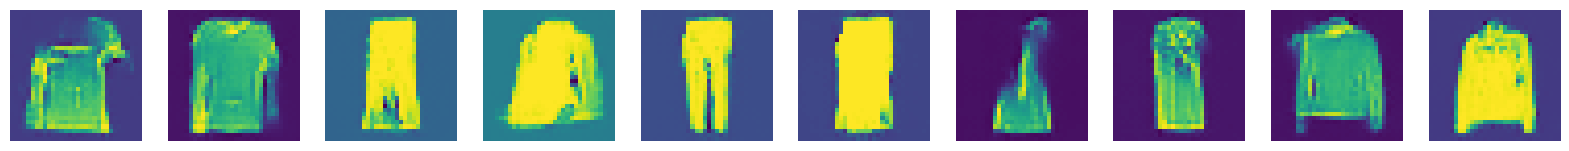

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6613 - d_real_acc: 0.5916 - d_fake_acc: 0.5949 - d_acc: 0.5933 - g_loss: 0.7989 - g_acc: 0.4051
Epoch 75/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6632 - d_real_acc: 0.5891 - d_fake_acc: 0.5926 - d_acc: 0.5909 - g_loss: 0.7990 - g_acc: 0.4074
Saved to ./output/output_dcgan/generated_img_074.png


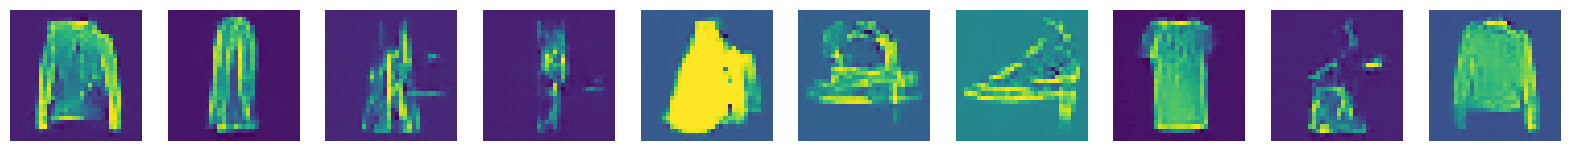

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6632 - d_real_acc: 0.5891 - d_fake_acc: 0.5926 - d_acc: 0.5909 - g_loss: 0.7990 - g_acc: 0.4074
Epoch 76/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6621 - d_real_acc: 0.5894 - d_fake_acc: 0.5959 - d_acc: 0.5927 - g_loss: 0.7972 - g_acc: 0.4041
Saved to ./output/output_dcgan/generated_img_075.png


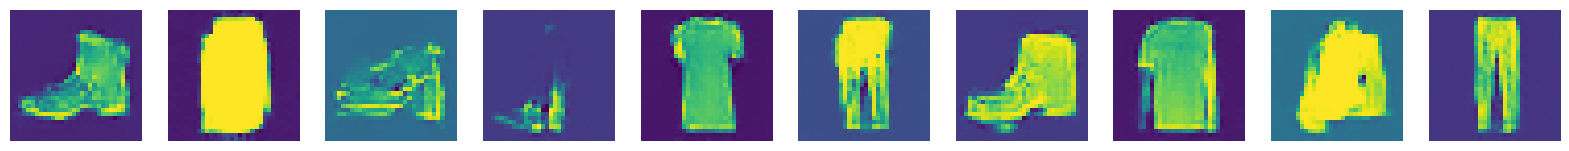

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6621 - d_real_acc: 0.5894 - d_fake_acc: 0.5959 - d_acc: 0.5927 - g_loss: 0.7972 - g_acc: 0.4041
Epoch 77/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6645 - d_real_acc: 0.5861 - d_fake_acc: 0.5878 - d_acc: 0.5869 - g_loss: 0.7913 - g_acc: 0.4122
Saved to ./output/output_dcgan/generated_img_076.png


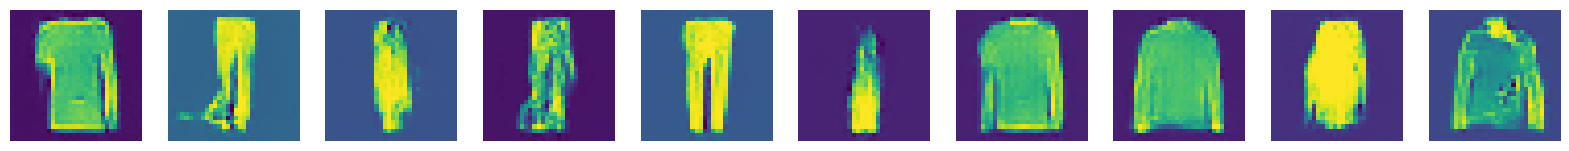

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6645 - d_real_acc: 0.5861 - d_fake_acc: 0.5878 - d_acc: 0.5869 - g_loss: 0.7913 - g_acc: 0.4122
Epoch 78/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6638 - d_real_acc: 0.5861 - d_fake_acc: 0.5900 - d_acc: 0.5881 - g_loss: 0.7925 - g_acc: 0.4100
Saved to ./output/output_dcgan/generated_img_077.png


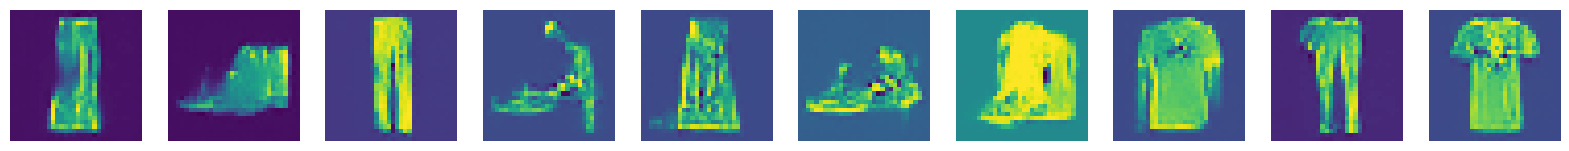

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6638 - d_real_acc: 0.5861 - d_fake_acc: 0.5900 - d_acc: 0.5881 - g_loss: 0.7925 - g_acc: 0.4100
Epoch 79/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6595 - d_real_acc: 0.5968 - d_fake_acc: 0.5953 - d_acc: 0.5961 - g_loss: 0.7973 - g_acc: 0.4047
Saved to ./output/output_dcgan/generated_img_078.png


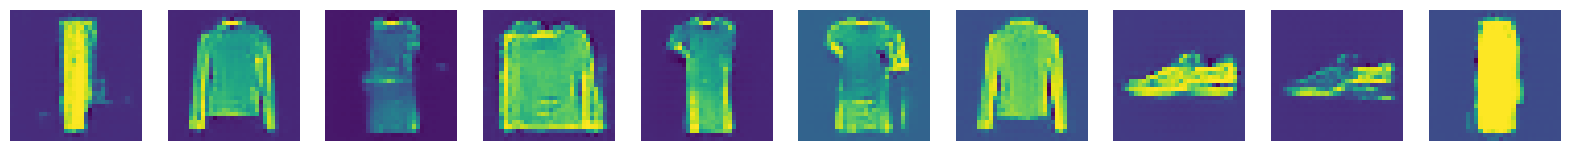

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6595 - d_real_acc: 0.5968 - d_fake_acc: 0.5953 - d_acc: 0.5961 - g_loss: 0.7973 - g_acc: 0.4047
Epoch 80/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6535 - d_real_acc: 0.6024 - d_fake_acc: 0.6019 - d_acc: 0.6021 - g_loss: 0.8095 - g_acc: 0.3981
Saved to ./output/output_dcgan/generated_img_079.png


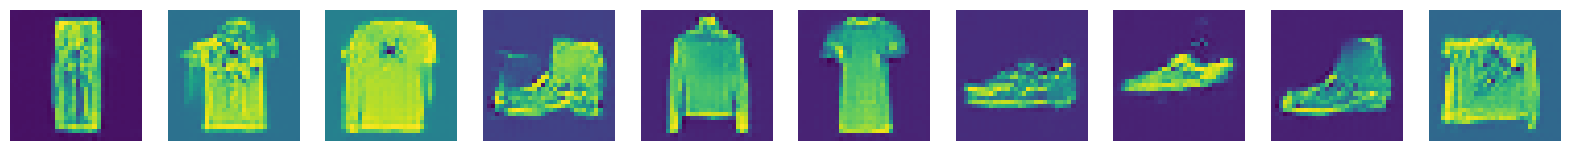

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6535 - d_real_acc: 0.6024 - d_fake_acc: 0.6019 - d_acc: 0.6021 - g_loss: 0.8095 - g_acc: 0.3981
Epoch 81/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6636 - d_real_acc: 0.5891 - d_fake_acc: 0.5892 - d_acc: 0.5892 - g_loss: 0.7971 - g_acc: 0.4108
Saved to ./output/output_dcgan/generated_img_080.png


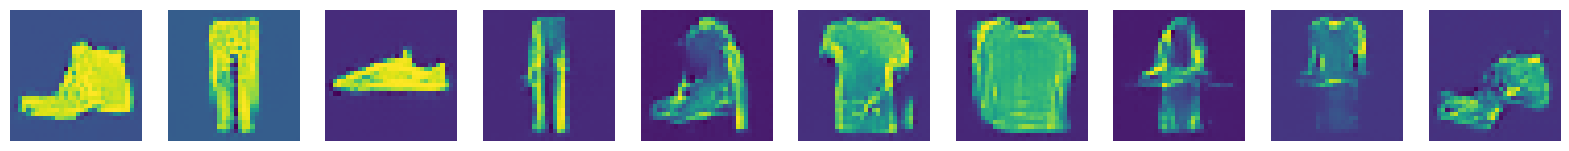

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6636 - d_real_acc: 0.5891 - d_fake_acc: 0.5892 - d_acc: 0.5892 - g_loss: 0.7971 - g_acc: 0.4108
Epoch 82/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6649 - d_real_acc: 0.5869 - d_fake_acc: 0.5881 - d_acc: 0.5875 - g_loss: 0.7929 - g_acc: 0.4119
Saved to ./output/output_dcgan/generated_img_081.png


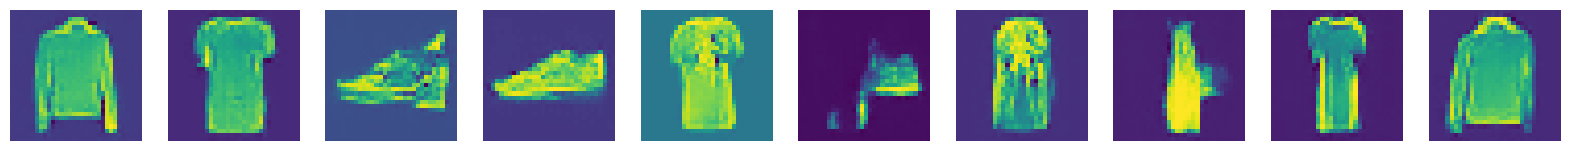

117/117 [==============================] - 10s 84ms/step - d_loss: 0.6649 - d_real_acc: 0.5869 - d_fake_acc: 0.5881 - d_acc: 0.5875 - g_loss: 0.7929 - g_acc: 0.4119
Epoch 83/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6637 - d_real_acc: 0.5863 - d_fake_acc: 0.5926 - d_acc: 0.5895 - g_loss: 0.7939 - g_acc: 0.4074
Saved to ./output/output_dcgan/generated_img_082.png


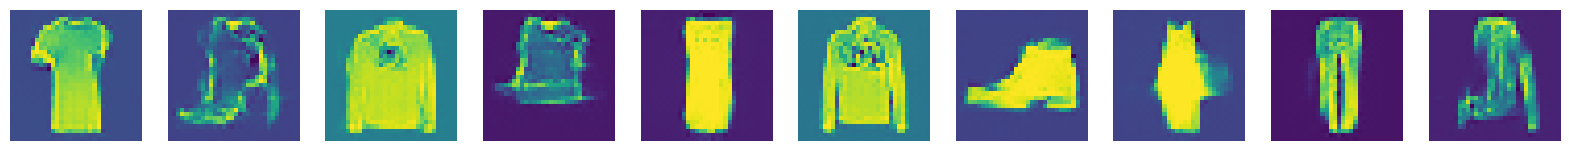

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6637 - d_real_acc: 0.5863 - d_fake_acc: 0.5926 - d_acc: 0.5895 - g_loss: 0.7939 - g_acc: 0.4074
Epoch 84/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6646 - d_real_acc: 0.5813 - d_fake_acc: 0.5919 - d_acc: 0.5866 - g_loss: 0.7909 - g_acc: 0.4081
Saved to ./output/output_dcgan/generated_img_083.png


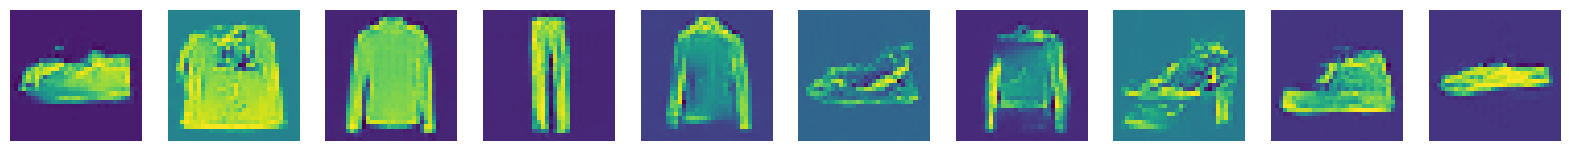

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6646 - d_real_acc: 0.5813 - d_fake_acc: 0.5919 - d_acc: 0.5866 - g_loss: 0.7909 - g_acc: 0.4081
Epoch 85/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6664 - d_real_acc: 0.5851 - d_fake_acc: 0.5885 - d_acc: 0.5868 - g_loss: 0.7877 - g_acc: 0.4115
Saved to ./output/output_dcgan/generated_img_084.png


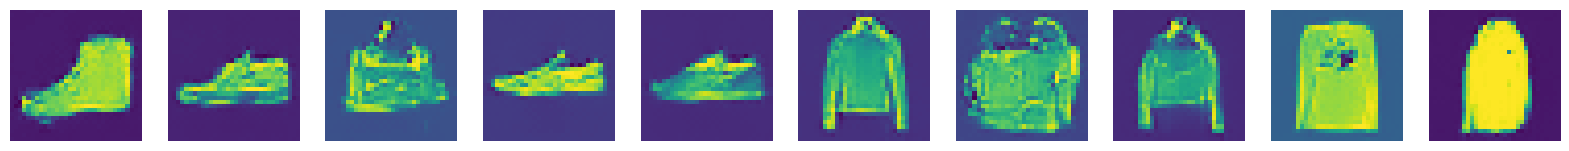

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6664 - d_real_acc: 0.5851 - d_fake_acc: 0.5885 - d_acc: 0.5868 - g_loss: 0.7877 - g_acc: 0.4115
Epoch 86/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6637 - d_real_acc: 0.5858 - d_fake_acc: 0.5910 - d_acc: 0.5884 - g_loss: 0.7896 - g_acc: 0.4090
Saved to ./output/output_dcgan/generated_img_085.png


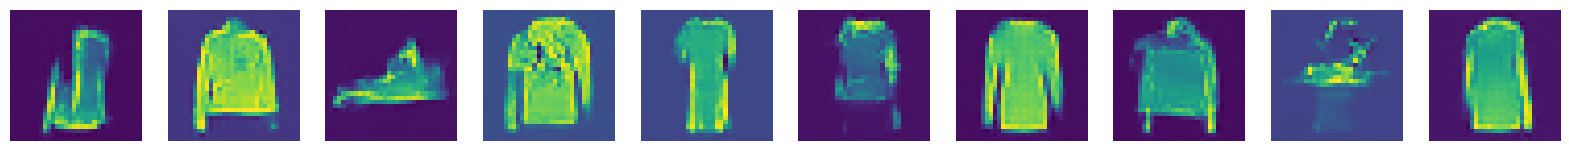

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6637 - d_real_acc: 0.5858 - d_fake_acc: 0.5910 - d_acc: 0.5884 - g_loss: 0.7896 - g_acc: 0.4090
Epoch 87/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6646 - d_real_acc: 0.5847 - d_fake_acc: 0.5916 - d_acc: 0.5882 - g_loss: 0.7910 - g_acc: 0.4084
Saved to ./output/output_dcgan/generated_img_086.png


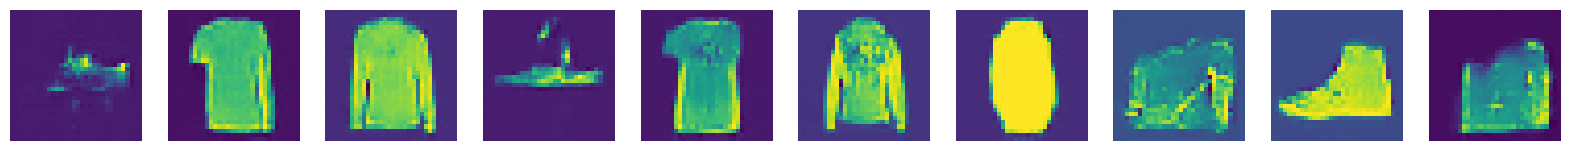

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6646 - d_real_acc: 0.5847 - d_fake_acc: 0.5916 - d_acc: 0.5882 - g_loss: 0.7910 - g_acc: 0.4084
Epoch 88/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6653 - d_real_acc: 0.5800 - d_fake_acc: 0.5924 - d_acc: 0.5862 - g_loss: 0.7904 - g_acc: 0.4076
Saved to ./output/output_dcgan/generated_img_087.png


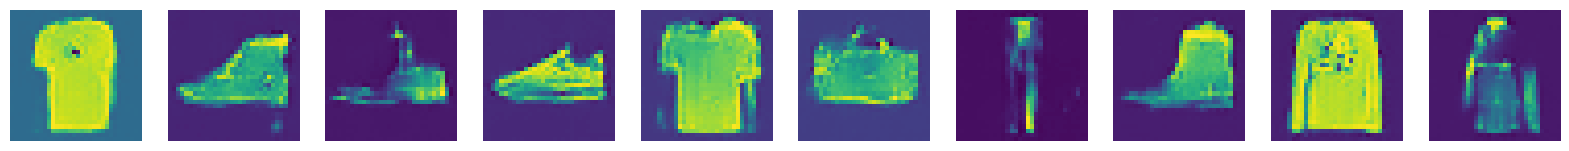

117/117 [==============================] - 10s 83ms/step - d_loss: 0.6653 - d_real_acc: 0.5800 - d_fake_acc: 0.5924 - d_acc: 0.5862 - g_loss: 0.7904 - g_acc: 0.4076
Epoch 89/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6643 - d_real_acc: 0.5844 - d_fake_acc: 0.5904 - d_acc: 0.5874 - g_loss: 0.7880 - g_acc: 0.4096
Saved to ./output/output_dcgan/generated_img_088.png


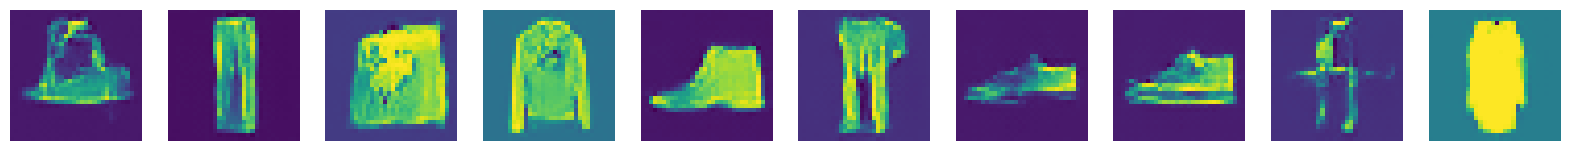

117/117 [==============================] - 10s 84ms/step - d_loss: 0.6643 - d_real_acc: 0.5844 - d_fake_acc: 0.5904 - d_acc: 0.5874 - g_loss: 0.7880 - g_acc: 0.4096
Epoch 90/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6655 - d_real_acc: 0.5861 - d_fake_acc: 0.5884 - d_acc: 0.5872 - g_loss: 0.7867 - g_acc: 0.4116
Saved to ./output/output_dcgan/generated_img_089.png


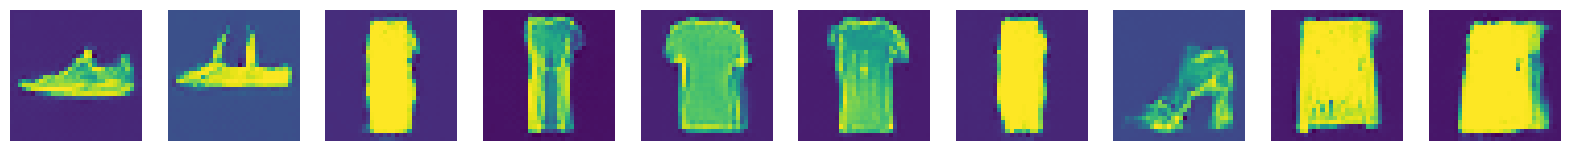

117/117 [==============================] - 9s 78ms/step - d_loss: 0.6655 - d_real_acc: 0.5861 - d_fake_acc: 0.5884 - d_acc: 0.5872 - g_loss: 0.7867 - g_acc: 0.4116
Epoch 91/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6625 - d_real_acc: 0.5883 - d_fake_acc: 0.5924 - d_acc: 0.5904 - g_loss: 0.7906 - g_acc: 0.4076
Saved to ./output/output_dcgan/generated_img_090.png


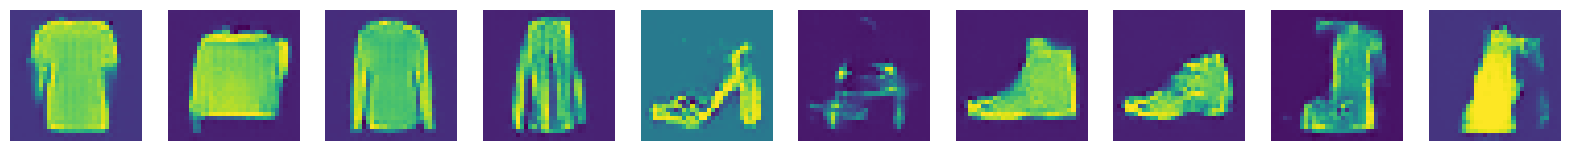

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6625 - d_real_acc: 0.5883 - d_fake_acc: 0.5924 - d_acc: 0.5904 - g_loss: 0.7906 - g_acc: 0.4076
Epoch 92/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6631 - d_real_acc: 0.5887 - d_fake_acc: 0.5896 - d_acc: 0.5891 - g_loss: 0.7890 - g_acc: 0.4104
Saved to ./output/output_dcgan/generated_img_091.png


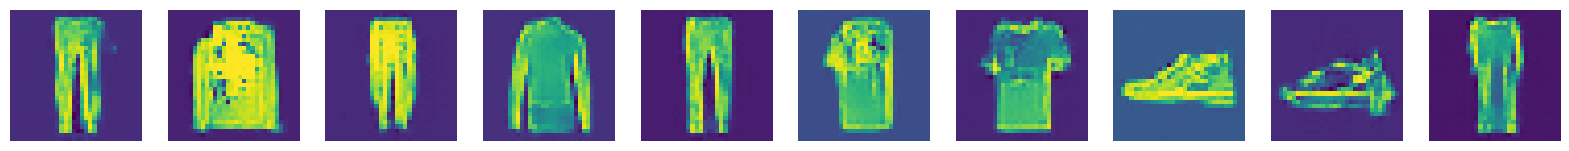

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6631 - d_real_acc: 0.5887 - d_fake_acc: 0.5896 - d_acc: 0.5891 - g_loss: 0.7890 - g_acc: 0.4104
Epoch 93/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6632 - d_real_acc: 0.5854 - d_fake_acc: 0.5946 - d_acc: 0.5900 - g_loss: 0.7923 - g_acc: 0.4054
Saved to ./output/output_dcgan/generated_img_092.png


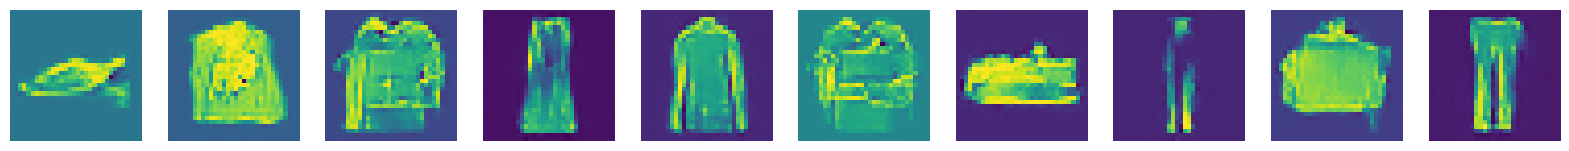

117/117 [==============================] - 9s 79ms/step - d_loss: 0.6632 - d_real_acc: 0.5854 - d_fake_acc: 0.5946 - d_acc: 0.5900 - g_loss: 0.7923 - g_acc: 0.4054
Epoch 94/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6635 - d_real_acc: 0.5878 - d_fake_acc: 0.5880 - d_acc: 0.5879 - g_loss: 0.7902 - g_acc: 0.4120
Saved to ./output/output_dcgan/generated_img_093.png


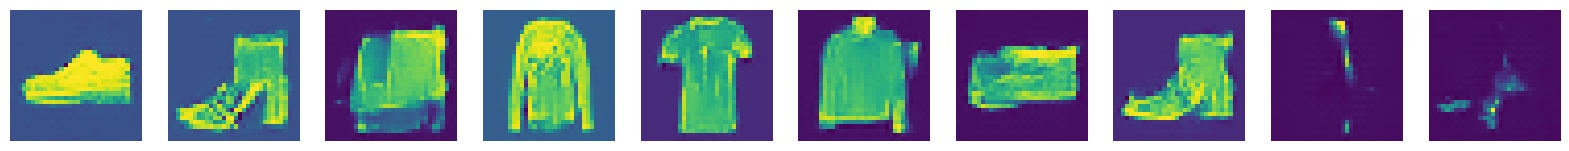

117/117 [==============================] - 9s 81ms/step - d_loss: 0.6635 - d_real_acc: 0.5878 - d_fake_acc: 0.5880 - d_acc: 0.5879 - g_loss: 0.7902 - g_acc: 0.4120
Epoch 95/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6637 - d_real_acc: 0.5831 - d_fake_acc: 0.5939 - d_acc: 0.5885 - g_loss: 0.7897 - g_acc: 0.4061
Saved to ./output/output_dcgan/generated_img_094.png


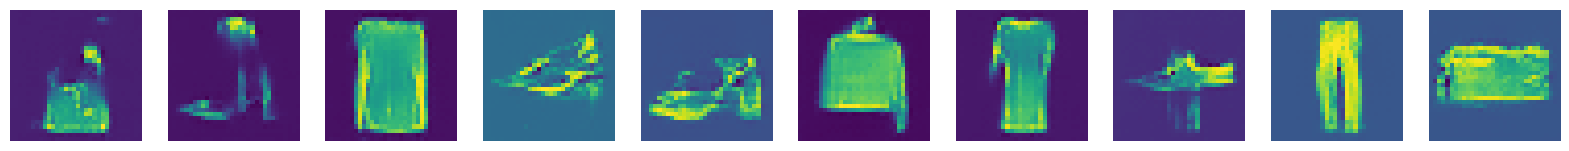

117/117 [==============================] - 10s 84ms/step - d_loss: 0.6637 - d_real_acc: 0.5831 - d_fake_acc: 0.5939 - d_acc: 0.5885 - g_loss: 0.7897 - g_acc: 0.4061
Epoch 96/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6645 - d_real_acc: 0.5873 - d_fake_acc: 0.5895 - d_acc: 0.5884 - g_loss: 0.7878 - g_acc: 0.4105
Saved to ./output/output_dcgan/generated_img_095.png


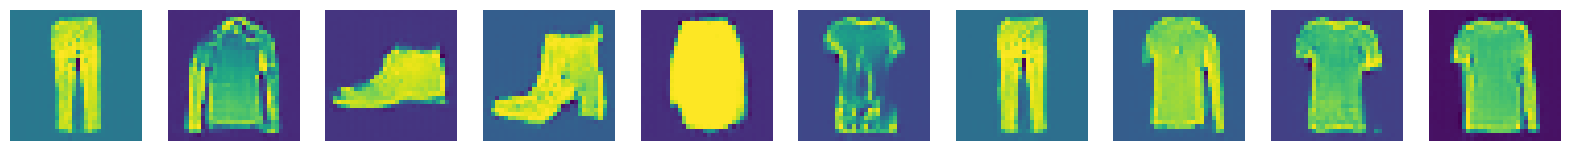

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6645 - d_real_acc: 0.5873 - d_fake_acc: 0.5895 - d_acc: 0.5884 - g_loss: 0.7878 - g_acc: 0.4105
Epoch 97/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6654 - d_real_acc: 0.5857 - d_fake_acc: 0.5912 - d_acc: 0.5884 - g_loss: 0.7887 - g_acc: 0.4088
Saved to ./output/output_dcgan/generated_img_096.png


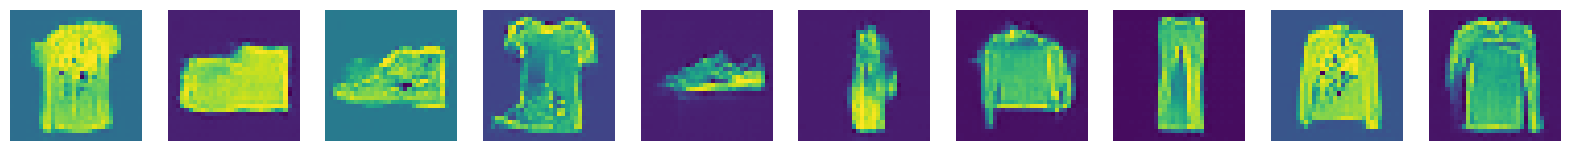

117/117 [==============================] - 9s 81ms/step - d_loss: 0.6654 - d_real_acc: 0.5857 - d_fake_acc: 0.5912 - d_acc: 0.5884 - g_loss: 0.7887 - g_acc: 0.4088
Epoch 98/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6658 - d_real_acc: 0.5848 - d_fake_acc: 0.5874 - d_acc: 0.5861 - g_loss: 0.7851 - g_acc: 0.4126
Saved to ./output/output_dcgan/generated_img_097.png


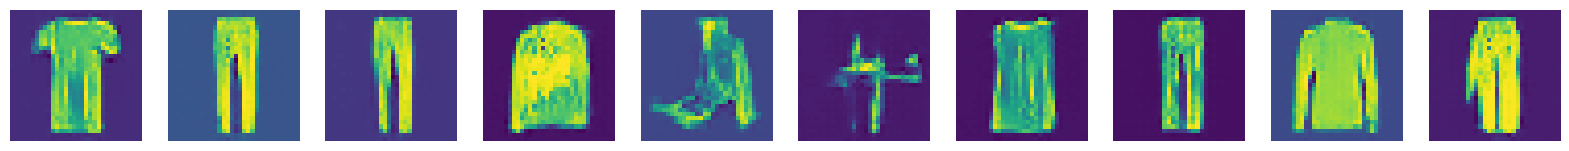

117/117 [==============================] - 9s 81ms/step - d_loss: 0.6658 - d_real_acc: 0.5848 - d_fake_acc: 0.5874 - d_acc: 0.5861 - g_loss: 0.7851 - g_acc: 0.4126
Epoch 99/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6638 - d_real_acc: 0.5866 - d_fake_acc: 0.5919 - d_acc: 0.5893 - g_loss: 0.7901 - g_acc: 0.4081
Saved to ./output/output_dcgan/generated_img_098.png


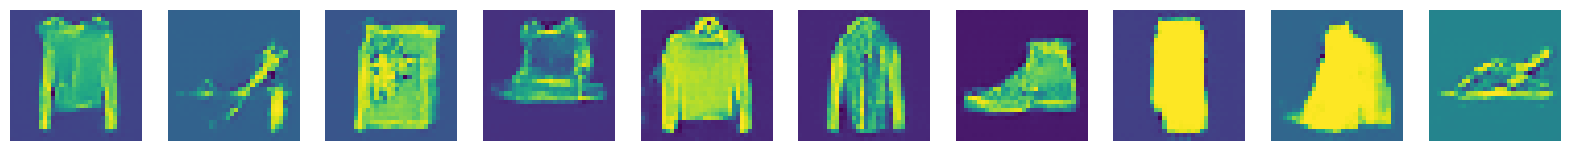

117/117 [==============================] - 10s 82ms/step - d_loss: 0.6638 - d_real_acc: 0.5866 - d_fake_acc: 0.5919 - d_acc: 0.5893 - g_loss: 0.7901 - g_acc: 0.4081
Epoch 100/100
117/117 [==============================] - ETA: 0s - d_loss: 0.6659 - d_real_acc: 0.5843 - d_fake_acc: 0.5880 - d_acc: 0.5862 - g_loss: 0.7836 - g_acc: 0.4120
Saved to ./output/output_dcgan/generated_img_099.png


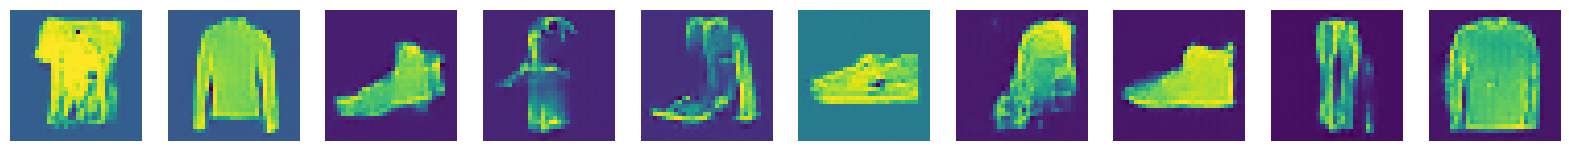

117/117 [==============================] - 9s 80ms/step - d_loss: 0.6659 - d_real_acc: 0.5843 - d_fake_acc: 0.5880 - d_acc: 0.5862 - g_loss: 0.7836 - g_acc: 0.4120
################################################## END TRAINING ##################################################


Saving Models...


Saving Done


TypeError: 'bool' object is not callable

In [16]:
hisotry_dcgan, dcgan = train(dcgan,
                              "dcgan",
                              epochs = EPOCHS,
                              d_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
                              g_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
                              save_models=True,
                              plot_history_flag=True,
                              load_model = False,
                              )

In [18]:
def generate_images(model, num_images):
    # Generate random noise
    noise = tf.random.normal([num_images, model.latent_dim])

    # Generate images from the noise
    generated_images = model.generator(noise, training=False)

    # Rescale the images from [-1, 1] to [0, 1]
    #generated_images = (generated_images + 1) / 2.0

    return generated_images.numpy()

# Generate 10k images
generated_images = generate_images(dcgan, 10000)

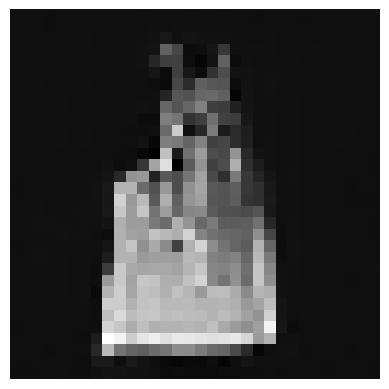

In [19]:
plt.imshow(generated_images[9].astype("float32"), cmap="gray")
plt.axis("off")
plt.show()

In [20]:
print(f"Generated images dataset shape: {generated_images.shape}")

Generated images dataset shape: (10000, 32, 32, 1)


In [21]:
test_data = test_data.astype(np.float32) / 255.0
test_data = np.pad(test_data, ((0, 0), (2, 2), (2, 2)),constant_values=0.)
test_data = np.expand_dims(test_data, axis=-1)

print(f"Test dataset shape: {test_data.shape}")

Test dataset shape: (10000, 32, 32, 1)


In [22]:
train_fid = get_fid(test_data, generated_images)

# Print out the results
print(f"FID(x_test, x_train) = {train_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
1/1 [==============================] - 5s 5s/step
Processed 100 images.
1/1 [==============================] - 0s 125ms/step
Processed 200 images.
1/1 [==============================] - 0s 127ms/step
Processed 300 images.
1/1 [==============================] - 0s 122ms/step
Processed 400 images.
1/1 [==============================] - 0s 122ms/step
Processed 500 images.
1/1 [==============================] - 0s 121ms/step
Processed 600 images.
1/1 [==============================] - 0s 122ms/step
Processed 700 images.
1/1 [==============================] - 0s 126ms/step
Processed 800 images.
1/1 [==============================] - 0s 125ms/step
Processed 900 images.
1/1 [==============================] - 0s 129ms/step
Processed 1000 images.
1/1 [==============================] - 0s 162ms/step
Processed 1100 images.
1/1 [==============================] - 0s 172ms/step
Processed 1200 images.
1/1 [==============================] - 0s 15

In [ ]:
import shutil
from google.colab import files


images_path = './output'
models_path = './models'
log_path = './logs'
ckpt_path = './checkpoint'



models_zip = '/content/models'
images_zip = '/content/output'
log_zip =  '/content/logs'
ckpt_zip = '/content/checkpoint'



shutil.make_archive(models_zip, 'zip', models_path)
shutil.make_archive(images_zip, 'zip', images_path)
shutil.make_archive(log_zip, 'zip', log_path)
shutil.make_archive(ckpt_zip, 'zip', ckpt_path)


# Download the zip file
files.download('/content/models.zip')
files.download('/content/images.zip')
files.download('/content/logs.zip')
files.download('/content/checkpoint.zip')


## WGANSGP

In [23]:
IMG_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = 100
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 100
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False


In [24]:
class ConvBlockLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2,padding='same', use_bias=False, activation='relu',name:str=None):
        super(ConvBlockLayer, self).__init__(name=name)
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,use_bias=use_bias)
        self.activation = tf.keras.layers.LeakyReLU(alpha=alpha) if activation == 'leakyrelu' else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.activation(x)
        return x

class Upsampling(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, alpha=0.2, momentum=0.9, padding='same',activation=None, batchnorm=True, leakyrelu=True, use_bias=False, name:str=None):
        super(Upsampling, self).__init__(name=name)
        self.batchnorm_flag=batchnorm
        self.leakyrelu_flag=leakyrelu
        self.conv_transpose = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding,use_bias=use_bias,activation=activation)
        self.batchnorm = layers.BatchNormalization(momentum=momentum) if momentum is not None else None
        self.leakyrelu = layers.LeakyReLU(alpha=alpha) if self.leakyrelu_flag else tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        if self.batchnorm_flag:
          x = self.batchnorm(x)
        if self.leakyrelu_flag:
          x = self.leakyrelu(x)
        return x

In [41]:
class Critic(tf.keras.Model):
    def __init__(self, critic_input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),name="Discriminator"):
        super(Critic, self).__init__(name=name)
        self.critic_input_shape = critic_input_shape
        self.model_layers= [
            layers.InputLayer(input_shape=self.critic_input_shape,name="InputLayer"),
            ConvBlockLayer(64, kernel_size=4, strides=2,alpha=0.2, padding='same', use_bias=False, activation='leakyrelu',name="ConvBlock_1"),
            layers.Dropout(0.5,name="Dropout_1"),
            ConvBlockLayer(128,kernel_size=4, strides=2,alpha=0.2, padding='same',use_bias=False, activation='leakyrelu',name="ConvBlock_2" ),
            layers.Dropout(0.5, name="Dropout_2"),
            ConvBlockLayer(256,kernel_size=4, strides=2,alpha=0.2,padding="same", use_bias=False,activation='leakyrelu', name="ConvBlock_3"),
            layers.Dropout(0.5, name="Dropout_3"),
            layers.Flatten(name="Flatten"),
            layers.Dropout(0.5,name="Dropout_2"),
            layers.Dense(1,activation='linear',name="Dense")
        ]


    def call(self,x):
      for layer in self.model_layers:
        x = layer(x)
      return x


In [42]:
critic = Critic()
critic.build((None,IMG_SIZE,IMG_SIZE,CHANNELS))
critic.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32, 32, 1)]       0         
                                                                 
 ConvBlock_1 (ConvBlockLaye  multiple                  1024      
 r)                                                              
                                                                 
 Dropout_1 (Dropout)         multiple                  0         
                                                                 
 ConvBlock_2 (ConvBlockLaye  multiple                  131072    
 r)                                                              
                                                                 
 Dropout_2 (Dropout)         multiple                  0         
                                                                 
 ConvBlock_3 (ConvBlockLaye  multiple                

In [27]:
class Generator(tf.keras.Model):
    def __init__(self,generator_input_shape=(Z_DIM,), name="Generator"):
        super(Generator, self).__init__(name=name)
        self.generator_input_shape = generator_input_shape
        self.model_layers = [
            layers.InputLayer(input_shape=self.generator_input_shape,name="InputLayer"),
            layers.Dense((4 * 4 * 512),name="Dense"),
            layers.BatchNormalization(name="BatchNorm_1"),
            layers.LeakyReLU(0.2,name="LeakyReLU_1"),
            layers.Reshape((4,4,512),name="Reshape"),
            Upsampling(256, kernel_size=4, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_1"),
            Upsampling(128, kernel_size=5, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_2"),
            Upsampling(64, kernel_size=5, strides=2, padding="same",alpha=0.2, momentum=0.9, use_bias=False,name="Upsampling_3"),
            Upsampling(CHANNELS,kernel_size=5, padding="same",activation="tanh",batchnorm=False,leakyrelu=False,use_bias=False,name="Gen_Output")
        ]

    def call(self,x):
        for layer in self.model_layers:
          x = layer(x)
        return x


In [28]:
generator = Generator()
generator.build((None,100))
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 100)]             0         
                                                                 
 Dense (Dense)               multiple                  827392    
                                                                 
 BatchNorm_1 (BatchNormaliz  multiple                  32768     
 ation)                                                          
                                                                 
 LeakyReLU_1 (LeakyReLU)     multiple                  0         
                                                                 
 Reshape (Reshape)           multiple                  0         
                                                                 
 Upsampling_1 (Upsampling)   multiple                  2098176   
                                                         

In [34]:
class WGANGP(tf.keras.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        #each image in the batch gets a random number, between 0 and 1, stored as the vector alpha
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        # a set of interpolated images is calculated
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            #score each of these interpolated image
            pred = self.critic(interpolated, training=True)

        #the gradient of the predictions is calculated with respect to the input images
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))   #L2 norm
        gp = tf.reduce_mean((norm - 1.0) ** 2)    #average squared distance between the L2 norm and 1
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        #perform three critic updates
        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                #Wasserstein loss for the critic
                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images                      #gradient penalty term
                )
                #the critic loss function is a weighted sum of the Wasserstein loss and the gradient penalty.
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)               #Update the weights of the critic
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)

            #Calculate the Wasserstein loss for the generator
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)               #Update the weights of the generator
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [43]:
#model instantiation
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

Compiling the WGANGP model...
No model weights found or loading disabled.
Compilation done.


Callbacks instantiation...
checkpoint path already exists
Done


################################################## START TRAINING ##################################################
Epoch 1/100
  6/117 [>.............................] - ETA: 24s - c_loss: 0.3775 - c_wass_loss: 0.0480 - c_gp: 0.0330 - g_loss: 0.5948

117/117 [==============================] - ETA: 0s - c_loss: 0.0208 - c_wass_loss: -0.1960 - c_gp: 0.0217 - g_loss: 0.0493
Saved to ./output/output_wgangp/generated_img_000.png


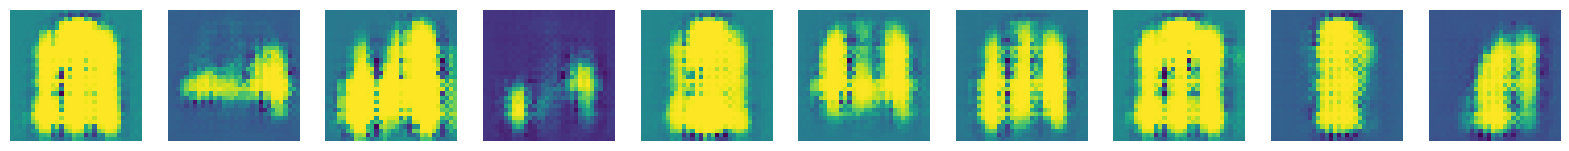

117/117 [==============================] - 38s 242ms/step - c_loss: 0.0208 - c_wass_loss: -0.1960 - c_gp: 0.0217 - g_loss: 0.0493
Epoch 2/100
117/117 [==============================] - ETA: 0s - c_loss: -0.5215 - c_wass_loss: -0.6027 - c_gp: 0.0081 - g_loss: 0.2564
Saved to ./output/output_wgangp/generated_img_001.png


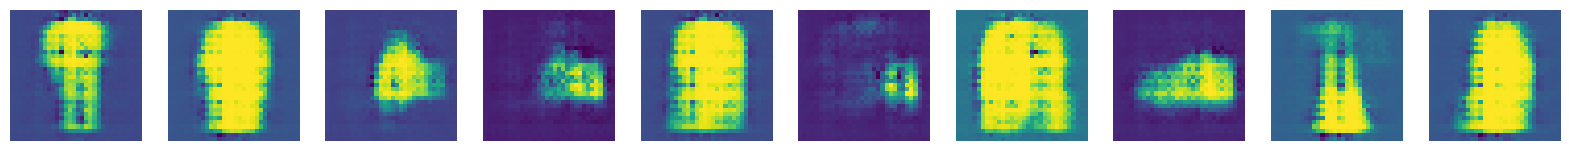

117/117 [==============================] - 28s 235ms/step - c_loss: -0.5215 - c_wass_loss: -0.6027 - c_gp: 0.0081 - g_loss: 0.2564
Epoch 3/100
117/117 [==============================] - ETA: 0s - c_loss: -0.6237 - c_wass_loss: -0.6923 - c_gp: 0.0069 - g_loss: 0.2564
Saved to ./output/output_wgangp/generated_img_002.png


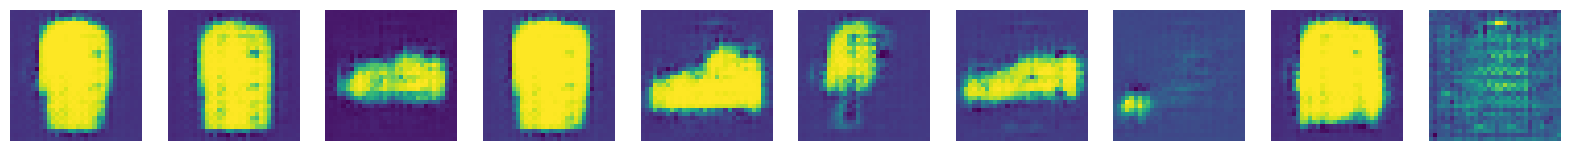

117/117 [==============================] - 27s 234ms/step - c_loss: -0.6237 - c_wass_loss: -0.6923 - c_gp: 0.0069 - g_loss: 0.2564
Epoch 4/100
117/117 [==============================] - ETA: 0s - c_loss: -0.5868 - c_wass_loss: -0.6527 - c_gp: 0.0066 - g_loss: 0.1762
Saved to ./output/output_wgangp/generated_img_003.png


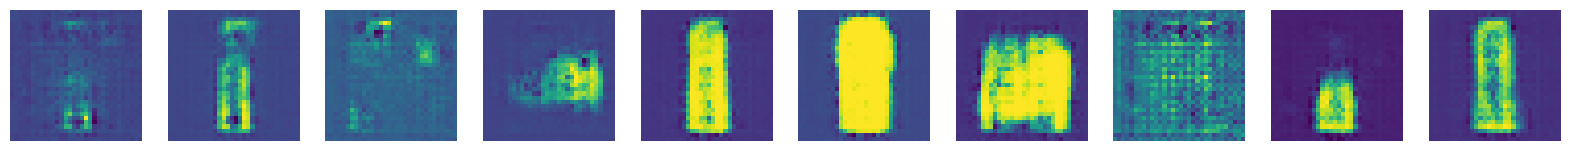

117/117 [==============================] - 27s 234ms/step - c_loss: -0.5868 - c_wass_loss: -0.6527 - c_gp: 0.0066 - g_loss: 0.1762
Epoch 5/100
117/117 [==============================] - ETA: 0s - c_loss: -0.5217 - c_wass_loss: -0.5815 - c_gp: 0.0060 - g_loss: 0.0445
Saved to ./output/output_wgangp/generated_img_004.png


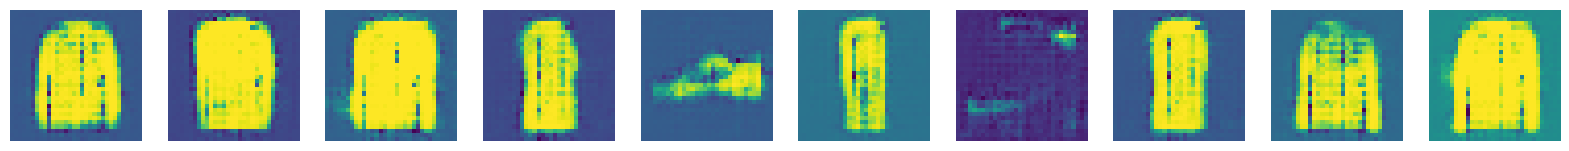

117/117 [==============================] - 28s 236ms/step - c_loss: -0.5217 - c_wass_loss: -0.5815 - c_gp: 0.0060 - g_loss: 0.0445
Epoch 6/100
117/117 [==============================] - ETA: 0s - c_loss: -0.4850 - c_wass_loss: -0.5452 - c_gp: 0.0060 - g_loss: -0.0955
Saved to ./output/output_wgangp/generated_img_005.png


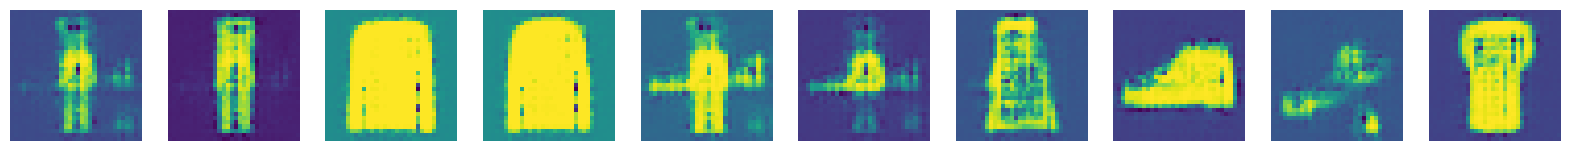

117/117 [==============================] - 28s 239ms/step - c_loss: -0.4850 - c_wass_loss: -0.5452 - c_gp: 0.0060 - g_loss: -0.0955
Epoch 7/100
117/117 [==============================] - ETA: 0s - c_loss: -0.4190 - c_wass_loss: -0.4744 - c_gp: 0.0055 - g_loss: 0.0723
Saved to ./output/output_wgangp/generated_img_006.png


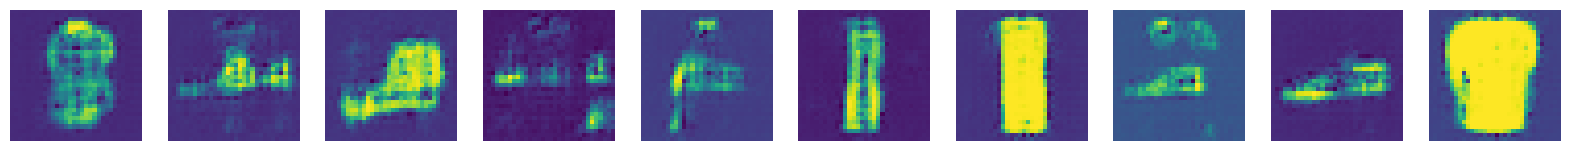

117/117 [==============================] - 27s 234ms/step - c_loss: -0.4190 - c_wass_loss: -0.4744 - c_gp: 0.0055 - g_loss: 0.0723
Epoch 8/100
117/117 [==============================] - ETA: 0s - c_loss: -0.4390 - c_wass_loss: -0.4973 - c_gp: 0.0058 - g_loss: 0.1290
Saved to ./output/output_wgangp/generated_img_007.png


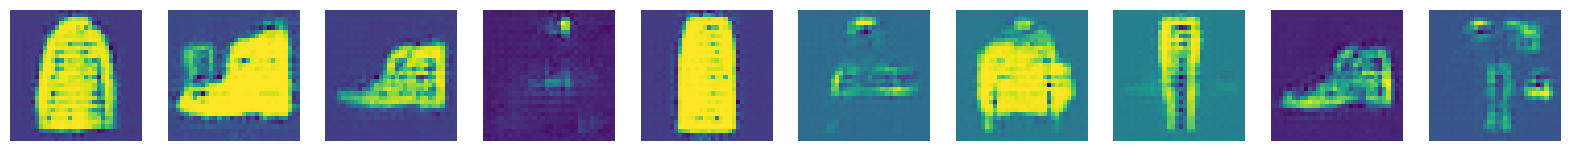

117/117 [==============================] - 28s 237ms/step - c_loss: -0.4390 - c_wass_loss: -0.4973 - c_gp: 0.0058 - g_loss: 0.1290
Epoch 9/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3977 - c_wass_loss: -0.4542 - c_gp: 0.0057 - g_loss: 0.0182
Saved to ./output/output_wgangp/generated_img_008.png


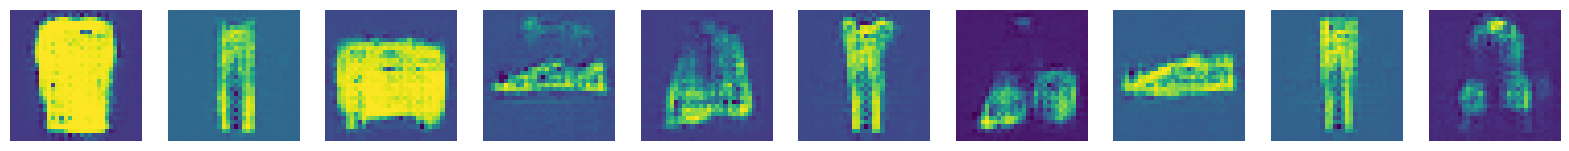

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3977 - c_wass_loss: -0.4542 - c_gp: 0.0057 - g_loss: 0.0182
Epoch 10/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3832 - c_wass_loss: -0.4372 - c_gp: 0.0054 - g_loss: -0.0295
Saved to ./output/output_wgangp/generated_img_009.png


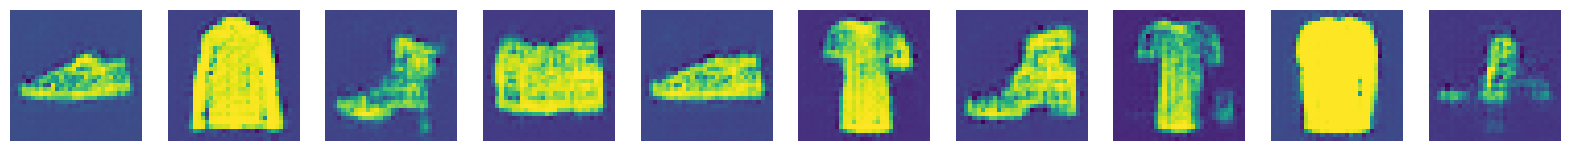

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3832 - c_wass_loss: -0.4372 - c_gp: 0.0054 - g_loss: -0.0295
Epoch 11/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3784 - c_wass_loss: -0.4325 - c_gp: 0.0054 - g_loss: 0.0615
Saved to ./output/output_wgangp/generated_img_010.png


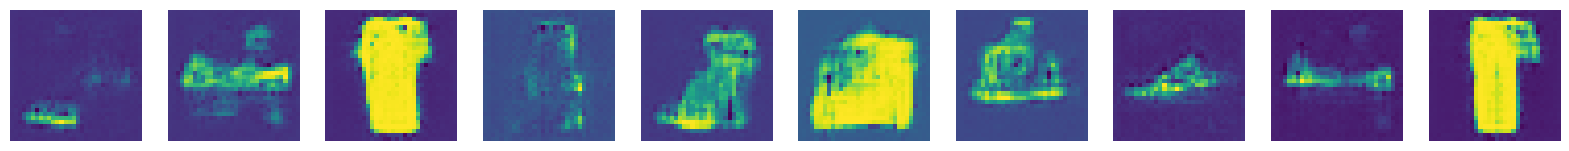

117/117 [==============================] - 28s 235ms/step - c_loss: -0.3784 - c_wass_loss: -0.4325 - c_gp: 0.0054 - g_loss: 0.0615
Epoch 12/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3837 - c_wass_loss: -0.4398 - c_gp: 0.0056 - g_loss: 0.0692
Saved to ./output/output_wgangp/generated_img_011.png


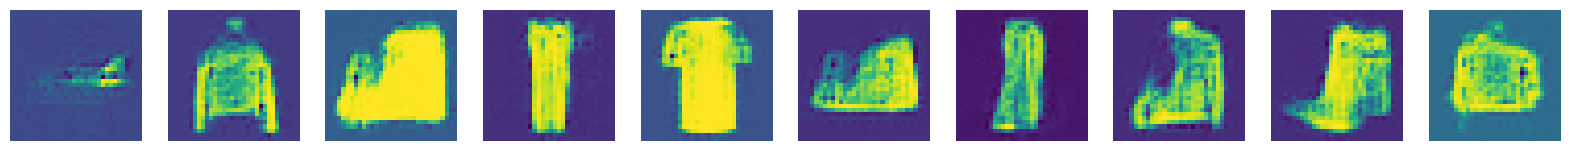

117/117 [==============================] - 28s 239ms/step - c_loss: -0.3837 - c_wass_loss: -0.4398 - c_gp: 0.0056 - g_loss: 0.0692
Epoch 13/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3668 - c_wass_loss: -0.4204 - c_gp: 0.0054 - g_loss: -0.0336
Saved to ./output/output_wgangp/generated_img_012.png


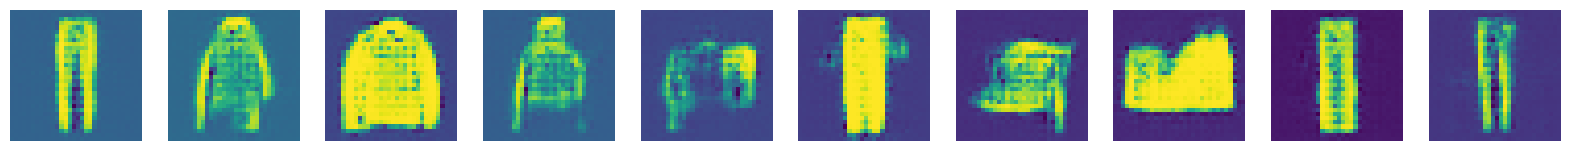

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3668 - c_wass_loss: -0.4204 - c_gp: 0.0054 - g_loss: -0.0336
Epoch 14/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3197 - c_wass_loss: -0.3701 - c_gp: 0.0050 - g_loss: 0.0038
Saved to ./output/output_wgangp/generated_img_013.png


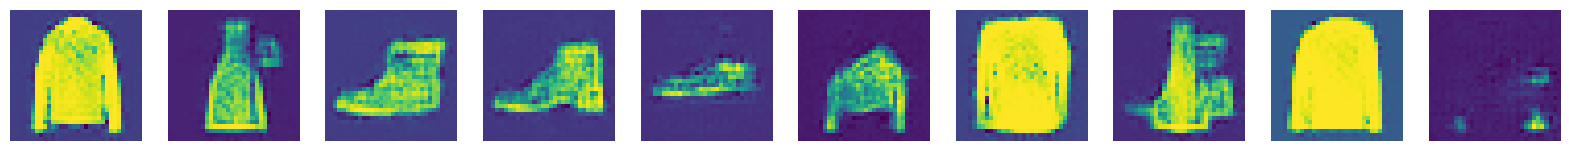

117/117 [==============================] - 28s 235ms/step - c_loss: -0.3197 - c_wass_loss: -0.3701 - c_gp: 0.0050 - g_loss: 0.0038
Epoch 15/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3519 - c_wass_loss: -0.4033 - c_gp: 0.0051 - g_loss: 0.0033     
Saved to ./output/output_wgangp/generated_img_014.png


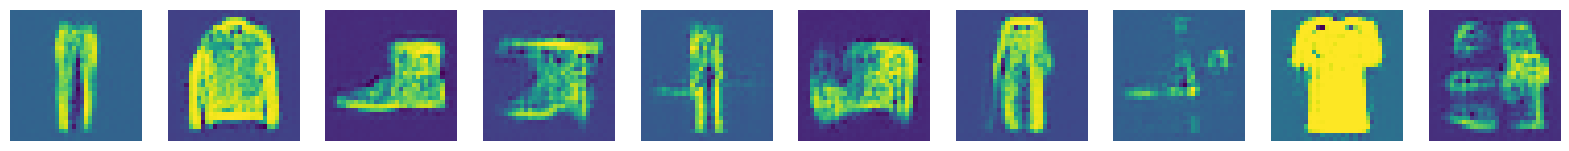

117/117 [==============================] - 28s 238ms/step - c_loss: -0.3519 - c_wass_loss: -0.4033 - c_gp: 0.0051 - g_loss: 0.0033
Epoch 16/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3312 - c_wass_loss: -0.3825 - c_gp: 0.0051 - g_loss: 0.0341
Saved to ./output/output_wgangp/generated_img_015.png


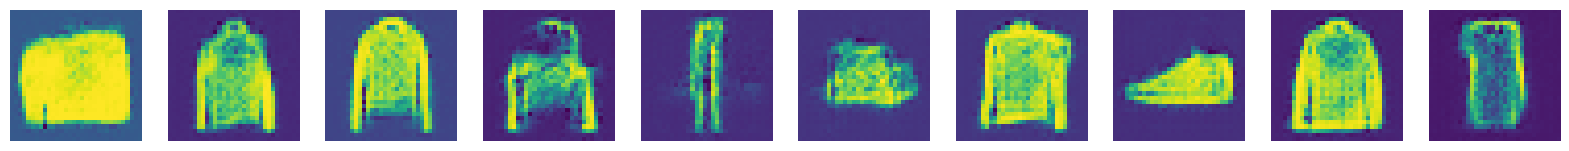

117/117 [==============================] - 28s 241ms/step - c_loss: -0.3312 - c_wass_loss: -0.3825 - c_gp: 0.0051 - g_loss: 0.0341
Epoch 17/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3108 - c_wass_loss: -0.3602 - c_gp: 0.0049 - g_loss: 0.0093
Saved to ./output/output_wgangp/generated_img_016.png


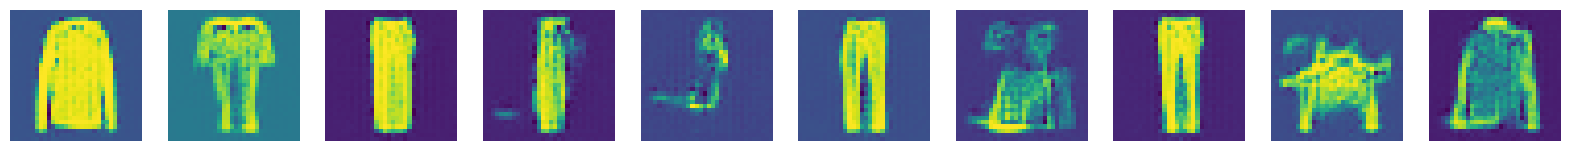

117/117 [==============================] - 28s 236ms/step - c_loss: -0.3108 - c_wass_loss: -0.3602 - c_gp: 0.0049 - g_loss: 0.0093
Epoch 18/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3250 - c_wass_loss: -0.3751 - c_gp: 0.0050 - g_loss: 0.0065 
Saved to ./output/output_wgangp/generated_img_017.png


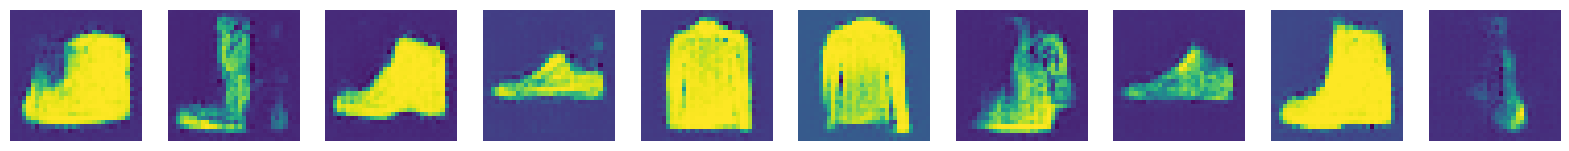

117/117 [==============================] - 28s 236ms/step - c_loss: -0.3250 - c_wass_loss: -0.3751 - c_gp: 0.0050 - g_loss: 0.0065
Epoch 19/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3273 - c_wass_loss: -0.3761 - c_gp: 0.0049 - g_loss: 0.0493
Saved to ./output/output_wgangp/generated_img_018.png


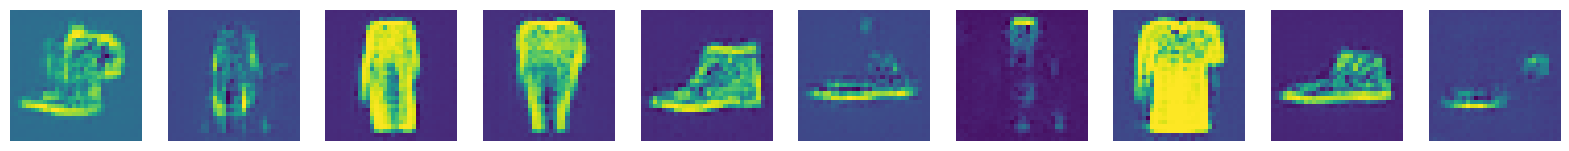

117/117 [==============================] - 28s 236ms/step - c_loss: -0.3273 - c_wass_loss: -0.3761 - c_gp: 0.0049 - g_loss: 0.0493
Epoch 20/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3159 - c_wass_loss: -0.3670 - c_gp: 0.0051 - g_loss: -0.0343
Saved to ./output/output_wgangp/generated_img_019.png


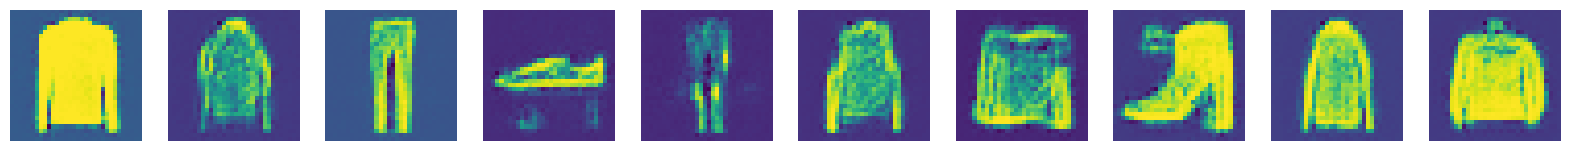

117/117 [==============================] - 28s 238ms/step - c_loss: -0.3159 - c_wass_loss: -0.3670 - c_gp: 0.0051 - g_loss: -0.0343
Epoch 21/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3213 - c_wass_loss: -0.3706 - c_gp: 0.0049 - g_loss: 0.0322
Saved to ./output/output_wgangp/generated_img_020.png


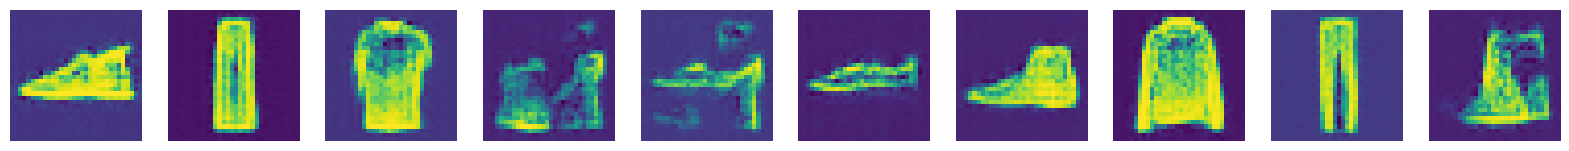

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3213 - c_wass_loss: -0.3706 - c_gp: 0.0049 - g_loss: 0.0322
Epoch 22/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3013 - c_wass_loss: -0.3487 - c_gp: 0.0047 - g_loss: -0.0030
Saved to ./output/output_wgangp/generated_img_021.png


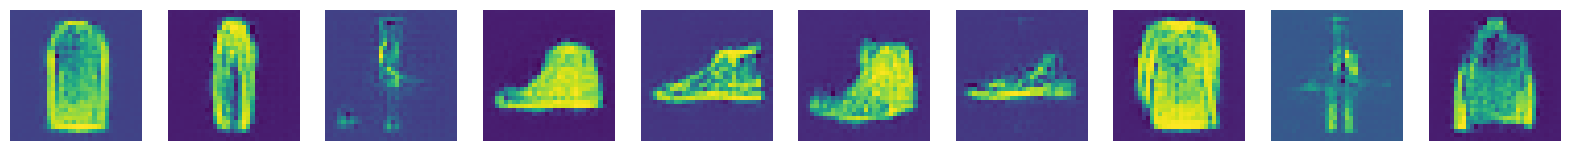

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3013 - c_wass_loss: -0.3487 - c_gp: 0.0047 - g_loss: -0.0030
Epoch 23/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3157 - c_wass_loss: -0.3635 - c_gp: 0.0048 - g_loss: 0.0389
Saved to ./output/output_wgangp/generated_img_022.png


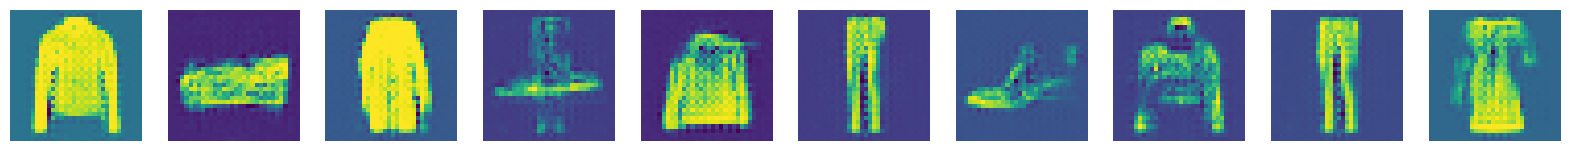

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3157 - c_wass_loss: -0.3635 - c_gp: 0.0048 - g_loss: 0.0389
Epoch 24/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3280 - c_wass_loss: -0.3769 - c_gp: 0.0049 - g_loss: 0.0030
Saved to ./output/output_wgangp/generated_img_023.png


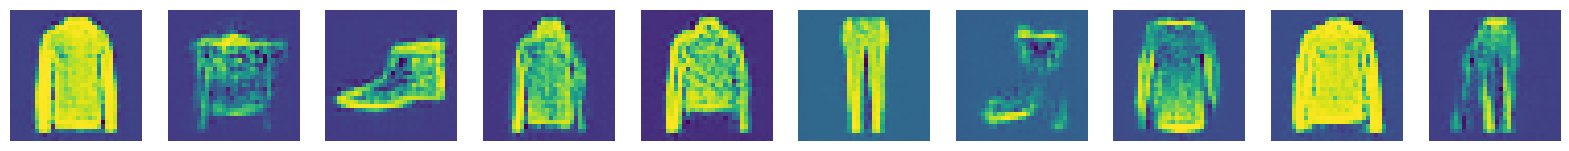

117/117 [==============================] - 27s 234ms/step - c_loss: -0.3280 - c_wass_loss: -0.3769 - c_gp: 0.0049 - g_loss: 0.0030
Epoch 25/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3132 - c_wass_loss: -0.3619 - c_gp: 0.0049 - g_loss: 0.0199
Saved to ./output/output_wgangp/generated_img_024.png


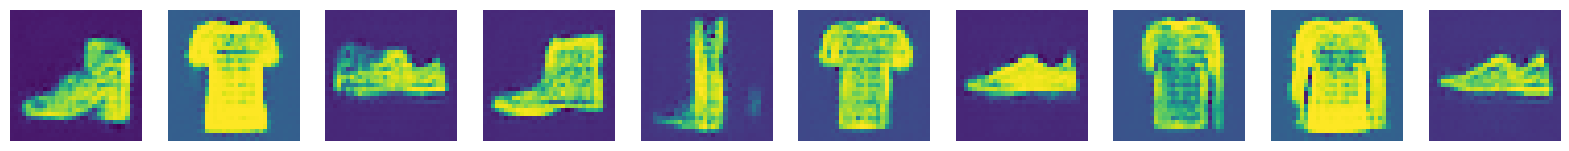

117/117 [==============================] - 28s 240ms/step - c_loss: -0.3132 - c_wass_loss: -0.3619 - c_gp: 0.0049 - g_loss: 0.0199
Epoch 26/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2813 - c_wass_loss: -0.3277 - c_gp: 0.0046 - g_loss: 0.0167
Saved to ./output/output_wgangp/generated_img_025.png


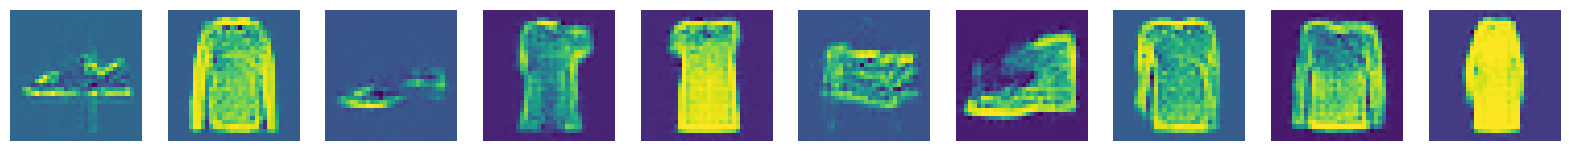

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2813 - c_wass_loss: -0.3277 - c_gp: 0.0046 - g_loss: 0.0167
Epoch 27/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3241 - c_wass_loss: -0.3751 - c_gp: 0.0051 - g_loss: 0.0101
Saved to ./output/output_wgangp/generated_img_026.png


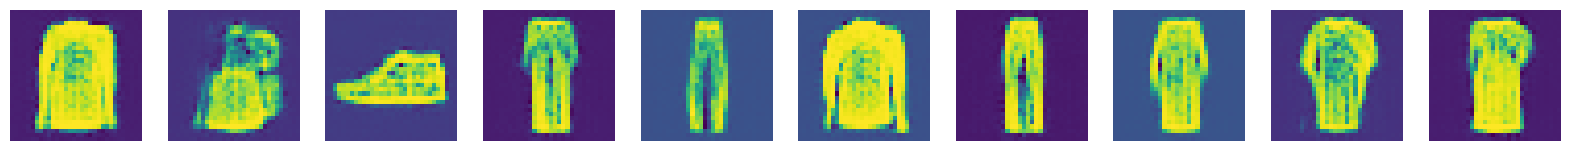

117/117 [==============================] - 27s 235ms/step - c_loss: -0.3241 - c_wass_loss: -0.3751 - c_gp: 0.0051 - g_loss: 0.0101
Epoch 28/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2936 - c_wass_loss: -0.3419 - c_gp: 0.0048 - g_loss: -5.8821e-04
Saved to ./output/output_wgangp/generated_img_027.png


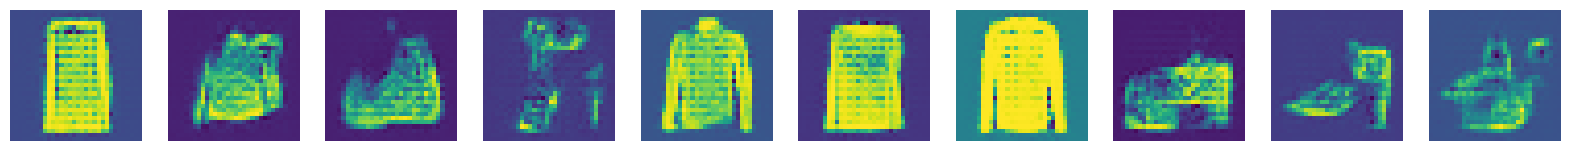

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2936 - c_wass_loss: -0.3419 - c_gp: 0.0048 - g_loss: -5.8821e-04
Epoch 29/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2764 - c_wass_loss: -0.3220 - c_gp: 0.0046 - g_loss: 0.0196
Saved to ./output/output_wgangp/generated_img_028.png


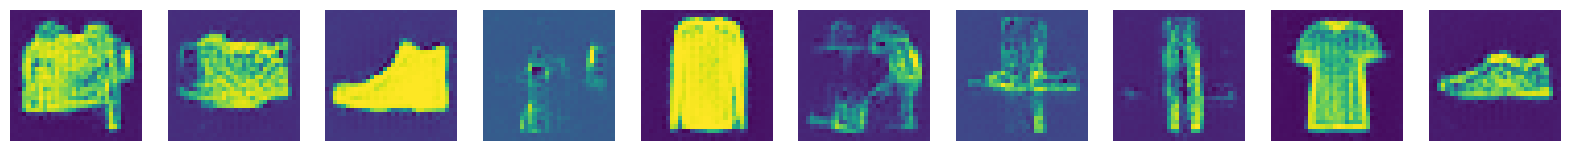

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2764 - c_wass_loss: -0.3220 - c_gp: 0.0046 - g_loss: 0.0196
Epoch 30/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2702 - c_wass_loss: -0.3162 - c_gp: 0.0046 - g_loss: -0.0575
Saved to ./output/output_wgangp/generated_img_029.png


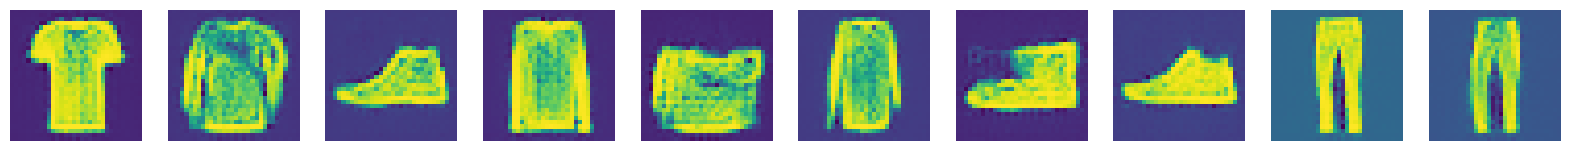

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2702 - c_wass_loss: -0.3162 - c_gp: 0.0046 - g_loss: -0.0575
Epoch 31/100
117/117 [==============================] - ETA: 0s - c_loss: -0.3014 - c_wass_loss: -0.3505 - c_gp: 0.0049 - g_loss: -5.4109e-04
Saved to ./output/output_wgangp/generated_img_030.png


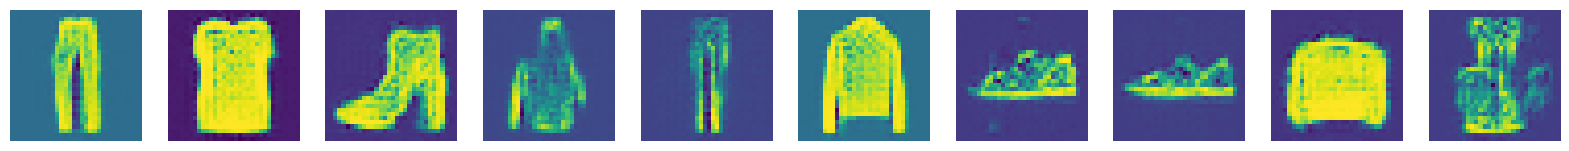

117/117 [==============================] - 28s 235ms/step - c_loss: -0.3014 - c_wass_loss: -0.3505 - c_gp: 0.0049 - g_loss: -5.4109e-04
Epoch 32/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2808 - c_wass_loss: -0.3265 - c_gp: 0.0046 - g_loss: -0.0203
Saved to ./output/output_wgangp/generated_img_031.png


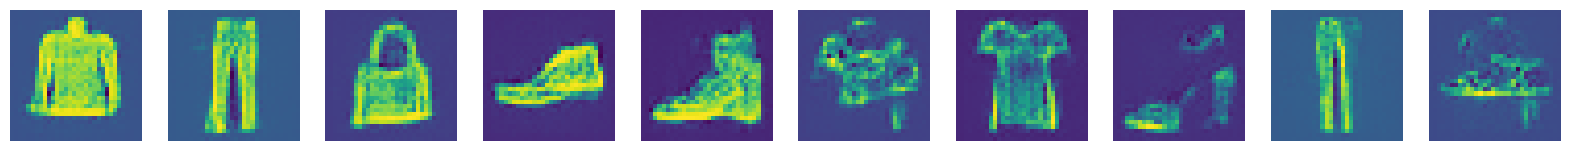

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2808 - c_wass_loss: -0.3265 - c_gp: 0.0046 - g_loss: -0.0203
Epoch 33/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2874 - c_wass_loss: -0.3345 - c_gp: 0.0047 - g_loss: 0.0165
Saved to ./output/output_wgangp/generated_img_032.png


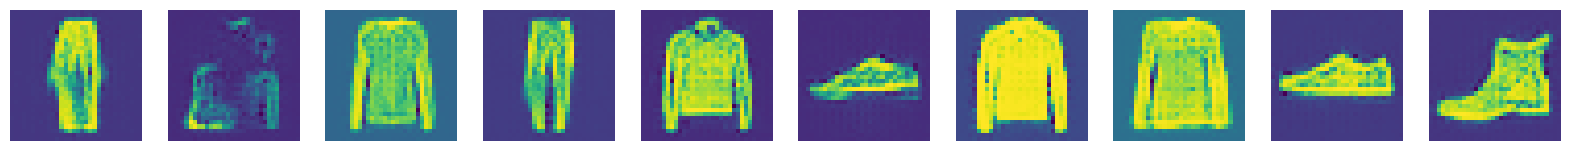

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2874 - c_wass_loss: -0.3345 - c_gp: 0.0047 - g_loss: 0.0165
Epoch 34/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2717 - c_wass_loss: -0.3165 - c_gp: 0.0045 - g_loss: -0.0383
Saved to ./output/output_wgangp/generated_img_033.png


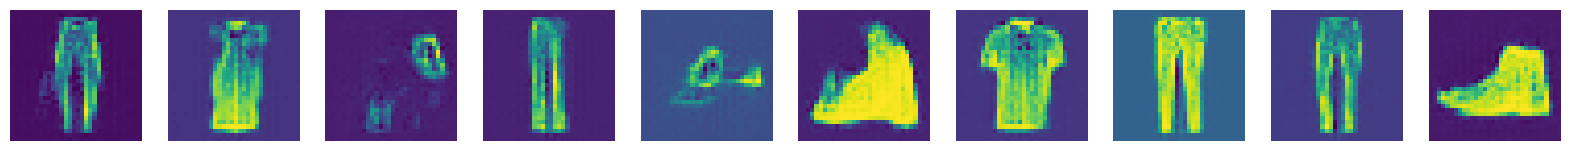

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2717 - c_wass_loss: -0.3165 - c_gp: 0.0045 - g_loss: -0.0383
Epoch 35/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2606 - c_wass_loss: -0.3054 - c_gp: 0.0045 - g_loss: -0.0265
Saved to ./output/output_wgangp/generated_img_034.png


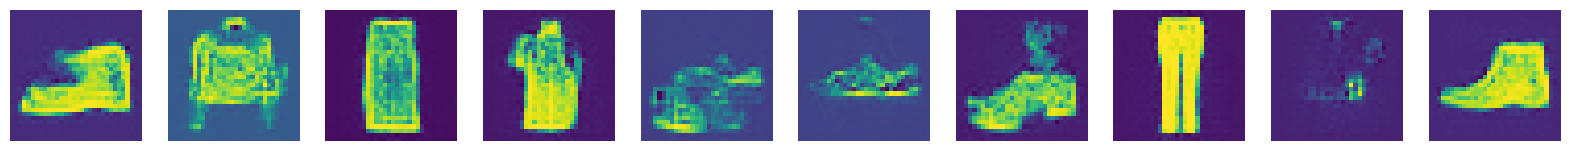

117/117 [==============================] - 29s 244ms/step - c_loss: -0.2606 - c_wass_loss: -0.3054 - c_gp: 0.0045 - g_loss: -0.0265
Epoch 36/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2582 - c_wass_loss: -0.3035 - c_gp: 0.0045 - g_loss: -0.0232
Saved to ./output/output_wgangp/generated_img_035.png


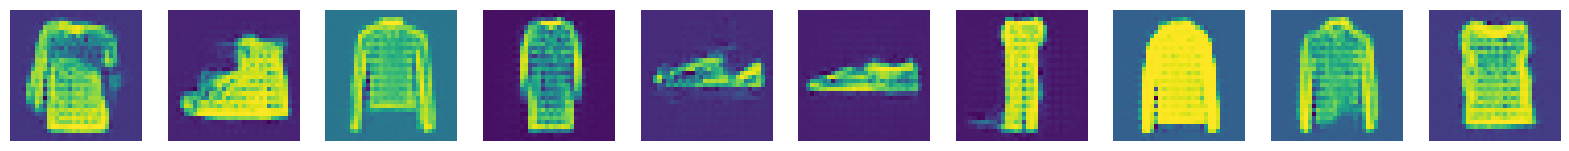

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2582 - c_wass_loss: -0.3035 - c_gp: 0.0045 - g_loss: -0.0232
Epoch 37/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2462 - c_wass_loss: -0.2899 - c_gp: 0.0044 - g_loss: -0.0374
Saved to ./output/output_wgangp/generated_img_036.png


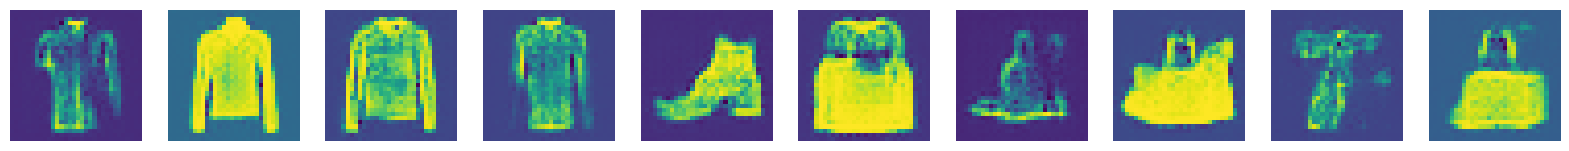

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2462 - c_wass_loss: -0.2899 - c_gp: 0.0044 - g_loss: -0.0374
Epoch 38/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2792 - c_wass_loss: -0.3255 - c_gp: 0.0046 - g_loss: 0.0049
Saved to ./output/output_wgangp/generated_img_037.png


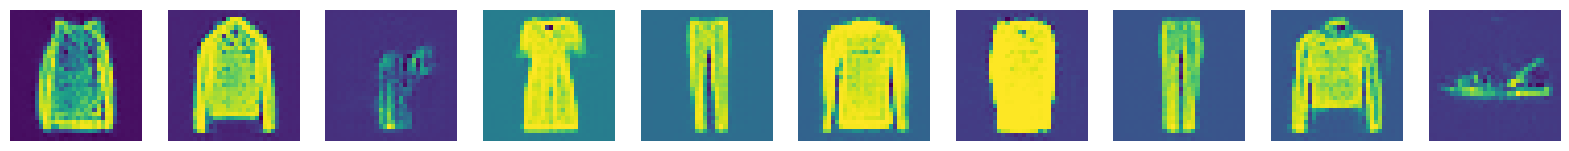

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2792 - c_wass_loss: -0.3255 - c_gp: 0.0046 - g_loss: 0.0049
Epoch 39/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2436 - c_wass_loss: -0.2872 - c_gp: 0.0044 - g_loss: -0.0246
Saved to ./output/output_wgangp/generated_img_038.png


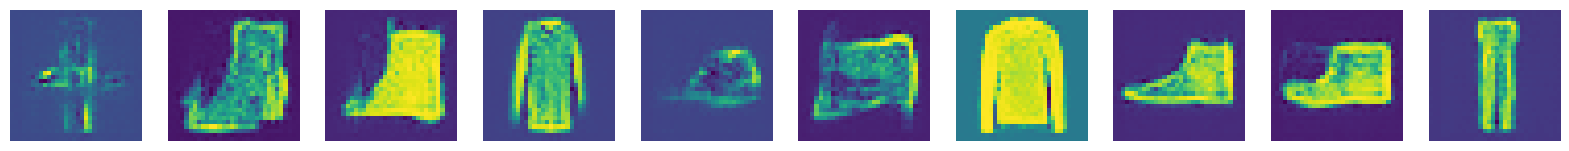

117/117 [==============================] - 28s 238ms/step - c_loss: -0.2436 - c_wass_loss: -0.2872 - c_gp: 0.0044 - g_loss: -0.0246
Epoch 40/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2499 - c_wass_loss: -0.2928 - c_gp: 0.0043 - g_loss: -0.0424
Saved to ./output/output_wgangp/generated_img_039.png


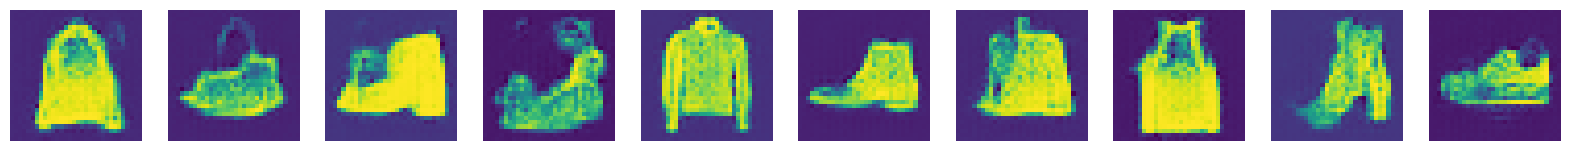

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2499 - c_wass_loss: -0.2928 - c_gp: 0.0043 - g_loss: -0.0424
Epoch 41/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2463 - c_wass_loss: -0.2900 - c_gp: 0.0044 - g_loss: -0.0614
Saved to ./output/output_wgangp/generated_img_040.png


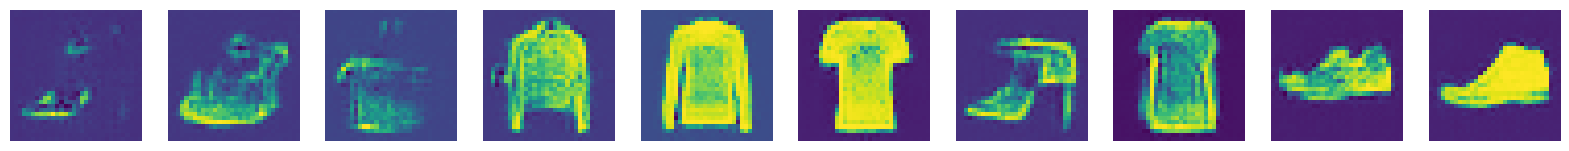

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2463 - c_wass_loss: -0.2900 - c_gp: 0.0044 - g_loss: -0.0614
Epoch 42/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2464 - c_wass_loss: -0.2899 - c_gp: 0.0043 - g_loss: -0.0279
Saved to ./output/output_wgangp/generated_img_041.png


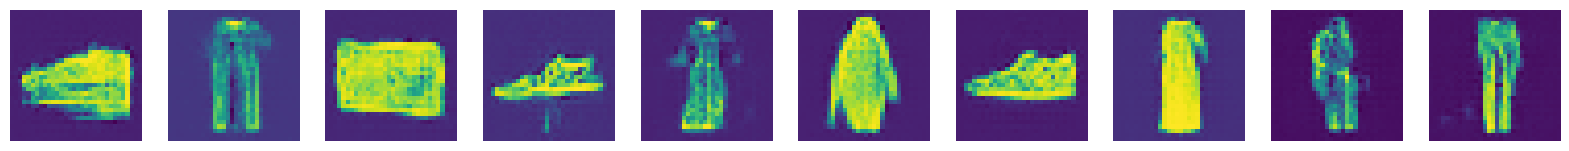

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2464 - c_wass_loss: -0.2899 - c_gp: 0.0043 - g_loss: -0.0279
Epoch 43/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2546 - c_wass_loss: -0.2980 - c_gp: 0.0043 - g_loss: -0.0407
Saved to ./output/output_wgangp/generated_img_042.png


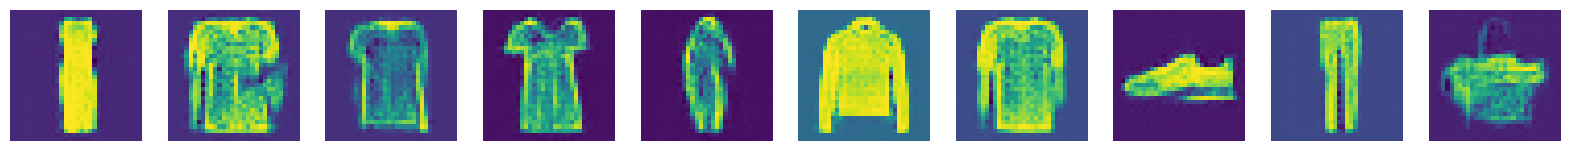

117/117 [==============================] - 28s 240ms/step - c_loss: -0.2546 - c_wass_loss: -0.2980 - c_gp: 0.0043 - g_loss: -0.0407
Epoch 44/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2449 - c_wass_loss: -0.2875 - c_gp: 0.0043 - g_loss: -0.0343
Saved to ./output/output_wgangp/generated_img_043.png


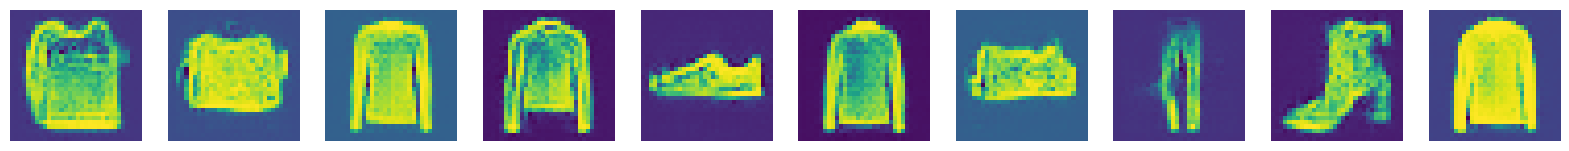

117/117 [==============================] - 28s 240ms/step - c_loss: -0.2449 - c_wass_loss: -0.2875 - c_gp: 0.0043 - g_loss: -0.0343
Epoch 45/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2560 - c_wass_loss: -0.2993 - c_gp: 0.0043 - g_loss: -0.0223
Saved to ./output/output_wgangp/generated_img_044.png


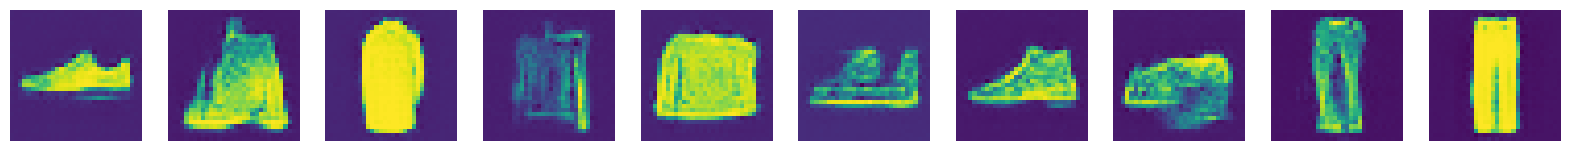

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2560 - c_wass_loss: -0.2993 - c_gp: 0.0043 - g_loss: -0.0223
Epoch 46/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2327 - c_wass_loss: -0.2751 - c_gp: 0.0042 - g_loss: -0.0525
Saved to ./output/output_wgangp/generated_img_045.png


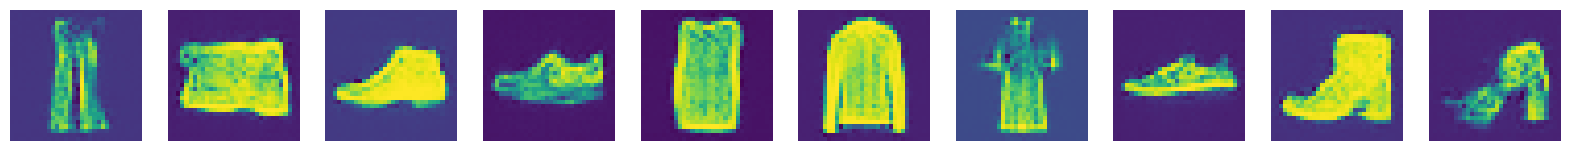

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2327 - c_wass_loss: -0.2751 - c_gp: 0.0042 - g_loss: -0.0525
Epoch 47/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2600 - c_wass_loss: -0.3029 - c_gp: 0.0043 - g_loss: 0.0216
Saved to ./output/output_wgangp/generated_img_046.png


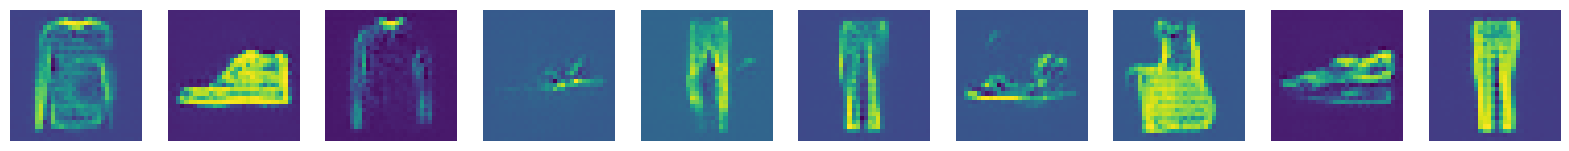

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2600 - c_wass_loss: -0.3029 - c_gp: 0.0043 - g_loss: 0.0216
Epoch 48/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2349 - c_wass_loss: -0.2766 - c_gp: 0.0042 - g_loss: -0.0653
Saved to ./output/output_wgangp/generated_img_047.png


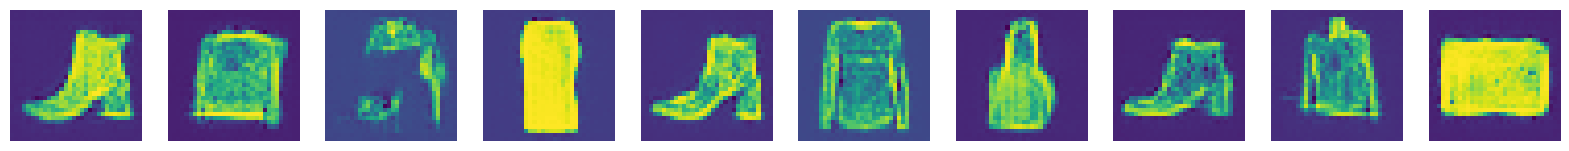

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2349 - c_wass_loss: -0.2766 - c_gp: 0.0042 - g_loss: -0.0653
Epoch 49/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2358 - c_wass_loss: -0.2766 - c_gp: 0.0041 - g_loss: -0.0298
Saved to ./output/output_wgangp/generated_img_048.png


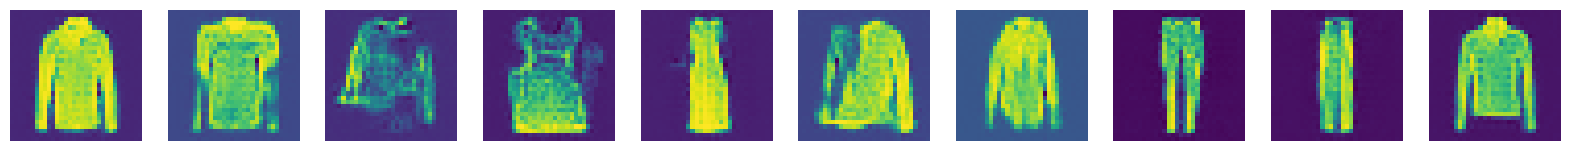

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2358 - c_wass_loss: -0.2766 - c_gp: 0.0041 - g_loss: -0.0298
Epoch 50/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2385 - c_wass_loss: -0.2806 - c_gp: 0.0042 - g_loss: -0.0517
Saved to ./output/output_wgangp/generated_img_049.png


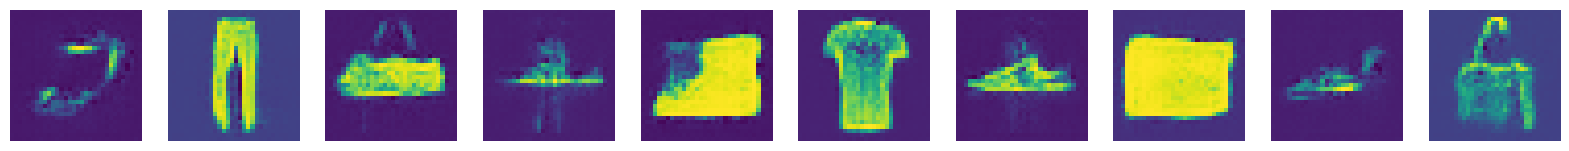

117/117 [==============================] - 28s 239ms/step - c_loss: -0.2385 - c_wass_loss: -0.2806 - c_gp: 0.0042 - g_loss: -0.0517
Epoch 51/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2271 - c_wass_loss: -0.2675 - c_gp: 0.0040 - g_loss: -0.0221
Saved to ./output/output_wgangp/generated_img_050.png


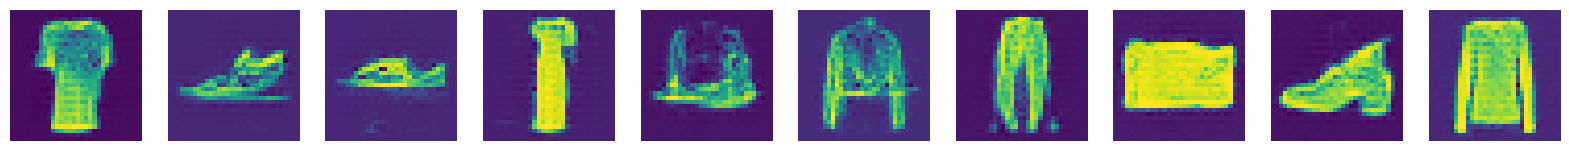

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2271 - c_wass_loss: -0.2675 - c_gp: 0.0040 - g_loss: -0.0221
Epoch 52/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2398 - c_wass_loss: -0.2817 - c_gp: 0.0042 - g_loss: -0.0250
Saved to ./output/output_wgangp/generated_img_051.png


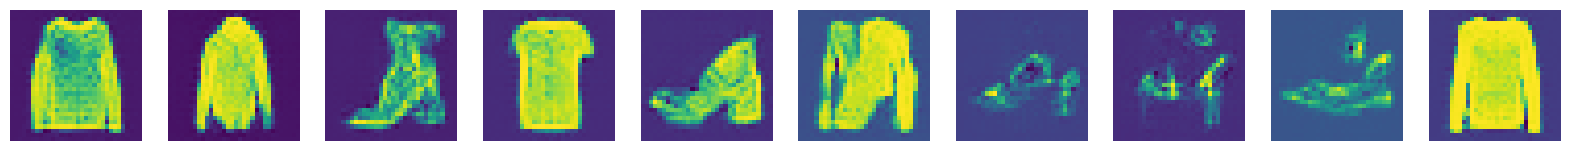

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2398 - c_wass_loss: -0.2817 - c_gp: 0.0042 - g_loss: -0.0250
Epoch 53/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2222 - c_wass_loss: -0.2625 - c_gp: 0.0040 - g_loss: -0.0631
Saved to ./output/output_wgangp/generated_img_052.png


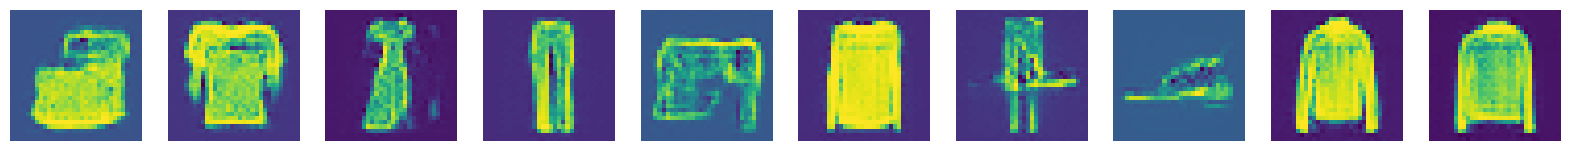

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2222 - c_wass_loss: -0.2625 - c_gp: 0.0040 - g_loss: -0.0631
Epoch 54/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2250 - c_wass_loss: -0.2668 - c_gp: 0.0042 - g_loss: -0.0598
Saved to ./output/output_wgangp/generated_img_053.png


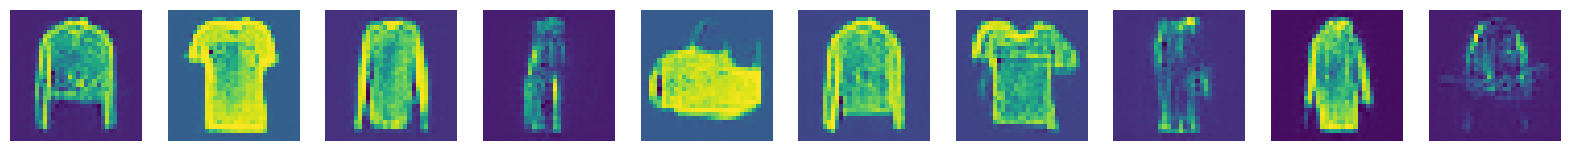

117/117 [==============================] - 29s 246ms/step - c_loss: -0.2250 - c_wass_loss: -0.2668 - c_gp: 0.0042 - g_loss: -0.0598
Epoch 55/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2246 - c_wass_loss: -0.2645 - c_gp: 0.0040 - g_loss: -0.0247
Saved to ./output/output_wgangp/generated_img_054.png


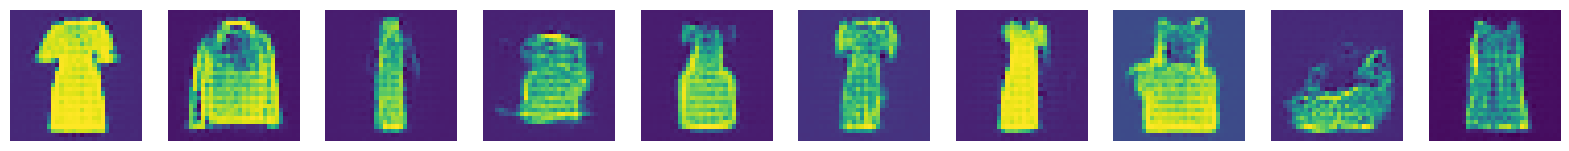

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2246 - c_wass_loss: -0.2645 - c_gp: 0.0040 - g_loss: -0.0247
Epoch 56/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2290 - c_wass_loss: -0.2690 - c_gp: 0.0040 - g_loss: -0.0371
Saved to ./output/output_wgangp/generated_img_055.png


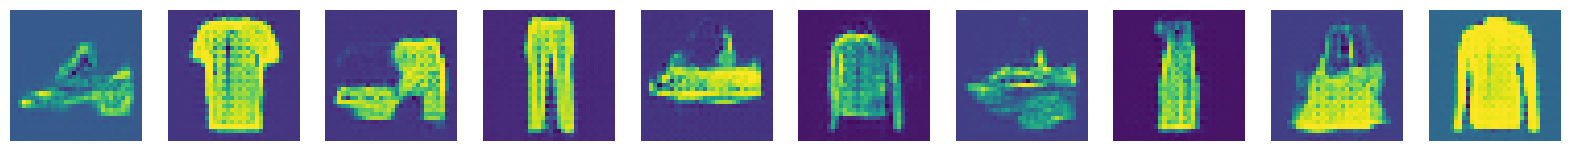

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2290 - c_wass_loss: -0.2690 - c_gp: 0.0040 - g_loss: -0.0371
Epoch 57/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2291 - c_wass_loss: -0.2702 - c_gp: 0.0041 - g_loss: -0.0156
Saved to ./output/output_wgangp/generated_img_056.png


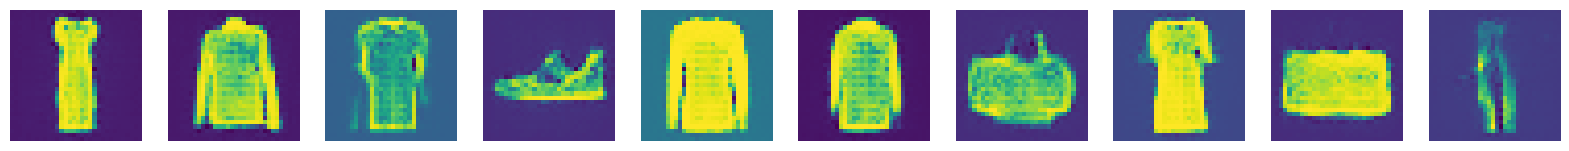

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2291 - c_wass_loss: -0.2702 - c_gp: 0.0041 - g_loss: -0.0156
Epoch 58/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2092 - c_wass_loss: -0.2484 - c_gp: 0.0039 - g_loss: -0.0559
Saved to ./output/output_wgangp/generated_img_057.png


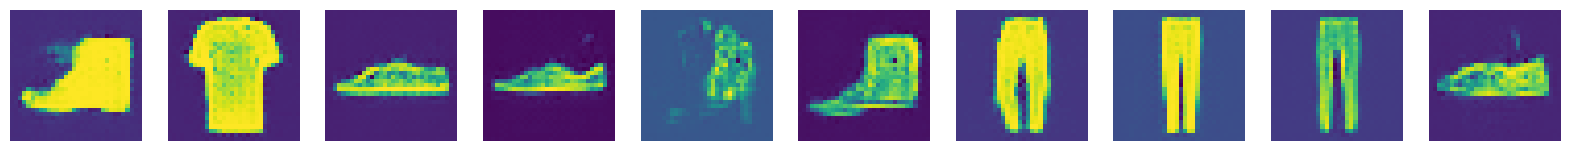

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2092 - c_wass_loss: -0.2484 - c_gp: 0.0039 - g_loss: -0.0559
Epoch 59/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2061 - c_wass_loss: -0.2443 - c_gp: 0.0038 - g_loss: -0.0531
Saved to ./output/output_wgangp/generated_img_058.png


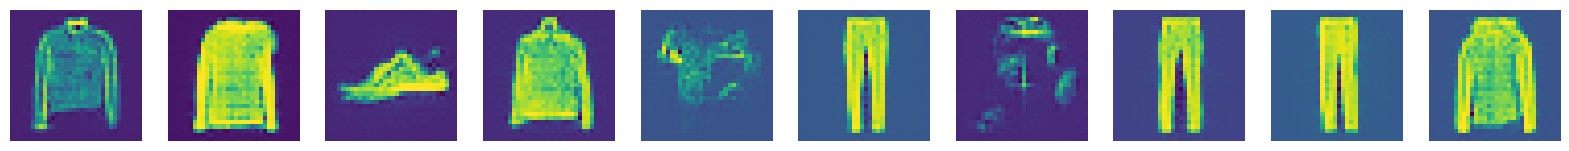

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2061 - c_wass_loss: -0.2443 - c_gp: 0.0038 - g_loss: -0.0531
Epoch 60/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2084 - c_wass_loss: -0.2464 - c_gp: 0.0038 - g_loss: -0.0202
Saved to ./output/output_wgangp/generated_img_059.png


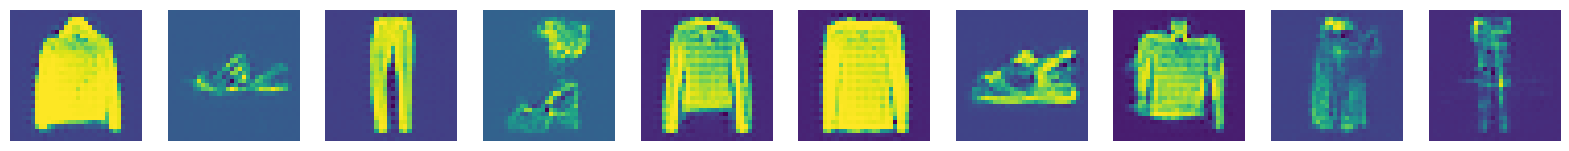

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2084 - c_wass_loss: -0.2464 - c_gp: 0.0038 - g_loss: -0.0202
Epoch 61/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2297 - c_wass_loss: -0.2712 - c_gp: 0.0042 - g_loss: -0.0615
Saved to ./output/output_wgangp/generated_img_060.png


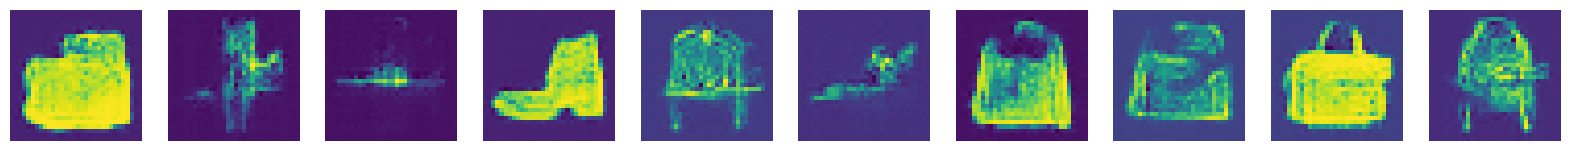

117/117 [==============================] - 28s 238ms/step - c_loss: -0.2297 - c_wass_loss: -0.2712 - c_gp: 0.0042 - g_loss: -0.0615
Epoch 62/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2172 - c_wass_loss: -0.2553 - c_gp: 0.0038 - g_loss: -0.0578
Saved to ./output/output_wgangp/generated_img_061.png


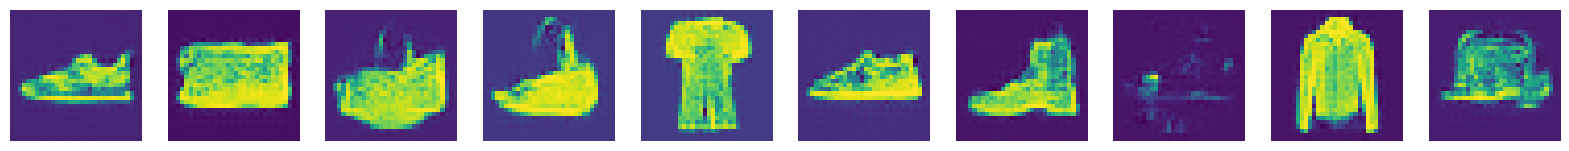

117/117 [==============================] - 28s 236ms/step - c_loss: -0.2172 - c_wass_loss: -0.2553 - c_gp: 0.0038 - g_loss: -0.0578
Epoch 63/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2111 - c_wass_loss: -0.2508 - c_gp: 0.0040 - g_loss: -0.0514
Saved to ./output/output_wgangp/generated_img_062.png


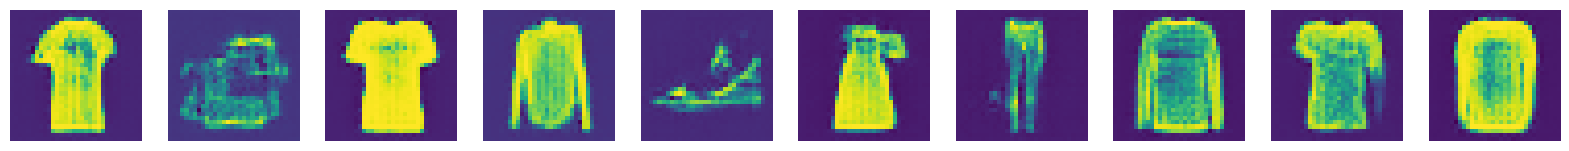

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2111 - c_wass_loss: -0.2508 - c_gp: 0.0040 - g_loss: -0.0514
Epoch 64/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2148 - c_wass_loss: -0.2538 - c_gp: 0.0039 - g_loss: -0.0486
Saved to ./output/output_wgangp/generated_img_063.png


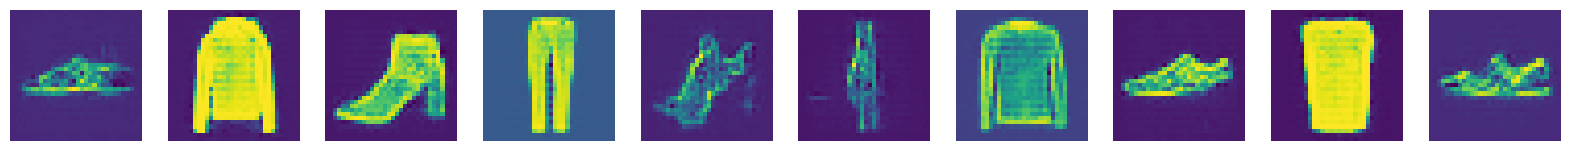

117/117 [==============================] - 28s 241ms/step - c_loss: -0.2148 - c_wass_loss: -0.2538 - c_gp: 0.0039 - g_loss: -0.0486
Epoch 65/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2077 - c_wass_loss: -0.2460 - c_gp: 0.0038 - g_loss: -0.0243
Saved to ./output/output_wgangp/generated_img_064.png


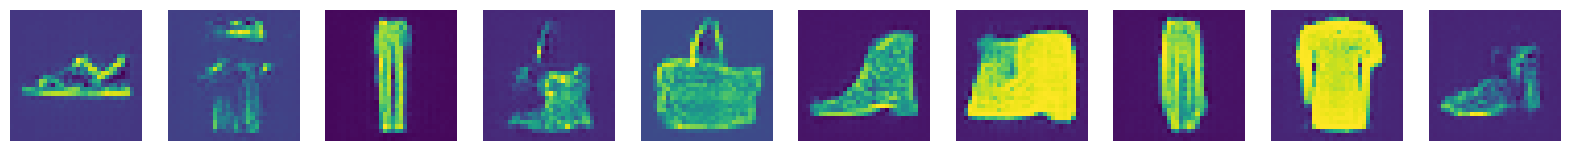

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2077 - c_wass_loss: -0.2460 - c_gp: 0.0038 - g_loss: -0.0243
Epoch 66/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2021 - c_wass_loss: -0.2403 - c_gp: 0.0038 - g_loss: -0.0565
Saved to ./output/output_wgangp/generated_img_065.png


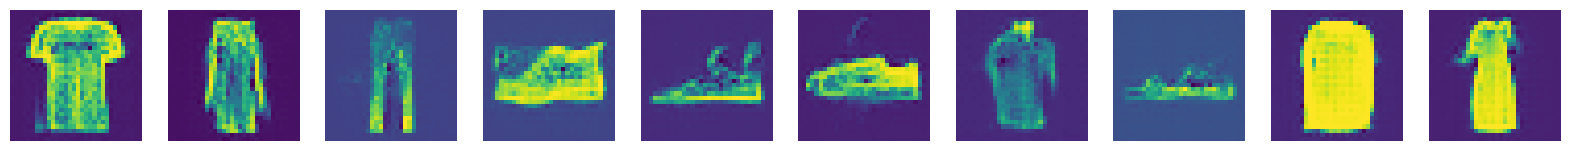

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2021 - c_wass_loss: -0.2403 - c_gp: 0.0038 - g_loss: -0.0565
Epoch 67/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2132 - c_wass_loss: -0.2511 - c_gp: 0.0038 - g_loss: -0.0527
Saved to ./output/output_wgangp/generated_img_066.png


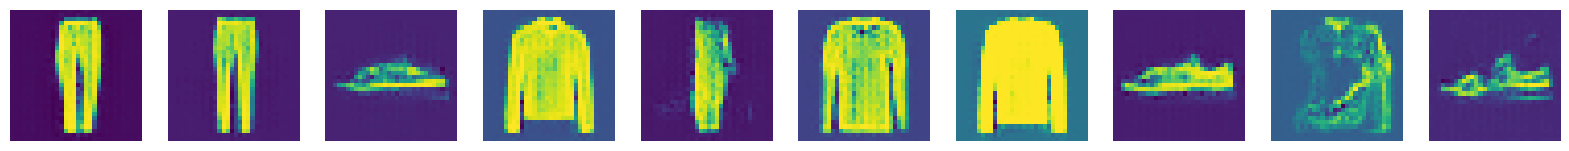

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2132 - c_wass_loss: -0.2511 - c_gp: 0.0038 - g_loss: -0.0527
Epoch 68/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2142 - c_wass_loss: -0.2529 - c_gp: 0.0039 - g_loss: -0.0061
Saved to ./output/output_wgangp/generated_img_067.png


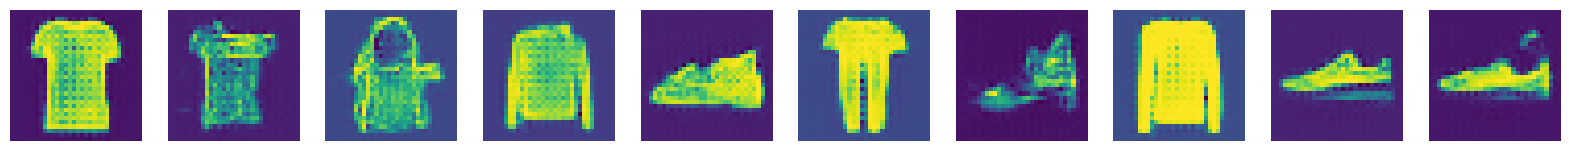

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2142 - c_wass_loss: -0.2529 - c_gp: 0.0039 - g_loss: -0.0061
Epoch 69/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2176 - c_wass_loss: -0.2571 - c_gp: 0.0039 - g_loss: -0.0037
Saved to ./output/output_wgangp/generated_img_068.png


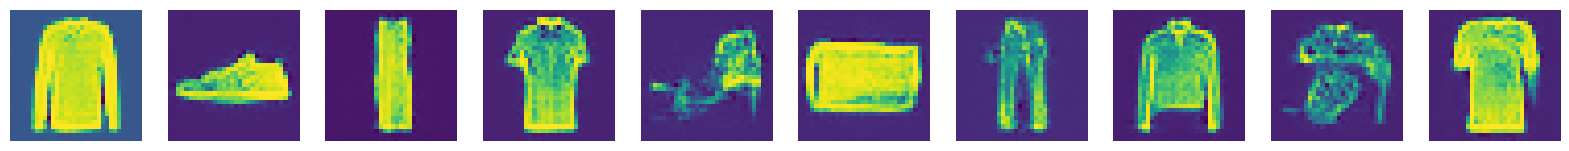

117/117 [==============================] - 28s 237ms/step - c_loss: -0.2176 - c_wass_loss: -0.2571 - c_gp: 0.0039 - g_loss: -0.0037
Epoch 70/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2000 - c_wass_loss: -0.2372 - c_gp: 0.0037 - g_loss: -0.0672
Saved to ./output/output_wgangp/generated_img_069.png


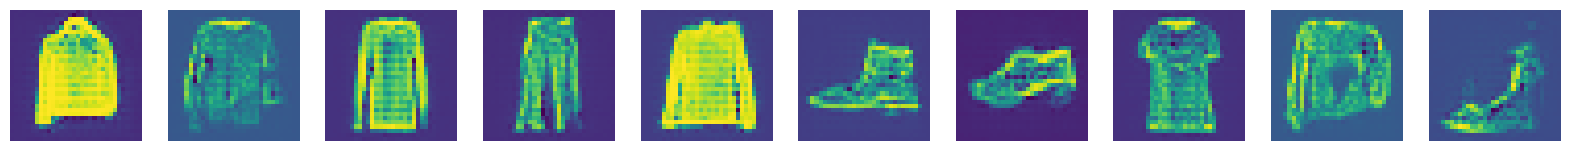

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2000 - c_wass_loss: -0.2372 - c_gp: 0.0037 - g_loss: -0.0672
Epoch 71/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1933 - c_wass_loss: -0.2303 - c_gp: 0.0037 - g_loss: -0.0740
Saved to ./output/output_wgangp/generated_img_070.png


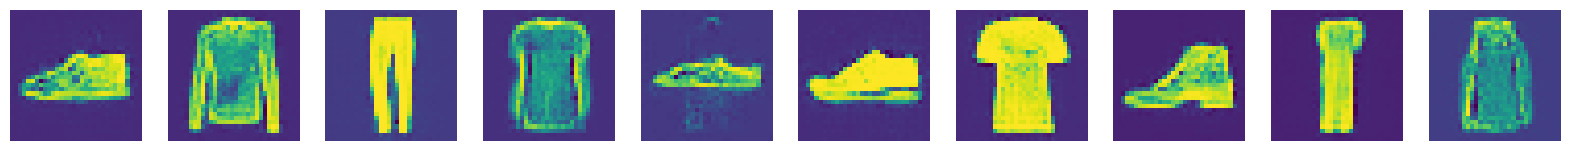

117/117 [==============================] - 28s 235ms/step - c_loss: -0.1933 - c_wass_loss: -0.2303 - c_gp: 0.0037 - g_loss: -0.0740
Epoch 72/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2093 - c_wass_loss: -0.2488 - c_gp: 0.0040 - g_loss: -0.0478
Saved to ./output/output_wgangp/generated_img_071.png


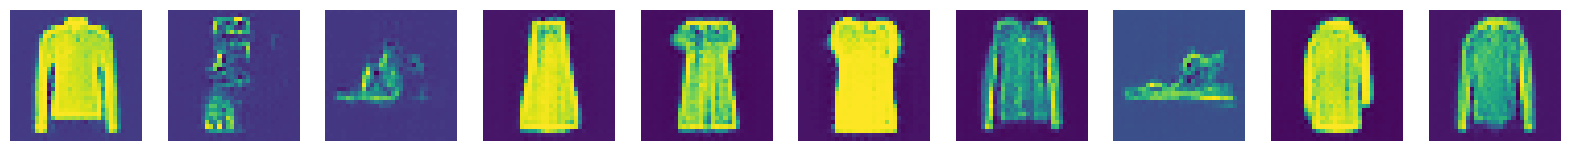

117/117 [==============================] - 27s 235ms/step - c_loss: -0.2093 - c_wass_loss: -0.2488 - c_gp: 0.0040 - g_loss: -0.0478
Epoch 73/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1968 - c_wass_loss: -0.2340 - c_gp: 0.0037 - g_loss: -0.0581
Saved to ./output/output_wgangp/generated_img_072.png


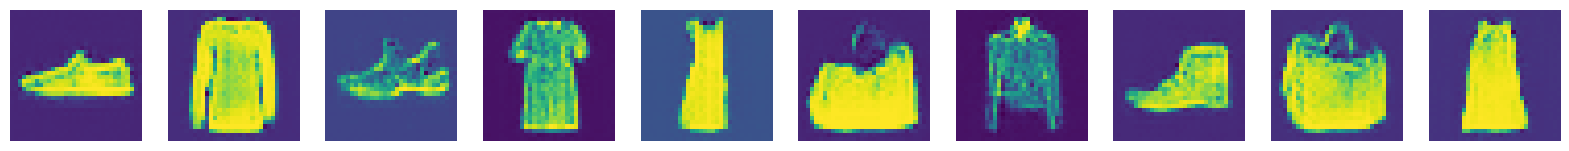

117/117 [==============================] - 28s 235ms/step - c_loss: -0.1968 - c_wass_loss: -0.2340 - c_gp: 0.0037 - g_loss: -0.0581
Epoch 74/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2058 - c_wass_loss: -0.2429 - c_gp: 0.0037 - g_loss: -0.0386
Saved to ./output/output_wgangp/generated_img_073.png


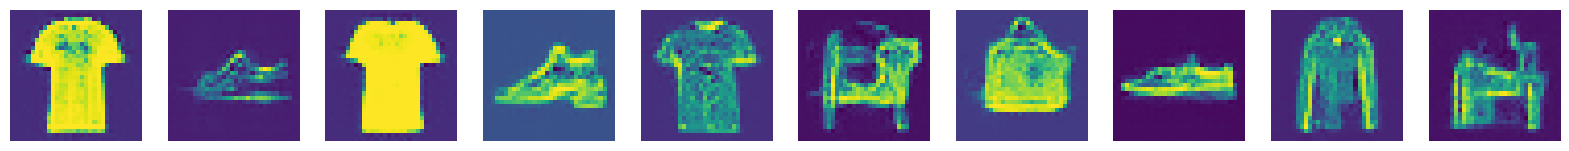

117/117 [==============================] - 28s 240ms/step - c_loss: -0.2058 - c_wass_loss: -0.2429 - c_gp: 0.0037 - g_loss: -0.0386
Epoch 75/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1970 - c_wass_loss: -0.2342 - c_gp: 0.0037 - g_loss: -0.0505
Saved to ./output/output_wgangp/generated_img_074.png


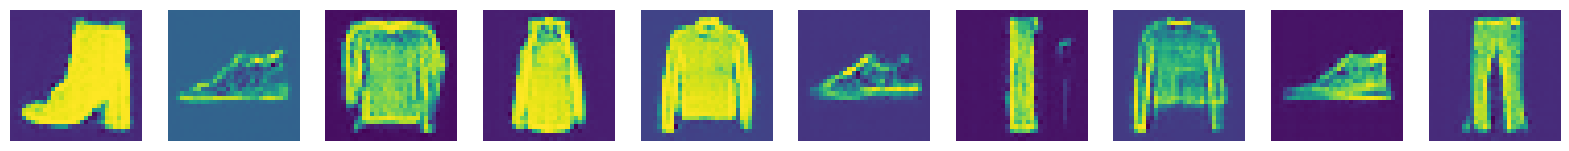

117/117 [==============================] - 28s 235ms/step - c_loss: -0.1970 - c_wass_loss: -0.2342 - c_gp: 0.0037 - g_loss: -0.0505
Epoch 76/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2005 - c_wass_loss: -0.2385 - c_gp: 0.0038 - g_loss: -0.0458
Saved to ./output/output_wgangp/generated_img_075.png


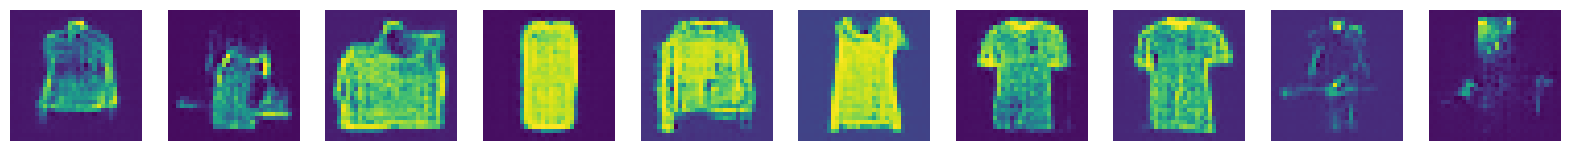

117/117 [==============================] - 28s 239ms/step - c_loss: -0.2005 - c_wass_loss: -0.2385 - c_gp: 0.0038 - g_loss: -0.0458
Epoch 77/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1897 - c_wass_loss: -0.2266 - c_gp: 0.0037 - g_loss: -0.0417
Saved to ./output/output_wgangp/generated_img_076.png


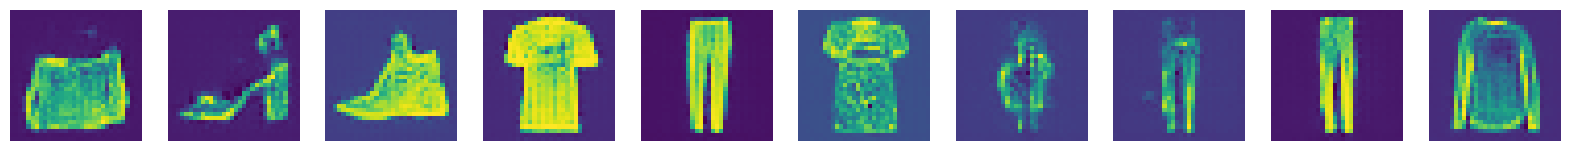

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1897 - c_wass_loss: -0.2266 - c_gp: 0.0037 - g_loss: -0.0417
Epoch 78/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1888 - c_wass_loss: -0.2254 - c_gp: 0.0037 - g_loss: -0.0714
Saved to ./output/output_wgangp/generated_img_077.png


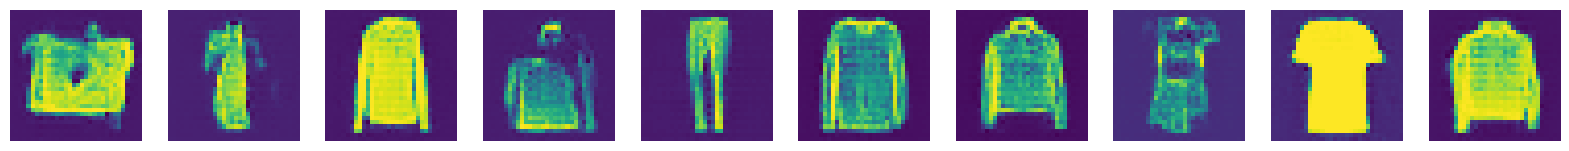

117/117 [==============================] - 28s 235ms/step - c_loss: -0.1888 - c_wass_loss: -0.2254 - c_gp: 0.0037 - g_loss: -0.0714
Epoch 79/100
117/117 [==============================] - ETA: 0s - c_loss: -0.2003 - c_wass_loss: -0.2383 - c_gp: 0.0038 - g_loss: -0.0441
Saved to ./output/output_wgangp/generated_img_078.png


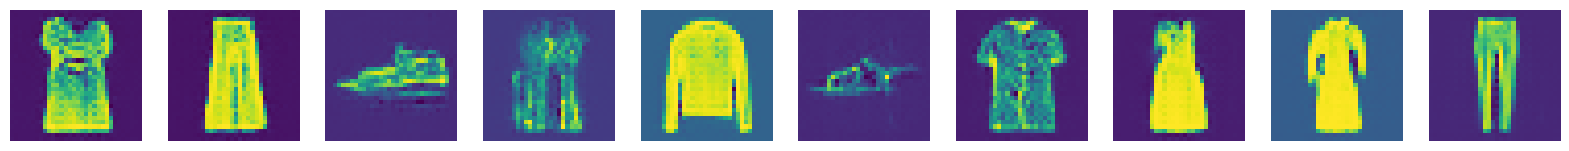

117/117 [==============================] - 28s 235ms/step - c_loss: -0.2003 - c_wass_loss: -0.2383 - c_gp: 0.0038 - g_loss: -0.0441
Epoch 80/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1993 - c_wass_loss: -0.2366 - c_gp: 0.0037 - g_loss: -9.0869e-04
Saved to ./output/output_wgangp/generated_img_079.png


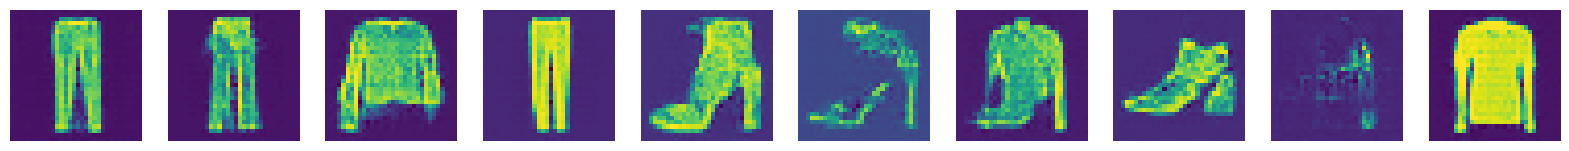

117/117 [==============================] - 28s 238ms/step - c_loss: -0.1993 - c_wass_loss: -0.2366 - c_gp: 0.0037 - g_loss: -9.0869e-04
Epoch 81/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1905 - c_wass_loss: -0.2262 - c_gp: 0.0036 - g_loss: -0.0597
Saved to ./output/output_wgangp/generated_img_080.png


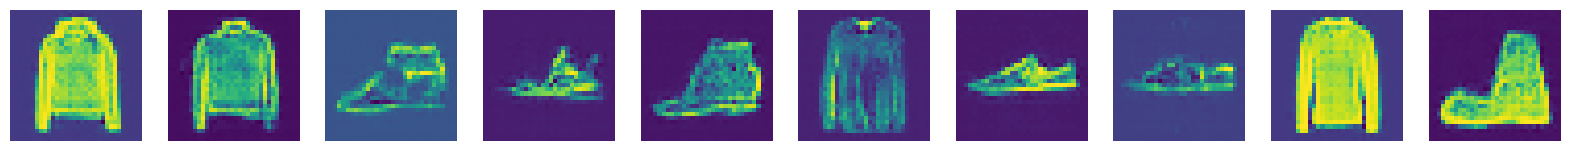

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1905 - c_wass_loss: -0.2262 - c_gp: 0.0036 - g_loss: -0.0597
Epoch 82/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1929 - c_wass_loss: -0.2295 - c_gp: 0.0037 - g_loss: -0.0512
Saved to ./output/output_wgangp/generated_img_081.png


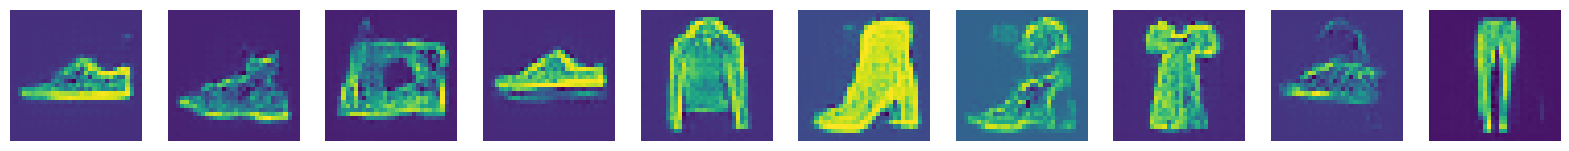

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1929 - c_wass_loss: -0.2295 - c_gp: 0.0037 - g_loss: -0.0512
Epoch 83/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1973 - c_wass_loss: -0.2332 - c_gp: 0.0036 - g_loss: -0.0371
Saved to ./output/output_wgangp/generated_img_082.png


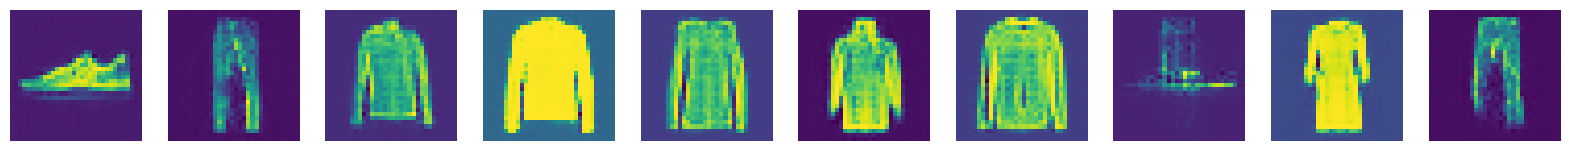

117/117 [==============================] - 28s 239ms/step - c_loss: -0.1973 - c_wass_loss: -0.2332 - c_gp: 0.0036 - g_loss: -0.0371
Epoch 84/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1901 - c_wass_loss: -0.2258 - c_gp: 0.0036 - g_loss: -0.0483
Saved to ./output/output_wgangp/generated_img_083.png


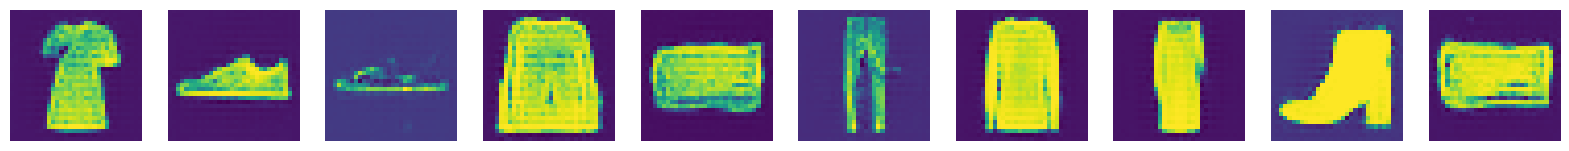

117/117 [==============================] - 28s 237ms/step - c_loss: -0.1901 - c_wass_loss: -0.2258 - c_gp: 0.0036 - g_loss: -0.0483
Epoch 85/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1864 - c_wass_loss: -0.2227 - c_gp: 0.0036 - g_loss: -0.0348
Saved to ./output/output_wgangp/generated_img_084.png


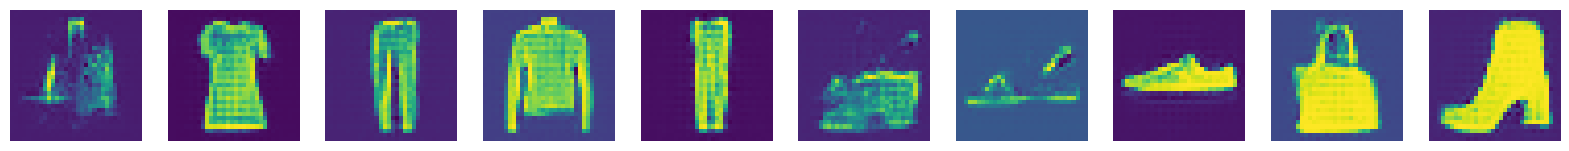

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1864 - c_wass_loss: -0.2227 - c_gp: 0.0036 - g_loss: -0.0348
Epoch 86/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1778 - c_wass_loss: -0.2134 - c_gp: 0.0036 - g_loss: -0.0684
Saved to ./output/output_wgangp/generated_img_085.png


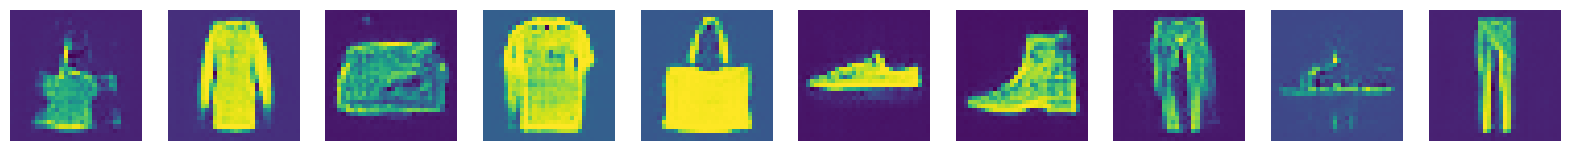

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1778 - c_wass_loss: -0.2134 - c_gp: 0.0036 - g_loss: -0.0684
Epoch 87/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1855 - c_wass_loss: -0.2216 - c_gp: 0.0036 - g_loss: -0.0363
Saved to ./output/output_wgangp/generated_img_086.png


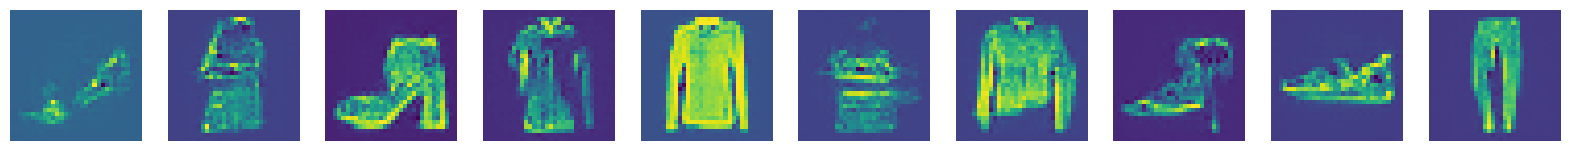

117/117 [==============================] - 28s 236ms/step - c_loss: -0.1855 - c_wass_loss: -0.2216 - c_gp: 0.0036 - g_loss: -0.0363
Epoch 88/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1834 - c_wass_loss: -0.2194 - c_gp: 0.0036 - g_loss: -0.0520
Saved to ./output/output_wgangp/generated_img_087.png


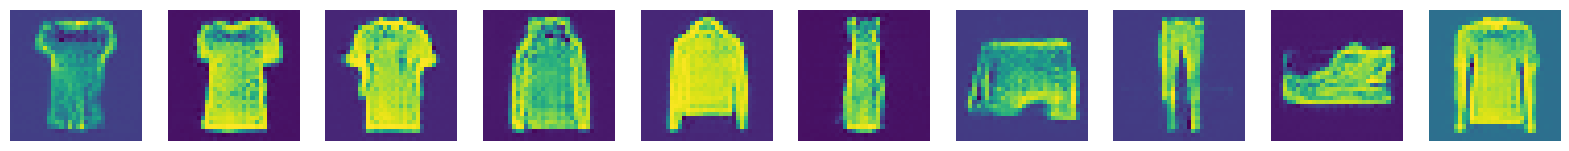

117/117 [==============================] - 27s 234ms/step - c_loss: -0.1834 - c_wass_loss: -0.2194 - c_gp: 0.0036 - g_loss: -0.0520
Epoch 89/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1828 - c_wass_loss: -0.2187 - c_gp: 0.0036 - g_loss: -0.0574
Saved to ./output/output_wgangp/generated_img_088.png


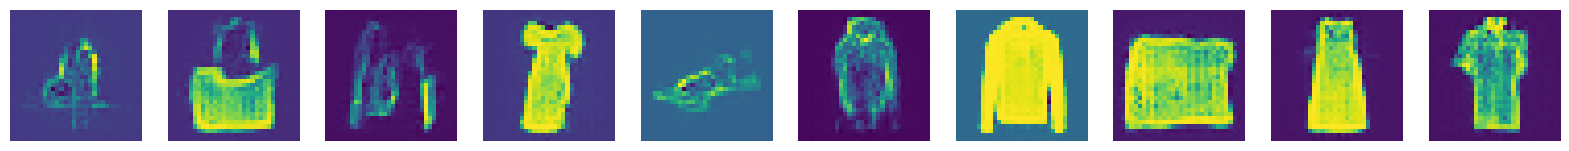

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1828 - c_wass_loss: -0.2187 - c_gp: 0.0036 - g_loss: -0.0574
Epoch 90/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1879 - c_wass_loss: -0.2229 - c_gp: 0.0035 - g_loss: -0.0234
Saved to ./output/output_wgangp/generated_img_089.png


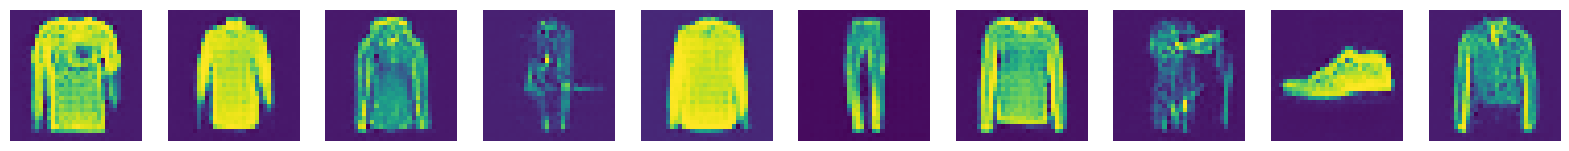

117/117 [==============================] - 28s 235ms/step - c_loss: -0.1879 - c_wass_loss: -0.2229 - c_gp: 0.0035 - g_loss: -0.0234
Epoch 91/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1799 - c_wass_loss: -0.2147 - c_gp: 0.0035 - g_loss: -0.0497
Saved to ./output/output_wgangp/generated_img_090.png


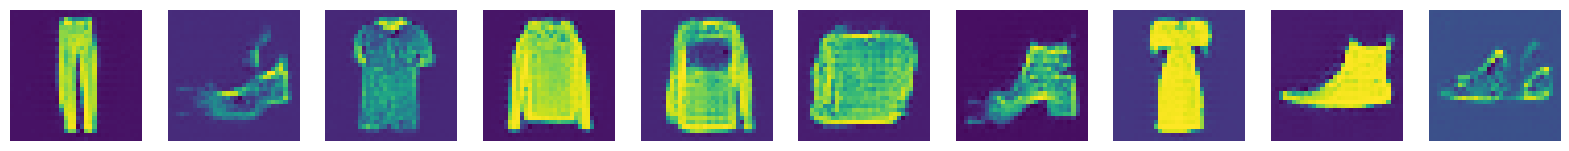

117/117 [==============================] - 28s 238ms/step - c_loss: -0.1799 - c_wass_loss: -0.2147 - c_gp: 0.0035 - g_loss: -0.0497
Epoch 92/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1856 - c_wass_loss: -0.2215 - c_gp: 0.0036 - g_loss: -0.0544
Saved to ./output/output_wgangp/generated_img_091.png


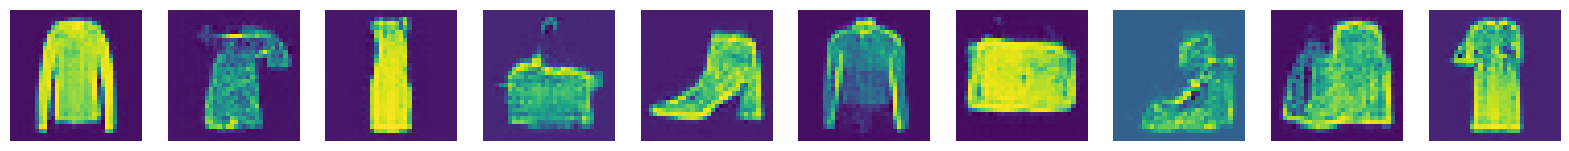

117/117 [==============================] - 27s 234ms/step - c_loss: -0.1856 - c_wass_loss: -0.2215 - c_gp: 0.0036 - g_loss: -0.0544
Epoch 93/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1753 - c_wass_loss: -0.2102 - c_gp: 0.0035 - g_loss: -0.0275
Saved to ./output/output_wgangp/generated_img_092.png


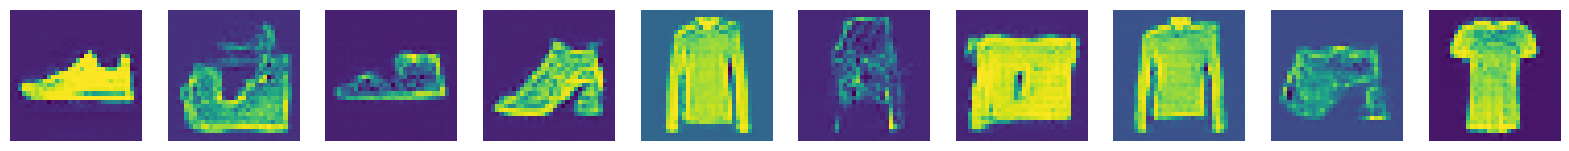

117/117 [==============================] - 28s 239ms/step - c_loss: -0.1753 - c_wass_loss: -0.2102 - c_gp: 0.0035 - g_loss: -0.0275
Epoch 94/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1841 - c_wass_loss: -0.2186 - c_gp: 0.0034 - g_loss: -0.0542
Saved to ./output/output_wgangp/generated_img_093.png


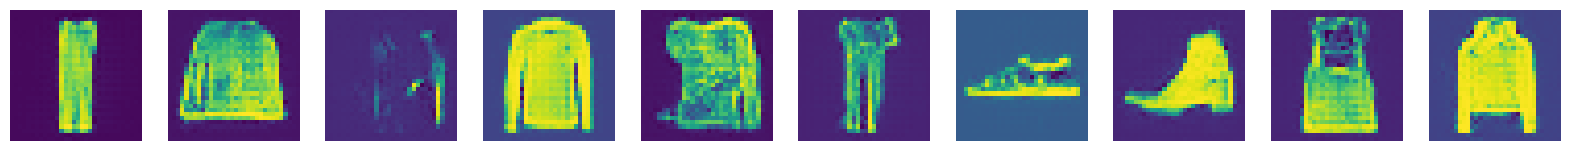

117/117 [==============================] - 28s 239ms/step - c_loss: -0.1841 - c_wass_loss: -0.2186 - c_gp: 0.0034 - g_loss: -0.0542
Epoch 95/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1798 - c_wass_loss: -0.2155 - c_gp: 0.0036 - g_loss: -0.0254
Saved to ./output/output_wgangp/generated_img_094.png


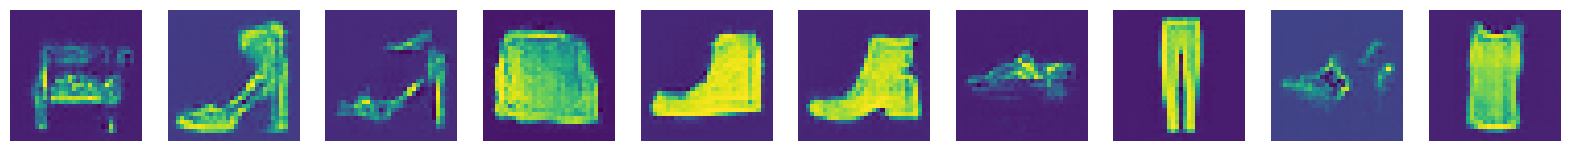

117/117 [==============================] - 28s 236ms/step - c_loss: -0.1798 - c_wass_loss: -0.2155 - c_gp: 0.0036 - g_loss: -0.0254
Epoch 96/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1728 - c_wass_loss: -0.2073 - c_gp: 0.0034 - g_loss: -0.0733
Saved to ./output/output_wgangp/generated_img_095.png


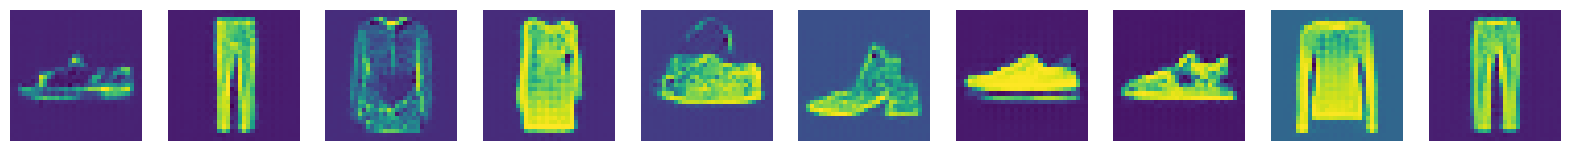

117/117 [==============================] - 28s 236ms/step - c_loss: -0.1728 - c_wass_loss: -0.2073 - c_gp: 0.0034 - g_loss: -0.0733
Epoch 97/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1745 - c_wass_loss: -0.2090 - c_gp: 0.0035 - g_loss: -0.0419
Saved to ./output/output_wgangp/generated_img_096.png


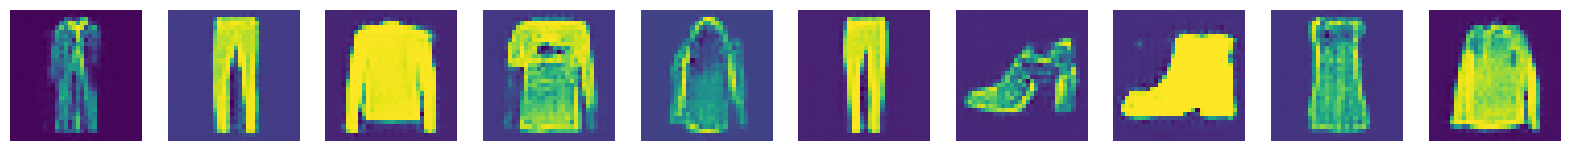

117/117 [==============================] - 27s 235ms/step - c_loss: -0.1745 - c_wass_loss: -0.2090 - c_gp: 0.0035 - g_loss: -0.0419
Epoch 98/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1782 - c_wass_loss: -0.2119 - c_gp: 0.0034 - g_loss: -0.0254
Saved to ./output/output_wgangp/generated_img_097.png


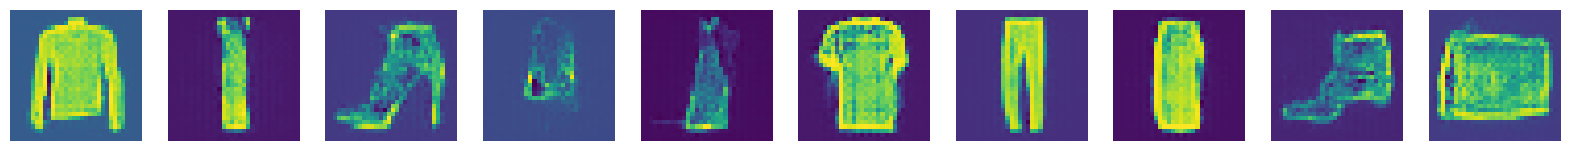

117/117 [==============================] - 28s 235ms/step - c_loss: -0.1782 - c_wass_loss: -0.2119 - c_gp: 0.0034 - g_loss: -0.0254
Epoch 99/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1854 - c_wass_loss: -0.2206 - c_gp: 0.0035 - g_loss: -0.0455
Saved to ./output/output_wgangp/generated_img_098.png


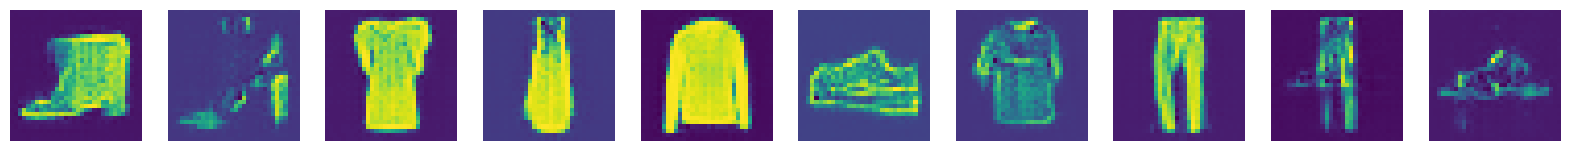

117/117 [==============================] - 28s 238ms/step - c_loss: -0.1854 - c_wass_loss: -0.2206 - c_gp: 0.0035 - g_loss: -0.0455
Epoch 100/100
117/117 [==============================] - ETA: 0s - c_loss: -0.1823 - c_wass_loss: -0.2183 - c_gp: 0.0036 - g_loss: -0.0389
Saved to ./output/output_wgangp/generated_img_099.png


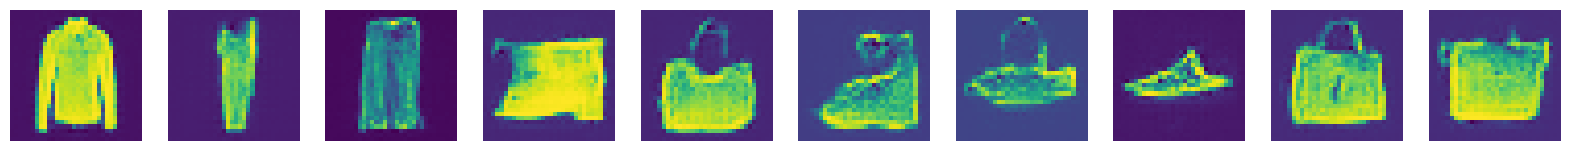

117/117 [==============================] - 27s 234ms/step - c_loss: -0.1823 - c_wass_loss: -0.2183 - c_gp: 0.0036 - g_loss: -0.0389
################################################## END TRAINING ##################################################


Saving Models...


Saving Done




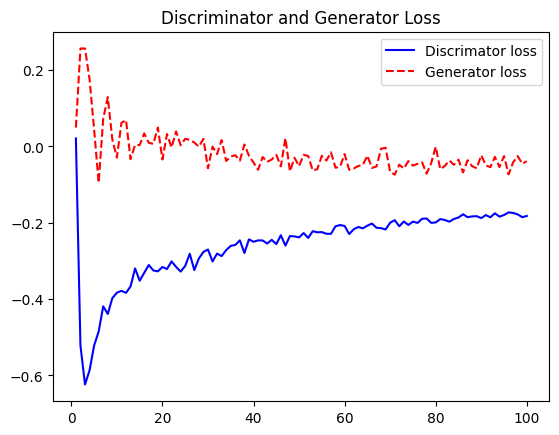

<Figure size 640x480 with 0 Axes>

In [46]:
history_wgangp, wgangp = train(wgangp,
                              "wgangp",
                              epochs=EPOCHS,
                              d_optimizer=optimizers.Adam(learning_rate=0.0001, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
                              g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
                              save_models=True,
                              plot_history_flag=True,
                              load_model=LOAD_MODEL
                               )

Generated images dataset shape: (10000, 32, 32, 1)


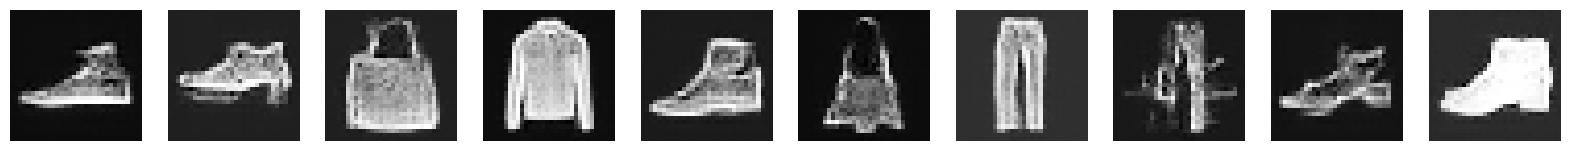

In [50]:
generated_images_wgangp = generate_images(wgangp, 10000)
print(f"Generated images dataset shape: {generated_images_wgangp.shape}")
plot_images(generated_images_wgangp,cmap="gray")

In [51]:
train_fid = get_fid(test_data, generated_images_wgangp)

# Print out the results
print(f"FID(x_test, x_train) = {train_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
Done stage 1 of 2
1/1 [==============================] - 0s 171ms/step
Processed 100 images.
1/1 [==============================] - 0s 180ms/step
Processed 200 images.
1/1 [==============================] - 0s 158ms/step
Processed 300 images.
1/1 [==============================] - 0s 173ms/step
Processed 400 images.
1/1 [==============================] - 0s 181ms/step
Processed 500 images.
1/1 [==============================] - 0s 170ms/step
Processed 600 images.
1/1 [==============================] - 0s 164ms/step
Processed 700 images.
1/1 [==============================] - 0s 162ms/step
Processed 800 images.
1/1 [==============================] - 0s 172ms/step
Processed 900 images.
1/1 [==============================] - 0s 173ms/step
Processed 1000 images.
1/1 [==============================] - 0s 145ms/step
Processed 1100 images.
1/1 [==============================] - 0s 123ms/step
Processed 1200 images.
1/1 [==================